##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5). This is an advanced example that assumes some knowledge of:

* Sequence to sequence models
* TensorFlow fundamentals below the keras layer: 
  * Working with tensors directly 
  * Writing custom `keras.Model`s and `keras.layers`

While this architecture is somewhat outdated it is still a very useful project to work through to get a deeper understanding of attention mechanisms (before going on to [Transformers](transformer.ipynb)).

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

## Setup

In [2]:
!pip install tensorflow_text

  Using cached tensorflow_text-2.7.3-cp37-cp37m-manylinux2010_x86_64.whl (4.9 MB)


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

This tutorial builds a few layers from scratch, use this variable if you want to switch between the custom and builtin implementations.

In [4]:
use_builtins = True

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial. 


In [5]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but we'll use the English-Spanish dataset.

### Download and prepare the dataset

For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [6]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

  16384/2638744 [..............................] - ETA: 0s

2646016/2638744 [==============================] - 0s 0us/step


2654208/2638744 [==============================] - 0s 0us/step


In [7]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [8]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [9]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [10]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [11]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'No s\xc3\xa9 lo que quiero.' b'\xc2\xbfDeber\xc3\xada repetirlo?'
 b'Tard\xc3\xa9 m\xc3\xa1s de 2 horas en traducir unas p\xc3\xa1ginas en ingl\xc3\xa9s.'
 b'A Tom comenz\xc3\xb3 a temerle a Mary.' b'Mi pasatiempo es la lectura.'], shape=(5,), dtype=string)

tf.Tensor(
[b"I don't know what I want." b'Should I repeat it?'
 b'It took me more than two hours to translate a few pages of English.'
 b'Tom became afraid of Mary.' b'My hobby is reading.'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. 

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [12]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [13]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [15]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

The `TextVectorization` layer and many other preprocessing layers have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:  

In [16]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [17]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [18]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,    9,   17,   22,    5,   48,    4,    3,    0,    0],
       [   2,   13,  177,    1,   12,    3,    0,    0,    0,    0],
       [   2,  120,   35,    6,  290,   14, 2134,  506, 2637,   14]])>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [19]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] no se lo que quiero . [END]      '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

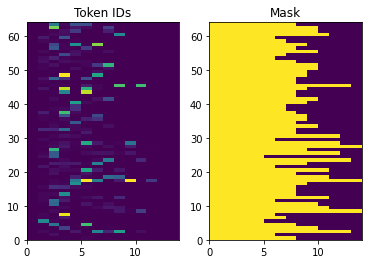

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Before getting into it define a few constants for the model:

In [21]:
embedding_dim = 256
units = 1024

### The encoder

Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs (from `input_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder


In [22]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

Here is how it fits together so far:

In [23]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 14)
Encoder output, shape (batch, s, units): (64, 14, 1024)
Encoder state, shape (batch, units): (64, 1024)


The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="images/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="images/attention_equation_2.jpg" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.


Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="images/attention_equation_4.jpg" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the builtin implementation.

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Test the Attention layer

Create a `BahdanauAttention` layer:

In [25]:
attention_layer = BahdanauAttention(units)

This layer takes 3 inputs:

* The `query`: This will be generated by the decoder, later.
* The `value`: This Will be the output of the encoder.
* The `mask`: To exclude the padding, `example_tokens != 0`

In [26]:
(example_tokens != 0).shape

TensorShape([64, 14])

The vectorized implementation of the attention layer lets you pass a batch of sequences of query vectors and a batch of sequence of value vectors. The result is:

1. A batch of sequences of result vectors the size of the queries.
2. A batch attention maps, with size `(query_length, value_length)`.

In [27]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 14)


The attention weights should sum to `1.0` for each sequence.

Here are the attention weights across the sequences at `t=0`:

Text(0.5, 1.0, 'Mask')

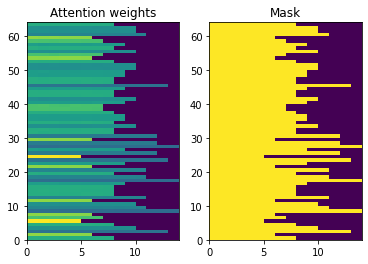

In [28]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


Because of the small-random initialization the attention weights are all close to `1/(sequence_length)`. If you zoom in on the weights for a single sequence, you can see that there is some _small_ variation that the model can learn to expand, and exploit.

In [29]:
attention_weights.shape

TensorShape([64, 2, 14])

In [30]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

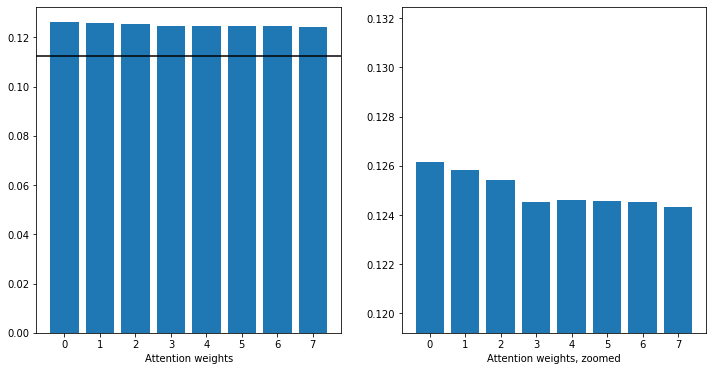

In [31]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="images/attention_equation_3.jpg" alt="attention equation 3" width="800">


Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [32]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The `call` method for this layer takes and returns multiple tensors. Organize those into simple container classes:

In [33]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the `call` method:

In [34]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [35]:
Decoder.call = call

The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer. 
  * Loop free training is demonstrated in the [Text generation](text_generation.ipynb) tutiorial.


Now try using this decoder.

In [36]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs.

* `new_tokens` -  The last token generated. Initialize the decoder with the `"[START]"` token.
* `enc_output` - Generated by the `Encoder`.
* `mask` - A boolean tensor indicating where `tokens != 0`
* `state` - The previous `state` output from the decoder (the internal state
  of the decoder's RNN). Pass `None` to zero-initialize it. The original
  paper initializes it from the encoder's final RNN state. 

In [37]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [38]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


Sample a token according to the logits:

In [39]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode the token as the first word of the output:

In [40]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['already'],
       ['plants'],
       ['pretended'],
       ['convince'],
       ['square']], dtype='<U16')

Now use the decoder to generate a second set of logits.

- Pass the same `enc_output` and `mask`, these haven't changed.
- Pass the sampled token as `new_tokens`.
- Pass the `decoder_state` the decoder returned last time, so the RNN continues with a memory of where it left off last time.


In [41]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [42]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['nap'],
       ['mean'],
       ['worker'],
       ['passage'],
       ['baked']], dtype='<U16')

## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [43]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [44]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_preprocess` method, added below, implements steps #1 and #2: 

In [45]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [46]:
TrainTranslator._preprocess = _preprocess

The `_train_step` method, added below, handles the remaining steps except for actually running the decoder: 

In [47]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [48]:
TrainTranslator._train_step = _train_step

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [49]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [50]:
TrainTranslator._loop_step = _loop_step

### Test the training step

Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [51]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Test out the `train_step`. For a text model like this the loss should start near:

In [52]:
np.log(output_text_processor.vocabulary_size())

8.517193191416236

In [53]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5849695>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.55271>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4929113>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3296022>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.80437>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.000246>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.8740363>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.794589>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3175836>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.108163>}

CPU times: user 5.49 s, sys: 0 ns, total: 5.49 s
Wall time: 5.45 s


While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training:

In [54]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [55]:
TrainTranslator._tf_train_step = _tf_train_step

In [56]:
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [57]:
translator.train_step([example_input_batch, example_target_batch])

2021-12-04 12:09:48.074769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2021-12-04 12:09:48.180156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2021-12-04 12:09:48.285846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2021-12-04 12:09:48.307794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.045638>}

But after that it's usually 2-3x faster than the eager `train_step` method:

In [58]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1098256>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.169871>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.139249>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0410743>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9664454>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.895707>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8154407>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7583396>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6986444>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.640298>}

CPU times: user 4.4 s, sys: 960 ms, total: 5.36 s
Wall time: 1.67 s


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

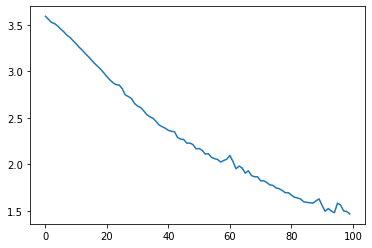

In [59]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [60]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [61]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [62]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3


2021-12-04 12:10:11.617839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2021-12-04 12:10:11.737105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2021-12-04 12:10:11.855054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2021-12-04 12:10:11.878896: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/wh

   1/1859 [..............................] - ETA: 2:43:54 - batch_loss: 7.6041

   2/1859 [..............................] - ETA: 5:26 - batch_loss: 7.6058   

   3/1859 [..............................] - ETA: 5:39 - batch_loss: 7.5938

   4/1859 [..............................] - ETA: 5:37 - batch_loss: 7.5483

   5/1859 [..............................] - ETA: 5:40 - batch_loss: 7.4269

   6/1859 [..............................] - ETA: 5:32 - batch_loss: 7.1192

   7/1859 [..............................] - ETA: 5:46 - batch_loss: 6.9554

   8/1859 [..............................] - ETA: 5:33 - batch_loss: 6.7422

   9/1859 [..............................] - ETA: 5:28 - batch_loss: 6.5651

  10/1859 [..............................] - ETA: 5:23 - batch_loss: 6.4076

  11/1859 [..............................] - ETA: 5:24 - batch_loss: 6.2941

  12/1859 [..............................] - ETA: 5:24 - batch_loss: 6.2119

  13/1859 [..............................] - ETA: 5:26 - batch_loss: 6.1300

  14/1859 [..............................] - ETA: 5:26 - batch_loss: 6.0501

  15/1859 [..............................] - ETA: 5:29 - batch_loss: 5.9810

  16/1859 [..............................] - ETA: 5:30 - batch_loss: 5.9132

  17/1859 [..............................] - ETA: 5:31 - batch_loss: 5.8512

  18/1859 [..............................] - ETA: 5:37 - batch_loss: 5.7955

  19/1859 [..............................] - ETA: 5:34 - batch_loss: 5.7525

  20/1859 [..............................] - ETA: 5:34 - batch_loss: 5.7005

  21/1859 [..............................] - ETA: 5:31 - batch_loss: 5.6552

  22/1859 [..............................] - ETA: 5:29 - batch_loss: 5.6096

  23/1859 [..............................] - ETA: 5:27 - batch_loss: 5.5672

  24/1859 [..............................] - ETA: 5:28 - batch_loss: 5.5257

  25/1859 [..............................] - ETA: 5:27 - batch_loss: 5.4896

  26/1859 [..............................] - ETA: 5:27 - batch_loss: 5.4648

  27/1859 [..............................] - ETA: 5:26 - batch_loss: 5.4205

  28/1859 [..............................] - ETA: 5:25 - batch_loss: 5.3913

  29/1859 [..............................] - ETA: 5:27 - batch_loss: 5.3679

  30/1859 [..............................] - ETA: 5:24 - batch_loss: 5.3337

  31/1859 [..............................] - ETA: 5:27 - batch_loss: 5.3094

  32/1859 [..............................] - ETA: 5:25 - batch_loss: 5.2836

  33/1859 [..............................] - ETA: 5:24 - batch_loss: 5.2544

  34/1859 [..............................] - ETA: 5:22 - batch_loss: 5.2309

  35/1859 [..............................] - ETA: 5:25 - batch_loss: 5.2118

  36/1859 [..............................] - ETA: 5:28 - batch_loss: 5.1978

  37/1859 [..............................] - ETA: 5:29 - batch_loss: 5.1779

  38/1859 [..............................] - ETA: 5:32 - batch_loss: 5.1590

  39/1859 [..............................] - ETA: 5:31 - batch_loss: 5.1377

  40/1859 [..............................] - ETA: 5:31 - batch_loss: 5.1225

  41/1859 [..............................] - ETA: 5:33 - batch_loss: 5.1065

  42/1859 [..............................] - ETA: 5:32 - batch_loss: 5.0885

  43/1859 [..............................] - ETA: 5:32 - batch_loss: 5.0753

  44/1859 [..............................] - ETA: 5:31 - batch_loss: 5.0599

  45/1859 [..............................] - ETA: 5:32 - batch_loss: 5.0412

  46/1859 [..............................] - ETA: 5:32 - batch_loss: 5.0289

  47/1859 [..............................] - ETA: 5:31 - batch_loss: 5.0111

  48/1859 [..............................] - ETA: 5:30 - batch_loss: 4.9938

  49/1859 [..............................] - ETA: 5:30 - batch_loss: 4.9810

  50/1859 [..............................] - ETA: 5:28 - batch_loss: 4.9680

  51/1859 [..............................] - ETA: 5:27 - batch_loss: 4.9521

  52/1859 [..............................] - ETA: 5:28 - batch_loss: 4.9393

  53/1859 [..............................] - ETA: 5:27 - batch_loss: 4.9269

  54/1859 [..............................] - ETA: 5:27 - batch_loss: 4.9164

  55/1859 [..............................] - ETA: 5:27 - batch_loss: 4.9048

  56/1859 [..............................] - ETA: 5:27 - batch_loss: 4.8955

  57/1859 [..............................] - ETA: 5:26 - batch_loss: 4.8825

  58/1859 [..............................] - ETA: 5:25 - batch_loss: 4.8708

  59/1859 [..............................] - ETA: 5:25 - batch_loss: 4.8617

  60/1859 [..............................] - ETA: 5:24 - batch_loss: 4.8483

  61/1859 [..............................] - ETA: 5:24 - batch_loss: 4.8389

  62/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.8316

  63/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.8244

  64/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.8159

  65/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.8072

  66/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.7993

  67/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.7878

  68/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.7780

  69/1859 [>.............................] - ETA: 5:32 - batch_loss: 4.7718

  70/1859 [>.............................] - ETA: 5:31 - batch_loss: 4.7646

  71/1859 [>.............................] - ETA: 5:30 - batch_loss: 4.7555

  72/1859 [>.............................] - ETA: 5:31 - batch_loss: 4.7465

  73/1859 [>.............................] - ETA: 5:32 - batch_loss: 4.7375

  74/1859 [>.............................] - ETA: 5:31 - batch_loss: 4.7293

  75/1859 [>.............................] - ETA: 5:31 - batch_loss: 4.7203

  76/1859 [>.............................] - ETA: 5:31 - batch_loss: 4.7125

  77/1859 [>.............................] - ETA: 5:30 - batch_loss: 4.7040

  78/1859 [>.............................] - ETA: 5:30 - batch_loss: 4.6968

  79/1859 [>.............................] - ETA: 5:30 - batch_loss: 4.6910

  80/1859 [>.............................] - ETA: 5:30 - batch_loss: 4.6827

  81/1859 [>.............................] - ETA: 5:29 - batch_loss: 4.6740

  82/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.6669

  83/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.6605

  84/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.6519

  85/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.6440

  86/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.6369

  87/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.6293

  88/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.6228

  89/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.6154

  90/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.6103

  91/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.6044

  92/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.5983

  93/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.5939

  94/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.5861

  95/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.5805

  96/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.5730

  97/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.5687

  98/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5608

  99/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.5571

 100/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.5513

 101/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.5461

 102/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.5405

 103/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5332

 104/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5275

 105/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.5221

 106/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.5181

 107/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.5113

 108/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.5050

 109/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4982

 110/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4929

 111/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4859

 112/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4800

 113/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4755

 114/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4706

 115/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4657

 116/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4608

 117/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4560

 118/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4502

 119/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4456

 120/1859 [>.............................] - ETA: 5:22 - batch_loss: 4.4387

 121/1859 [>.............................] - ETA: 5:21 - batch_loss: 4.4333

 122/1859 [>.............................] - ETA: 5:21 - batch_loss: 4.4291

 123/1859 [>.............................] - ETA: 5:21 - batch_loss: 4.4239

 124/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.4181

 125/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.4135

 126/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.4092

 127/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.4052

 128/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.4003

 129/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3963

 130/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3915

 131/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3890

 132/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3847

 133/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3817

 134/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3783

 135/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3737

 136/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3686

 137/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3654

 138/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3601

 139/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3561

 140/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3524

 141/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3470

 142/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3425

 143/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3389

 144/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3352

 145/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3323

 146/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3285

 147/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3248

 148/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3197

 149/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3141

 150/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3096

 151/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3058

 152/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.3024

 153/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.2979

 154/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2938

 155/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2897

 156/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2860

 157/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2817

 158/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2775

 159/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2731

 160/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2705

 161/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2655

 162/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2616

 163/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2578

 164/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2545

 165/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2503

 166/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2465

 167/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.2427

 168/1859 [=>............................] - ETA: 5:14 - batch_loss: 4.2390

 169/1859 [=>............................] - ETA: 5:14 - batch_loss: 4.2349

 170/1859 [=>............................] - ETA: 5:13 - batch_loss: 4.2310

 171/1859 [=>............................] - ETA: 5:13 - batch_loss: 4.2283

 172/1859 [=>............................] - ETA: 5:13 - batch_loss: 4.2256

 173/1859 [=>............................] - ETA: 5:13 - batch_loss: 4.2215

 174/1859 [=>............................] - ETA: 5:13 - batch_loss: 4.2172

 175/1859 [=>............................] - ETA: 5:13 - batch_loss: 4.2128

 176/1859 [=>............................] - ETA: 5:12 - batch_loss: 4.2098

 177/1859 [=>............................] - ETA: 5:12 - batch_loss: 4.2061

 178/1859 [=>............................] - ETA: 5:11 - batch_loss: 4.2016

 179/1859 [=>............................] - ETA: 5:11 - batch_loss: 4.1986

 180/1859 [=>............................] - ETA: 5:11 - batch_loss: 4.1946

 181/1859 [=>............................] - ETA: 5:11 - batch_loss: 4.1907

 182/1859 [=>............................] - ETA: 5:11 - batch_loss: 4.1867

 183/1859 [=>............................] - ETA: 5:11 - batch_loss: 4.1843

 184/1859 [=>............................] - ETA: 5:11 - batch_loss: 4.1806

 185/1859 [=>............................] - ETA: 5:10 - batch_loss: 4.1765

 186/1859 [==>...........................] - ETA: 5:10 - batch_loss: 4.1732

 187/1859 [==>...........................] - ETA: 5:10 - batch_loss: 4.1706

 188/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1670

 189/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1638

 190/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1606

 191/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1572

 192/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1535

 193/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1498

 194/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1473

 195/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.1439

 196/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.1393

 197/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.1361

 198/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.1333

 199/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.1306

 200/1859 [==>...........................] - ETA: 5:07 - batch_loss: 4.1277

 201/1859 [==>...........................] - ETA: 5:07 - batch_loss: 4.1243

 202/1859 [==>...........................] - ETA: 5:06 - batch_loss: 4.1207

 203/1859 [==>...........................] - ETA: 5:06 - batch_loss: 4.1176

 204/1859 [==>...........................] - ETA: 5:06 - batch_loss: 4.1135

 205/1859 [==>...........................] - ETA: 5:05 - batch_loss: 4.1099

 206/1859 [==>...........................] - ETA: 5:05 - batch_loss: 4.1059

 207/1859 [==>...........................] - ETA: 5:05 - batch_loss: 4.1026

 208/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0989

 209/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0949

 210/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0916

 211/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0889

 212/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0856

 213/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0814

 214/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0783

 215/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0750

 216/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0722

 217/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0694

 218/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0659

 219/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0630

 220/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0588

 221/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0546

 222/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0514

 223/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0481

 224/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0451

 225/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0415

 226/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0386

 227/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0346

 228/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0309

 229/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0276

 230/1859 [==>...........................] - ETA: 5:04 - batch_loss: 4.0246

 231/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0211

 232/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0182

 233/1859 [==>...........................] - ETA: 5:03 - batch_loss: 4.0153

 234/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0126

 235/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0096

 236/1859 [==>...........................] - ETA: 5:02 - batch_loss: 4.0068

 237/1859 [==>...........................] - ETA: 5:01 - batch_loss: 4.0037

 238/1859 [==>...........................] - ETA: 5:01 - batch_loss: 4.0013

 239/1859 [==>...........................] - ETA: 5:01 - batch_loss: 3.9986

 240/1859 [==>...........................] - ETA: 5:01 - batch_loss: 3.9953

 241/1859 [==>...........................] - ETA: 5:01 - batch_loss: 3.9922

 242/1859 [==>...........................] - ETA: 5:01 - batch_loss: 3.9886

 243/1859 [==>...........................] - ETA: 5:01 - batch_loss: 3.9872

 244/1859 [==>...........................] - ETA: 5:00 - batch_loss: 3.9842

 245/1859 [==>...........................] - ETA: 5:00 - batch_loss: 3.9808

 246/1859 [==>...........................] - ETA: 5:00 - batch_loss: 3.9774

 247/1859 [==>...........................] - ETA: 5:00 - batch_loss: 3.9746

 248/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9714

 249/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9682

 250/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9653

 251/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9617

 252/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9588

 253/1859 [===>..........................] - ETA: 4:58 - batch_loss: 3.9553

 254/1859 [===>..........................] - ETA: 4:58 - batch_loss: 3.9522

 255/1859 [===>..........................] - ETA: 4:58 - batch_loss: 3.9486

 256/1859 [===>..........................] - ETA: 4:58 - batch_loss: 3.9450

 257/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9416

 258/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9388

 259/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9355

 260/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9320

 261/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9288

 262/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9262

 263/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.9232

 264/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.9204

 265/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.9176

 266/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.9143

 267/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.9108

 268/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.9079

 269/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.9050

 270/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.9016

 271/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8989

 272/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8961

 273/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8933

 274/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8906

 275/1859 [===>..........................] - ETA: 4:53 - batch_loss: 3.8869

 276/1859 [===>..........................] - ETA: 4:53 - batch_loss: 3.8839

 277/1859 [===>..........................] - ETA: 4:53 - batch_loss: 3.8802

 278/1859 [===>..........................] - ETA: 4:52 - batch_loss: 3.8769

 279/1859 [===>..........................] - ETA: 4:53 - batch_loss: 3.8743

 280/1859 [===>..........................] - ETA: 4:52 - batch_loss: 3.8718

 281/1859 [===>..........................] - ETA: 4:52 - batch_loss: 3.8687

 282/1859 [===>..........................] - ETA: 4:52 - batch_loss: 3.8665

 283/1859 [===>..........................] - ETA: 4:52 - batch_loss: 3.8624

 284/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8598

 285/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8573

 286/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8546

 287/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8518

 288/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8489

 289/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8464

 290/1859 [===>..........................] - ETA: 4:52 - batch_loss: 3.8440

 291/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8412

 292/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8386

 293/1859 [===>..........................] - ETA: 4:51 - batch_loss: 3.8357

 294/1859 [===>..........................] - ETA: 4:50 - batch_loss: 3.8333

 295/1859 [===>..........................] - ETA: 4:50 - batch_loss: 3.8310

 296/1859 [===>..........................] - ETA: 4:50 - batch_loss: 3.8284

 297/1859 [===>..........................] - ETA: 4:50 - batch_loss: 3.8252

 298/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8224

 299/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8195

 300/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8170

 301/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8143

 302/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8115

 303/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8088

 304/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8054

 305/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.8027

 306/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.7990

 307/1859 [===>..........................] - ETA: 4:48 - batch_loss: 3.7961

 308/1859 [===>..........................] - ETA: 4:48 - batch_loss: 3.7939

 309/1859 [===>..........................] - ETA: 4:49 - batch_loss: 3.7915

 310/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7889

 311/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7864

 312/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7836

 313/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7811

 314/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7786

 315/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7758

 316/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7733

 317/1859 [====>.........................] - ETA: 4:47 - batch_loss: 3.7709

 318/1859 [====>.........................] - ETA: 4:47 - batch_loss: 3.7682

 319/1859 [====>.........................] - ETA: 4:47 - batch_loss: 3.7654

 320/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7621

 321/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7596

 322/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7573

 323/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7548

 324/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7527

 325/1859 [====>.........................] - ETA: 4:45 - batch_loss: 3.7502

 326/1859 [====>.........................] - ETA: 4:45 - batch_loss: 3.7468

 327/1859 [====>.........................] - ETA: 4:45 - batch_loss: 3.7441

 328/1859 [====>.........................] - ETA: 4:45 - batch_loss: 3.7419

 329/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7393

 330/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7364

 331/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7335

 332/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7312

 333/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7290

 334/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7270

 335/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7244

 336/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7216

 337/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7187

 338/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7159

 339/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7133

 340/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7113

 341/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7089

 342/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.7058

 343/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.7029

 344/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.6997

 345/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.6964

 346/1859 [====>.........................] - ETA: 4:41 - batch_loss: 3.6940

 347/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.6919

 348/1859 [====>.........................] - ETA: 4:41 - batch_loss: 3.6893

 349/1859 [====>.........................] - ETA: 4:41 - batch_loss: 3.6866

 350/1859 [====>.........................] - ETA: 4:41 - batch_loss: 3.6840

 351/1859 [====>.........................] - ETA: 4:41 - batch_loss: 3.6823

 352/1859 [====>.........................] - ETA: 4:40 - batch_loss: 3.6798

 353/1859 [====>.........................] - ETA: 4:40 - batch_loss: 3.6768

 354/1859 [====>.........................] - ETA: 4:40 - batch_loss: 3.6739

 355/1859 [====>.........................] - ETA: 4:40 - batch_loss: 3.6712

 356/1859 [====>.........................] - ETA: 4:39 - batch_loss: 3.6684

 357/1859 [====>.........................] - ETA: 4:39 - batch_loss: 3.6659

 358/1859 [====>.........................] - ETA: 4:39 - batch_loss: 3.6633

 359/1859 [====>.........................] - ETA: 4:39 - batch_loss: 3.6606

 360/1859 [====>.........................] - ETA: 4:38 - batch_loss: 3.6573

 361/1859 [====>.........................] - ETA: 4:38 - batch_loss: 3.6556

 362/1859 [====>.........................] - ETA: 4:38 - batch_loss: 3.6534

 363/1859 [====>.........................] - ETA: 4:38 - batch_loss: 3.6509

 364/1859 [====>.........................] - ETA: 4:38 - batch_loss: 3.6489

 365/1859 [====>.........................] - ETA: 4:38 - batch_loss: 3.6463

 366/1859 [====>.........................] - ETA: 4:37 - batch_loss: 3.6445

 367/1859 [====>.........................] - ETA: 4:37 - batch_loss: 3.6423

 368/1859 [====>.........................] - ETA: 4:37 - batch_loss: 3.6399

 369/1859 [====>.........................] - ETA: 4:37 - batch_loss: 3.6375

 370/1859 [====>.........................] - ETA: 4:37 - batch_loss: 3.6345

 371/1859 [====>.........................] - ETA: 4:37 - batch_loss: 3.6324

 372/1859 [=====>........................] - ETA: 4:36 - batch_loss: 3.6300

 373/1859 [=====>........................] - ETA: 4:36 - batch_loss: 3.6271

 374/1859 [=====>........................] - ETA: 4:36 - batch_loss: 3.6245

 375/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6216

 376/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6186

 377/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6153

 378/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6125

 379/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6100

 380/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6075

 381/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6054

 382/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6027

 383/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6003

 384/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.5979

 385/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.5958

 386/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.5935

 387/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.5910

 388/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.5887

 389/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.5865

 390/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5832

 391/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5807

 392/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5789

 393/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5764

 394/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5739

 395/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5713

 396/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5691

 397/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5668

 398/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5651

 399/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5622

 400/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5598

 401/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5571

 402/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5552

 403/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5529

 404/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5503

 405/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5476

 406/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5453

 407/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5429

 408/1859 [=====>........................] - ETA: 4:29 - batch_loss: 3.5404

 409/1859 [=====>........................] - ETA: 4:29 - batch_loss: 3.5381

 410/1859 [=====>........................] - ETA: 4:29 - batch_loss: 3.5363

 411/1859 [=====>........................] - ETA: 4:29 - batch_loss: 3.5338

 412/1859 [=====>........................] - ETA: 4:29 - batch_loss: 3.5316

 413/1859 [=====>........................] - ETA: 4:28 - batch_loss: 3.5291

 414/1859 [=====>........................] - ETA: 4:28 - batch_loss: 3.5265

 415/1859 [=====>........................] - ETA: 4:28 - batch_loss: 3.5241

 416/1859 [=====>........................] - ETA: 4:28 - batch_loss: 3.5218

 417/1859 [=====>........................] - ETA: 4:27 - batch_loss: 3.5197

 418/1859 [=====>........................] - ETA: 4:27 - batch_loss: 3.5173

 419/1859 [=====>........................] - ETA: 4:27 - batch_loss: 3.5146

 420/1859 [=====>........................] - ETA: 4:27 - batch_loss: 3.5122

 421/1859 [=====>........................] - ETA: 4:27 - batch_loss: 3.5105

 422/1859 [=====>........................] - ETA: 4:27 - batch_loss: 3.5088

 423/1859 [=====>........................] - ETA: 4:27 - batch_loss: 3.5067

 424/1859 [=====>........................] - ETA: 4:26 - batch_loss: 3.5044

 425/1859 [=====>........................] - ETA: 4:26 - batch_loss: 3.5022

 426/1859 [=====>........................] - ETA: 4:26 - batch_loss: 3.4996

 427/1859 [=====>........................] - ETA: 4:26 - batch_loss: 3.4976

 428/1859 [=====>........................] - ETA: 4:26 - batch_loss: 3.4952

 429/1859 [=====>........................] - ETA: 4:25 - batch_loss: 3.4930

 430/1859 [=====>........................] - ETA: 4:25 - batch_loss: 3.4907

 431/1859 [=====>........................] - ETA: 4:25 - batch_loss: 3.4879

 432/1859 [=====>........................] - ETA: 4:25 - batch_loss: 3.4854

 433/1859 [=====>........................] - ETA: 4:25 - batch_loss: 3.4835

 434/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.4810

 435/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.4788

 436/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.4771

 437/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.4745

 438/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.4721

 439/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.4700

 440/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4678

 441/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4660

 442/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4636

 443/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4617

 444/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4594

 445/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4568

 446/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4545

 447/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4524

 448/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4502

 449/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4483

 450/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4463

 451/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4441

 452/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4419

 453/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4396

 454/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4373

 455/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4346

 456/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4324

 457/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4309

 458/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4290

 459/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4266

 460/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4245

 461/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4222

 462/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4204

 463/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4180

 464/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4159

 465/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4134

 466/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4109

 467/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4089

 468/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4067

 469/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4046

 470/1859 [======>.......................] - ETA: 4:18 - batch_loss: 3.4023

 471/1859 [======>.......................] - ETA: 4:18 - batch_loss: 3.4001

 472/1859 [======>.......................] - ETA: 4:18 - batch_loss: 3.3978

 473/1859 [======>.......................] - ETA: 4:18 - batch_loss: 3.3962

 474/1859 [======>.......................] - ETA: 4:18 - batch_loss: 3.3934

 475/1859 [======>.......................] - ETA: 4:18 - batch_loss: 3.3917

 476/1859 [======>.......................] - ETA: 4:17 - batch_loss: 3.3889

 477/1859 [======>.......................] - ETA: 4:17 - batch_loss: 3.3870

 478/1859 [======>.......................] - ETA: 4:17 - batch_loss: 3.3848

 479/1859 [======>.......................] - ETA: 4:17 - batch_loss: 3.3824

 480/1859 [======>.......................] - ETA: 4:17 - batch_loss: 3.3798

 481/1859 [======>.......................] - ETA: 4:17 - batch_loss: 3.3775

 482/1859 [======>.......................] - ETA: 4:16 - batch_loss: 3.3753

 483/1859 [======>.......................] - ETA: 4:16 - batch_loss: 3.3734

 484/1859 [======>.......................] - ETA: 4:16 - batch_loss: 3.3706

 485/1859 [======>.......................] - ETA: 4:16 - batch_loss: 3.3686

 486/1859 [======>.......................] - ETA: 4:15 - batch_loss: 3.3666

 487/1859 [======>.......................] - ETA: 4:15 - batch_loss: 3.3645

 488/1859 [======>.......................] - ETA: 4:15 - batch_loss: 3.3621

 489/1859 [======>.......................] - ETA: 4:15 - batch_loss: 3.3606

 490/1859 [======>.......................] - ETA: 4:15 - batch_loss: 3.3580

 491/1859 [======>.......................] - ETA: 4:14 - batch_loss: 3.3559

 492/1859 [======>.......................] - ETA: 4:14 - batch_loss: 3.3540

 493/1859 [======>.......................] - ETA: 4:14 - batch_loss: 3.3517

 494/1859 [======>.......................] - ETA: 4:14 - batch_loss: 3.3494

 495/1859 [======>.......................] - ETA: 4:14 - batch_loss: 3.3472

 496/1859 [=======>......................] - ETA: 4:14 - batch_loss: 3.3453

 497/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3431

 498/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3409

 499/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3388

 500/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3369

 501/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3347

 502/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3327

 503/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3306

 504/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3279

 505/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3259

 506/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3240

 507/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3217

 508/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3192

 509/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3174

 510/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3153

 511/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3133

 512/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3113

 513/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3095

 514/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3081

 515/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3059

 516/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3041

 517/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.3018

 518/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.2999

 519/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.2974

 520/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.2956

 521/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.2932

 522/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.2915

 523/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.2901

 524/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.2883

 525/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.2864

 526/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.2844

 527/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.2825

 528/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.2805

 529/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.2783

 530/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.2761

 531/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.2741

 532/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.2720

 533/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.2700

 534/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.2683

 535/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.2666

 536/1859 [=======>......................] - ETA: 4:06 - batch_loss: 3.2650

 537/1859 [=======>......................] - ETA: 4:06 - batch_loss: 3.2633

 538/1859 [=======>......................] - ETA: 4:06 - batch_loss: 3.2612

 539/1859 [=======>......................] - ETA: 4:06 - batch_loss: 3.2595

 540/1859 [=======>......................] - ETA: 4:06 - batch_loss: 3.2574

 541/1859 [=======>......................] - ETA: 4:05 - batch_loss: 3.2553

 542/1859 [=======>......................] - ETA: 4:05 - batch_loss: 3.2534

 543/1859 [=======>......................] - ETA: 4:05 - batch_loss: 3.2511

 544/1859 [=======>......................] - ETA: 4:05 - batch_loss: 3.2491

 545/1859 [=======>......................] - ETA: 4:04 - batch_loss: 3.2477

 546/1859 [=======>......................] - ETA: 4:04 - batch_loss: 3.2462

 547/1859 [=======>......................] - ETA: 4:04 - batch_loss: 3.2443

 548/1859 [=======>......................] - ETA: 4:04 - batch_loss: 3.2423

 549/1859 [=======>......................] - ETA: 4:04 - batch_loss: 3.2408

 550/1859 [=======>......................] - ETA: 4:03 - batch_loss: 3.2387

 551/1859 [=======>......................] - ETA: 4:03 - batch_loss: 3.2369

 552/1859 [=======>......................] - ETA: 4:03 - batch_loss: 3.2348

 553/1859 [=======>......................] - ETA: 4:03 - batch_loss: 3.2327

 554/1859 [=======>......................] - ETA: 4:03 - batch_loss: 3.2304

 555/1859 [=======>......................] - ETA: 4:02 - batch_loss: 3.2284

 556/1859 [=======>......................] - ETA: 4:02 - batch_loss: 3.2265

 557/1859 [=======>......................] - ETA: 4:02 - batch_loss: 3.2245

 558/1859 [========>.....................] - ETA: 4:02 - batch_loss: 3.2222

 559/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2204

 560/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2187

 561/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2163

 562/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2144

 563/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2122

 564/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2104

 565/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2088

 566/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2066

 567/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2051

 568/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2032

 569/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2011

 570/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.1994

 571/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.1980

 572/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.1959

 573/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.1941

 574/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.1922

 575/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.1901

 576/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.1886

 577/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.1865

 578/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.1847

 579/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1826

 580/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1807

 581/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1791

 582/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1777

 583/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1757

 584/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1745

 585/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1731

 586/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1709

 587/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.1692

 588/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.1674

 589/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.1654

 590/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.1633

 591/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.1615

 592/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.1599

 593/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.1583

 594/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.1561

 595/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.1545

 596/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.1527

 597/1859 [========>.....................] - ETA: 3:54 - batch_loss: 3.1505

 598/1859 [========>.....................] - ETA: 3:54 - batch_loss: 3.1490

 599/1859 [========>.....................] - ETA: 3:54 - batch_loss: 3.1469

 600/1859 [========>.....................] - ETA: 3:54 - batch_loss: 3.1452

 601/1859 [========>.....................] - ETA: 3:54 - batch_loss: 3.1434

 602/1859 [========>.....................] - ETA: 3:54 - batch_loss: 3.1418

 603/1859 [========>.....................] - ETA: 3:53 - batch_loss: 3.1398

 604/1859 [========>.....................] - ETA: 3:53 - batch_loss: 3.1382

 605/1859 [========>.....................] - ETA: 3:53 - batch_loss: 3.1367

 606/1859 [========>.....................] - ETA: 3:53 - batch_loss: 3.1353

 607/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1338

 608/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1319

 609/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1305

 610/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1294

 611/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1278

 612/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1260

 613/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1247

 614/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1232

 615/1859 [========>.....................] - ETA: 3:52 - batch_loss: 3.1218

 616/1859 [========>.....................] - ETA: 3:51 - batch_loss: 3.1202

 617/1859 [========>.....................] - ETA: 3:51 - batch_loss: 3.1182

 618/1859 [========>.....................] - ETA: 3:51 - batch_loss: 3.1164

 619/1859 [========>.....................] - ETA: 3:51 - batch_loss: 3.1147

 620/1859 [=========>....................] - ETA: 3:51 - batch_loss: 3.1135

 621/1859 [=========>....................] - ETA: 3:51 - batch_loss: 3.1116

 622/1859 [=========>....................] - ETA: 3:51 - batch_loss: 3.1094

 623/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1077

 624/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1061

 625/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1042

 626/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1025

 627/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1013

 628/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.0999

 629/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.0981

 630/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.0965

 631/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.0948

 632/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.0933

 633/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.0915

 634/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.0898

 635/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.0882

 636/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.0868

 637/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.0848

 638/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.0831

 639/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.0813

 640/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.0796

 641/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.0783

 642/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.0772

 643/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.0758

 644/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.0740

 645/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.0724

 646/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.0708

 647/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.0696

 648/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.0681

 649/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.0665

 650/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.0652

 651/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.0636

 652/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.0620

 653/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.0605

 654/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.0588

 655/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.0572

 656/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0555

 657/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0538

 658/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0521

 659/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0503

 660/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0486

 661/1859 [=========>....................] - ETA: 3:43 - batch_loss: 3.0473

 662/1859 [=========>....................] - ETA: 3:43 - batch_loss: 3.0453

 663/1859 [=========>....................] - ETA: 3:43 - batch_loss: 3.0432

 664/1859 [=========>....................] - ETA: 3:43 - batch_loss: 3.0415

 665/1859 [=========>....................] - ETA: 3:43 - batch_loss: 3.0401

 666/1859 [=========>....................] - ETA: 3:42 - batch_loss: 3.0383

 667/1859 [=========>....................] - ETA: 3:42 - batch_loss: 3.0364

 668/1859 [=========>....................] - ETA: 3:42 - batch_loss: 3.0353

 669/1859 [=========>....................] - ETA: 3:42 - batch_loss: 3.0336

 670/1859 [=========>....................] - ETA: 3:42 - batch_loss: 3.0322

 671/1859 [=========>....................] - ETA: 3:41 - batch_loss: 3.0308

 672/1859 [=========>....................] - ETA: 3:41 - batch_loss: 3.0292

 673/1859 [=========>....................] - ETA: 3:41 - batch_loss: 3.0278

 674/1859 [=========>....................] - ETA: 3:41 - batch_loss: 3.0260

 675/1859 [=========>....................] - ETA: 3:41 - batch_loss: 3.0245

 676/1859 [=========>....................] - ETA: 3:41 - batch_loss: 3.0230

 677/1859 [=========>....................] - ETA: 3:40 - batch_loss: 3.0217

 678/1859 [=========>....................] - ETA: 3:40 - batch_loss: 3.0200

 679/1859 [=========>....................] - ETA: 3:40 - batch_loss: 3.0184

 680/1859 [=========>....................] - ETA: 3:40 - batch_loss: 3.0164

 681/1859 [=========>....................] - ETA: 3:40 - batch_loss: 3.0145

 682/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0134

 683/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0117

 684/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0100

 685/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0085

 686/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0068

 687/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0050

 688/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0033

 689/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0015

 690/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0001

 691/1859 [==========>...................] - ETA: 3:38 - batch_loss: 2.9987

 692/1859 [==========>...................] - ETA: 3:37 - batch_loss: 2.9974

 693/1859 [==========>...................] - ETA: 3:37 - batch_loss: 2.9959

 694/1859 [==========>...................] - ETA: 3:37 - batch_loss: 2.9940

 695/1859 [==========>...................] - ETA: 3:37 - batch_loss: 2.9926

 696/1859 [==========>...................] - ETA: 3:37 - batch_loss: 2.9914

 697/1859 [==========>...................] - ETA: 3:36 - batch_loss: 2.9901

 698/1859 [==========>...................] - ETA: 3:36 - batch_loss: 2.9883

 699/1859 [==========>...................] - ETA: 3:36 - batch_loss: 2.9868

 700/1859 [==========>...................] - ETA: 3:36 - batch_loss: 2.9854

 701/1859 [==========>...................] - ETA: 3:36 - batch_loss: 2.9840

 702/1859 [==========>...................] - ETA: 3:35 - batch_loss: 2.9825

 703/1859 [==========>...................] - ETA: 3:35 - batch_loss: 2.9810

 704/1859 [==========>...................] - ETA: 3:35 - batch_loss: 2.9794

 705/1859 [==========>...................] - ETA: 3:35 - batch_loss: 2.9776

 706/1859 [==========>...................] - ETA: 3:35 - batch_loss: 2.9758

 707/1859 [==========>...................] - ETA: 3:35 - batch_loss: 2.9742

 708/1859 [==========>...................] - ETA: 3:34 - batch_loss: 2.9726

 709/1859 [==========>...................] - ETA: 3:34 - batch_loss: 2.9713

 710/1859 [==========>...................] - ETA: 3:34 - batch_loss: 2.9692

 711/1859 [==========>...................] - ETA: 3:34 - batch_loss: 2.9677

 712/1859 [==========>...................] - ETA: 3:34 - batch_loss: 2.9661

 713/1859 [==========>...................] - ETA: 3:34 - batch_loss: 2.9646

 714/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9629

 715/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9617

 716/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9600

 717/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9589

 718/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9574

 719/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9559

 720/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9544

 721/1859 [==========>...................] - ETA: 3:32 - batch_loss: 2.9529

 722/1859 [==========>...................] - ETA: 3:32 - batch_loss: 2.9515

 723/1859 [==========>...................] - ETA: 3:32 - batch_loss: 2.9499

 724/1859 [==========>...................] - ETA: 3:32 - batch_loss: 2.9488

 725/1859 [==========>...................] - ETA: 3:32 - batch_loss: 2.9473

 726/1859 [==========>...................] - ETA: 3:31 - batch_loss: 2.9462

 727/1859 [==========>...................] - ETA: 3:31 - batch_loss: 2.9446

 728/1859 [==========>...................] - ETA: 3:31 - batch_loss: 2.9429

 729/1859 [==========>...................] - ETA: 3:31 - batch_loss: 2.9416

 730/1859 [==========>...................] - ETA: 3:31 - batch_loss: 2.9403

 731/1859 [==========>...................] - ETA: 3:31 - batch_loss: 2.9392

 732/1859 [==========>...................] - ETA: 3:30 - batch_loss: 2.9376

 733/1859 [==========>...................] - ETA: 3:30 - batch_loss: 2.9363

 734/1859 [==========>...................] - ETA: 3:30 - batch_loss: 2.9350

 735/1859 [==========>...................] - ETA: 3:30 - batch_loss: 2.9339

 736/1859 [==========>...................] - ETA: 3:30 - batch_loss: 2.9325

 737/1859 [==========>...................] - ETA: 3:29 - batch_loss: 2.9310

 738/1859 [==========>...................] - ETA: 3:29 - batch_loss: 2.9298

 739/1859 [==========>...................] - ETA: 3:29 - batch_loss: 2.9283

 740/1859 [==========>...................] - ETA: 3:29 - batch_loss: 2.9268

 741/1859 [==========>...................] - ETA: 3:29 - batch_loss: 2.9254

 742/1859 [==========>...................] - ETA: 3:28 - batch_loss: 2.9239

 743/1859 [==========>...................] - ETA: 3:28 - batch_loss: 2.9224

 744/1859 [===========>..................] - ETA: 3:28 - batch_loss: 2.9207

 745/1859 [===========>..................] - ETA: 3:28 - batch_loss: 2.9194

 746/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9182

 747/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9167

 748/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9154

 749/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9137

 750/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9124

 751/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9106

 752/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9091

 753/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9076

 754/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9060

 755/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9047

 756/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9033

 757/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9020

 758/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9003

 759/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.8989

 760/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.8975

 761/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.8958

 762/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.8945

 763/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.8929

 764/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.8917

 765/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.8904

 766/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.8886

 767/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.8872

 768/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.8855

 769/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.8841

 770/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.8828

 771/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.8812

 772/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.8798

 773/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.8784

 774/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.8773

 775/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.8759

 776/1859 [===========>..................] - ETA: 3:21 - batch_loss: 2.8746

 777/1859 [===========>..................] - ETA: 3:21 - batch_loss: 2.8734

 778/1859 [===========>..................] - ETA: 3:21 - batch_loss: 2.8721

 779/1859 [===========>..................] - ETA: 3:21 - batch_loss: 2.8706

 780/1859 [===========>..................] - ETA: 3:21 - batch_loss: 2.8692

 781/1859 [===========>..................] - ETA: 3:20 - batch_loss: 2.8677

 782/1859 [===========>..................] - ETA: 3:20 - batch_loss: 2.8662

 783/1859 [===========>..................] - ETA: 3:20 - batch_loss: 2.8651

 784/1859 [===========>..................] - ETA: 3:20 - batch_loss: 2.8635

 785/1859 [===========>..................] - ETA: 3:20 - batch_loss: 2.8620

 786/1859 [===========>..................] - ETA: 3:20 - batch_loss: 2.8607

 787/1859 [===========>..................] - ETA: 3:19 - batch_loss: 2.8593

 788/1859 [===========>..................] - ETA: 3:19 - batch_loss: 2.8579

 789/1859 [===========>..................] - ETA: 3:19 - batch_loss: 2.8566

 790/1859 [===========>..................] - ETA: 3:19 - batch_loss: 2.8554

 791/1859 [===========>..................] - ETA: 3:19 - batch_loss: 2.8537

 792/1859 [===========>..................] - ETA: 3:18 - batch_loss: 2.8524

 793/1859 [===========>..................] - ETA: 3:18 - batch_loss: 2.8508

 794/1859 [===========>..................] - ETA: 3:18 - batch_loss: 2.8495

 795/1859 [===========>..................] - ETA: 3:18 - batch_loss: 2.8484

 796/1859 [===========>..................] - ETA: 3:18 - batch_loss: 2.8471

 797/1859 [===========>..................] - ETA: 3:18 - batch_loss: 2.8457

 798/1859 [===========>..................] - ETA: 3:17 - batch_loss: 2.8443

 799/1859 [===========>..................] - ETA: 3:17 - batch_loss: 2.8431

 800/1859 [===========>..................] - ETA: 3:17 - batch_loss: 2.8416

 801/1859 [===========>..................] - ETA: 3:17 - batch_loss: 2.8405

 802/1859 [===========>..................] - ETA: 3:17 - batch_loss: 2.8390

 803/1859 [===========>..................] - ETA: 3:16 - batch_loss: 2.8372

 804/1859 [===========>..................] - ETA: 3:16 - batch_loss: 2.8359

 805/1859 [===========>..................] - ETA: 3:16 - batch_loss: 2.8345

 806/1859 [============>.................] - ETA: 3:16 - batch_loss: 2.8332

 807/1859 [============>.................] - ETA: 3:16 - batch_loss: 2.8319

 808/1859 [============>.................] - ETA: 3:16 - batch_loss: 2.8308

 809/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8298

 810/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8283

 811/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8272

 812/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8258

 813/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8248

 814/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8237

 815/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8227

 816/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8214

 817/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8201

 818/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8189

 819/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8176

 820/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8167

 821/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8156

 822/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8143

 823/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8131

 824/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8120

 825/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8106

 826/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8092

 827/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8079

 828/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8065

 829/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8054

 830/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8042

 831/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8029

 832/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.8013

 833/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.8004

 834/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.7993

 835/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.7978

 836/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.7969

 837/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.7957

 838/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.7946

 839/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.7934

 840/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.7923

 841/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.7911

 842/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.7897

 843/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.7886

 844/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.7877

 845/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.7864

 846/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.7853

 847/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.7841

 848/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.7826

 849/1859 [============>.................] - ETA: 3:08 - batch_loss: 2.7815

 850/1859 [============>.................] - ETA: 3:08 - batch_loss: 2.7803

 851/1859 [============>.................] - ETA: 3:08 - batch_loss: 2.7791

 852/1859 [============>.................] - ETA: 3:08 - batch_loss: 2.7779

 853/1859 [============>.................] - ETA: 3:08 - batch_loss: 2.7765

 854/1859 [============>.................] - ETA: 3:08 - batch_loss: 2.7753

 855/1859 [============>.................] - ETA: 3:07 - batch_loss: 2.7738

 856/1859 [============>.................] - ETA: 3:07 - batch_loss: 2.7724

 857/1859 [============>.................] - ETA: 3:07 - batch_loss: 2.7710

 858/1859 [============>.................] - ETA: 3:07 - batch_loss: 2.7697

 859/1859 [============>.................] - ETA: 3:06 - batch_loss: 2.7683

 860/1859 [============>.................] - ETA: 3:06 - batch_loss: 2.7670

 861/1859 [============>.................] - ETA: 3:06 - batch_loss: 2.7655

 862/1859 [============>.................] - ETA: 3:06 - batch_loss: 2.7640

 863/1859 [============>.................] - ETA: 3:06 - batch_loss: 2.7631

 864/1859 [============>.................] - ETA: 3:05 - batch_loss: 2.7618

 865/1859 [============>.................] - ETA: 3:05 - batch_loss: 2.7605

 866/1859 [============>.................] - ETA: 3:05 - batch_loss: 2.7592

 867/1859 [============>.................] - ETA: 3:05 - batch_loss: 2.7580

 868/1859 [=============>................] - ETA: 3:05 - batch_loss: 2.7566

 869/1859 [=============>................] - ETA: 3:05 - batch_loss: 2.7558

 870/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7544

 871/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7530

 872/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7518

 873/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7507

 874/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7495

 875/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7486

 876/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7475

 877/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7463

 878/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7451

 879/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7444

 880/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7429

 881/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7417

 882/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7405

 883/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7396

 884/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7384

 885/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7376

 886/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7366

 887/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7353

 888/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7341

 889/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7328

 890/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7314

 891/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7302

 892/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7292

 893/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7281

 894/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7268

 895/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7257

 896/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7246

 897/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7234

 898/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7225

 899/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7212

 900/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7202

 901/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7189

 902/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7178

 903/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7164

 904/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7153

 905/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7144

 906/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7132

 907/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7124

 908/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7114

 909/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7103

 910/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7091

 911/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7078

 912/1859 [=============>................] - ETA: 2:56 - batch_loss: 2.7067

 913/1859 [=============>................] - ETA: 2:56 - batch_loss: 2.7056

 914/1859 [=============>................] - ETA: 2:56 - batch_loss: 2.7046

 915/1859 [=============>................] - ETA: 2:56 - batch_loss: 2.7035

 916/1859 [=============>................] - ETA: 2:56 - batch_loss: 2.7024

 917/1859 [=============>................] - ETA: 2:55 - batch_loss: 2.7012

 918/1859 [=============>................] - ETA: 2:55 - batch_loss: 2.7001

 919/1859 [=============>................] - ETA: 2:55 - batch_loss: 2.6990

 920/1859 [=============>................] - ETA: 2:55 - batch_loss: 2.6979

 921/1859 [=============>................] - ETA: 2:55 - batch_loss: 2.6967

 922/1859 [=============>................] - ETA: 2:55 - batch_loss: 2.6956

 923/1859 [=============>................] - ETA: 2:54 - batch_loss: 2.6944

 924/1859 [=============>................] - ETA: 2:54 - batch_loss: 2.6931

 925/1859 [=============>................] - ETA: 2:54 - batch_loss: 2.6917

 926/1859 [=============>................] - ETA: 2:54 - batch_loss: 2.6907

 927/1859 [=============>................] - ETA: 2:54 - batch_loss: 2.6898

 928/1859 [=============>................] - ETA: 2:53 - batch_loss: 2.6884

 929/1859 [=============>................] - ETA: 2:53 - batch_loss: 2.6875

 930/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.6866

 931/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.6854

 932/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.6846

 933/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.6835

 934/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.6824

 935/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.6814

 936/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.6801

 937/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.6792

 938/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.6782

 939/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.6774

 940/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.6763

 941/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.6751

 942/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.6739

 943/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.6730

 944/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.6718

 945/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.6707

 946/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.6695

 947/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.6684

 948/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.6672

 949/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.6664

 950/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.6652

 951/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.6640

 952/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.6628

 953/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.6617

 954/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.6605

 955/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.6593

 956/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6582

 957/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6569

 958/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6558

 959/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6547

 960/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6535

 961/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6522

 962/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6511

 963/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6499

 964/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6488

 965/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6475

 966/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6463

 967/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6452

 968/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6440

 969/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6431

 970/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6419

 971/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6409

 972/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6399

 973/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6388

 974/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6380

 975/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6368

 976/1859 [==============>...............] - ETA: 2:44 - batch_loss: 2.6358

 977/1859 [==============>...............] - ETA: 2:44 - batch_loss: 2.6346

 978/1859 [==============>...............] - ETA: 2:44 - batch_loss: 2.6337

 979/1859 [==============>...............] - ETA: 2:44 - batch_loss: 2.6326

 980/1859 [==============>...............] - ETA: 2:44 - batch_loss: 2.6313

 981/1859 [==============>...............] - ETA: 2:43 - batch_loss: 2.6301

 982/1859 [==============>...............] - ETA: 2:43 - batch_loss: 2.6291

 983/1859 [==============>...............] - ETA: 2:43 - batch_loss: 2.6280

 984/1859 [==============>...............] - ETA: 2:43 - batch_loss: 2.6271

 985/1859 [==============>...............] - ETA: 2:43 - batch_loss: 2.6261

 986/1859 [==============>...............] - ETA: 2:42 - batch_loss: 2.6251

 987/1859 [==============>...............] - ETA: 2:42 - batch_loss: 2.6240

 988/1859 [==============>...............] - ETA: 2:42 - batch_loss: 2.6230

 989/1859 [==============>...............] - ETA: 2:42 - batch_loss: 2.6218

 990/1859 [==============>...............] - ETA: 2:42 - batch_loss: 2.6208

 991/1859 [==============>...............] - ETA: 2:41 - batch_loss: 2.6198

 992/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6190

 993/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6177

 994/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6169

 995/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6158

 996/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6149

 997/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6141

 998/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6132

 999/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6119

1000/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6108

1001/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6095

1002/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6087

1003/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6077

1004/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6066

1005/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6058

1006/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6049

1007/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6039

1008/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6029

1009/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6017

1010/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6006

1011/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.5995

1012/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.5983

1013/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.5974

1014/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.5963

1015/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.5953

1016/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.5944

1017/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.5934

1018/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.5922

1019/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.5913

1020/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.5902

1021/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.5891

1022/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.5880

1023/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.5873

1024/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.5862

1025/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.5853

1026/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.5843

1027/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.5834

1028/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.5825

1029/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.5816

1030/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.5805

1031/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.5798

1032/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.5788

1033/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.5781

1034/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.5771

1035/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.5762

1036/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.5753

1037/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.5743

1038/1859 [===============>..............] - ETA: 2:32 - batch_loss: 2.5733

1039/1859 [===============>..............] - ETA: 2:32 - batch_loss: 2.5723

1040/1859 [===============>..............] - ETA: 2:32 - batch_loss: 2.5714

1041/1859 [===============>..............] - ETA: 2:32 - batch_loss: 2.5705

1042/1859 [===============>..............] - ETA: 2:32 - batch_loss: 2.5693

1043/1859 [===============>..............] - ETA: 2:32 - batch_loss: 2.5684

1044/1859 [===============>..............] - ETA: 2:31 - batch_loss: 2.5674

1045/1859 [===============>..............] - ETA: 2:31 - batch_loss: 2.5666

1046/1859 [===============>..............] - ETA: 2:31 - batch_loss: 2.5657

1047/1859 [===============>..............] - ETA: 2:31 - batch_loss: 2.5647

1048/1859 [===============>..............] - ETA: 2:31 - batch_loss: 2.5639

1049/1859 [===============>..............] - ETA: 2:31 - batch_loss: 2.5627

1050/1859 [===============>..............] - ETA: 2:30 - batch_loss: 2.5618

1051/1859 [===============>..............] - ETA: 2:30 - batch_loss: 2.5609

1052/1859 [===============>..............] - ETA: 2:30 - batch_loss: 2.5601

1053/1859 [===============>..............] - ETA: 2:30 - batch_loss: 2.5591

1054/1859 [================>.............] - ETA: 2:30 - batch_loss: 2.5580

1055/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5571

1056/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5561

1057/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5549

1058/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5539

1059/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5529

1060/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5524

1061/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5514

1062/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5506

1063/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5497

1064/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5488

1065/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5479

1066/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5471

1067/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5461

1068/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5451

1069/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5444

1070/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5434

1071/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5426

1072/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5417

1073/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5407

1074/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5399

1075/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5391

1076/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5382

1077/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5374

1078/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5363

1079/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5355

1080/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5344

1081/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5336

1082/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5326

1083/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5315

1084/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5306

1085/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5298

1086/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5290

1087/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5281

1088/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5274

1089/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5266

1090/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5258

1091/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5251

1092/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5245

1093/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5235

1094/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5229

1095/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5220

1096/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5211

1097/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5201

1098/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5190

1099/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5182

1100/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5172

1101/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5161

1102/1859 [================>.............] - ETA: 2:20 - batch_loss: 2.5152

1103/1859 [================>.............] - ETA: 2:20 - batch_loss: 2.5142

1104/1859 [================>.............] - ETA: 2:20 - batch_loss: 2.5135

1105/1859 [================>.............] - ETA: 2:20 - batch_loss: 2.5125

1106/1859 [================>.............] - ETA: 2:20 - batch_loss: 2.5115

1107/1859 [================>.............] - ETA: 2:19 - batch_loss: 2.5105

1108/1859 [================>.............] - ETA: 2:19 - batch_loss: 2.5095

1109/1859 [================>.............] - ETA: 2:19 - batch_loss: 2.5086

1110/1859 [================>.............] - ETA: 2:19 - batch_loss: 2.5076

1111/1859 [================>.............] - ETA: 2:19 - batch_loss: 2.5067

1112/1859 [================>.............] - ETA: 2:18 - batch_loss: 2.5059

1113/1859 [================>.............] - ETA: 2:18 - batch_loss: 2.5049

1114/1859 [================>.............] - ETA: 2:18 - batch_loss: 2.5041

1115/1859 [================>.............] - ETA: 2:18 - batch_loss: 2.5033

1116/1859 [=================>............] - ETA: 2:18 - batch_loss: 2.5023

1117/1859 [=================>............] - ETA: 2:18 - batch_loss: 2.5015

1118/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.5006

1119/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.4998

1120/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.4992

1121/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.4981

1122/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.4974

1123/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.4964

1124/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.4955

1125/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.4949

1126/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.4940

1127/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.4931

1128/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.4922

1129/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.4915

1130/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.4906

1131/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.4895

1132/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.4886

1133/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.4879

1134/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.4869

1135/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.4864

1136/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.4854

1137/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.4845

1138/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.4837

1139/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.4827

1140/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.4818

1141/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.4809

1142/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.4799

1143/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.4791

1144/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.4783

1145/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.4776

1146/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.4767

1147/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.4759

1148/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.4751

1149/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.4742

1150/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.4731

1151/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.4724

1152/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.4713

1153/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.4705

1154/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.4696

1155/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.4686

1156/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.4677

1157/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.4668

1158/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.4661

1159/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.4653

1160/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.4645

1161/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.4637

1162/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.4626

1163/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.4617

1164/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.4609

1165/1859 [=================>............] - ETA: 2:08 - batch_loss: 2.4601

1166/1859 [=================>............] - ETA: 2:08 - batch_loss: 2.4594

1167/1859 [=================>............] - ETA: 2:08 - batch_loss: 2.4586

1168/1859 [=================>............] - ETA: 2:08 - batch_loss: 2.4577

1169/1859 [=================>............] - ETA: 2:08 - batch_loss: 2.4569

1170/1859 [=================>............] - ETA: 2:07 - batch_loss: 2.4560

1171/1859 [=================>............] - ETA: 2:07 - batch_loss: 2.4552

1172/1859 [=================>............] - ETA: 2:07 - batch_loss: 2.4544

1173/1859 [=================>............] - ETA: 2:07 - batch_loss: 2.4534

1174/1859 [=================>............] - ETA: 2:07 - batch_loss: 2.4524

1175/1859 [=================>............] - ETA: 2:07 - batch_loss: 2.4516

1176/1859 [=================>............] - ETA: 2:07 - batch_loss: 2.4509

1177/1859 [=================>............] - ETA: 2:06 - batch_loss: 2.4500

1178/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4493

1179/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4484

1180/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4475

1181/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4466

1182/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4457

1183/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4447

1184/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4440

1185/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4431

1186/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4422

1187/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4414

1188/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4404

1189/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4396

1190/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4390

1191/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4383

1192/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4375

1193/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4366

1194/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4357

1195/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4347

1196/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4338

1197/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4330

1198/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4323

1199/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4315

1200/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4306

1201/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4299

1202/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4292

1203/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4284

1204/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4277

1205/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4268

1206/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4259

1207/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4252

1208/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4244

1209/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4234

1210/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4228

1211/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4219

1212/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4212

1213/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4205

1214/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4199

1215/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4190

1216/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4181

1217/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4173

1218/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4165

1219/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4158

1220/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4150

1221/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4141

1222/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4132

1223/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4124

1224/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4117

1225/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4109

1226/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4102

1227/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4091

1228/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4084

1229/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4077

1230/1859 [==================>...........] - ETA: 1:56 - batch_loss: 2.4072

1231/1859 [==================>...........] - ETA: 1:56 - batch_loss: 2.4063

1232/1859 [==================>...........] - ETA: 1:56 - batch_loss: 2.4057

1233/1859 [==================>...........] - ETA: 1:56 - batch_loss: 2.4049

1234/1859 [==================>...........] - ETA: 1:56 - batch_loss: 2.4040

1235/1859 [==================>...........] - ETA: 1:55 - batch_loss: 2.4033

1236/1859 [==================>...........] - ETA: 1:55 - batch_loss: 2.4024

1237/1859 [==================>...........] - ETA: 1:55 - batch_loss: 2.4015

1238/1859 [==================>...........] - ETA: 1:55 - batch_loss: 2.4006

1239/1859 [==================>...........] - ETA: 1:55 - batch_loss: 2.3999

1240/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.3992

1241/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.3983

1242/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.3976

1243/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.3967

1244/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.3959

1245/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.3952

1246/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.3943

1247/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.3937

1248/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.3929

1249/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.3921

1250/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.3913

1251/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.3904

1252/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.3896

1253/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.3890

1254/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.3883

1255/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.3874

1256/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.3864

1257/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.3857

1258/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.3851

1259/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.3842

1260/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.3834

1261/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.3827

1262/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.3819

1263/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.3813

1264/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.3806

1265/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.3798

1266/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.3791

1267/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.3784

1268/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.3778

1269/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.3771

1270/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.3763

1271/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.3756

1272/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.3750

1273/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.3741

1274/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.3735

1275/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.3726

1276/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.3719

1277/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.3713

1278/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.3704

1279/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.3697

1280/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.3690

1281/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.3683

1282/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.3675

1283/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.3667

1284/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.3660

1285/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.3653

1286/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.3645

1287/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.3637

1288/1859 [===================>..........] - ETA: 1:45 - batch_loss: 2.3630

1289/1859 [===================>..........] - ETA: 1:45 - batch_loss: 2.3623

1290/1859 [===================>..........] - ETA: 1:45 - batch_loss: 2.3615

1291/1859 [===================>..........] - ETA: 1:45 - batch_loss: 2.3609

1292/1859 [===================>..........] - ETA: 1:45 - batch_loss: 2.3602

1293/1859 [===================>..........] - ETA: 1:44 - batch_loss: 2.3595

1294/1859 [===================>..........] - ETA: 1:44 - batch_loss: 2.3588

1295/1859 [===================>..........] - ETA: 1:44 - batch_loss: 2.3581

1296/1859 [===================>..........] - ETA: 1:44 - batch_loss: 2.3573

1297/1859 [===================>..........] - ETA: 1:44 - batch_loss: 2.3565

1298/1859 [===================>..........] - ETA: 1:43 - batch_loss: 2.3557

1299/1859 [===================>..........] - ETA: 1:43 - batch_loss: 2.3550

1300/1859 [===================>..........] - ETA: 1:43 - batch_loss: 2.3544

1301/1859 [===================>..........] - ETA: 1:43 - batch_loss: 2.3536

1302/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.3529

1303/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3522

1304/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3515

1305/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3507

1306/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3499

1307/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3491

1308/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3486

1309/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3477

1310/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3471

1311/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3465

1312/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3457

1313/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3451

1314/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3446

1315/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3437

1316/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3430

1317/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3422

1318/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3415

1319/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3410

1320/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3403

1321/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3397

1322/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3389

1323/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3382

1324/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3376

1325/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3368

1326/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3362

1327/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3355

1328/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3349

1329/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3341

1330/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3335

1331/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3328

1332/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3323

1333/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3317

1334/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3310

1335/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3302

1336/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3296

1337/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3288

1338/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3283

1339/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3275

1340/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3268

1341/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3260

1342/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3252

1343/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3246

1344/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3240

1345/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3232

1346/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3226

1347/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3219

1348/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3213

1349/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3208

1350/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3201

1351/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3194

1352/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3188

1353/1859 [====================>.........] - ETA: 1:33 - batch_loss: 2.3181

1354/1859 [====================>.........] - ETA: 1:33 - batch_loss: 2.3174

1355/1859 [====================>.........] - ETA: 1:33 - batch_loss: 2.3167

1356/1859 [====================>.........] - ETA: 1:33 - batch_loss: 2.3161

1357/1859 [====================>.........] - ETA: 1:33 - batch_loss: 2.3155

1358/1859 [====================>.........] - ETA: 1:33 - batch_loss: 2.3148

1359/1859 [====================>.........] - ETA: 1:32 - batch_loss: 2.3142

1360/1859 [====================>.........] - ETA: 1:32 - batch_loss: 2.3134

1361/1859 [====================>.........] - ETA: 1:32 - batch_loss: 2.3127

1362/1859 [====================>.........] - ETA: 1:32 - batch_loss: 2.3120

1363/1859 [====================>.........] - ETA: 1:32 - batch_loss: 2.3114

1364/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3107

1365/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3099

1366/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3094

1367/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3090

1368/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3083

1369/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3075

1370/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3069

1371/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3065

1372/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3058

1373/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3050

1374/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3044

1375/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3035

1376/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3028

1377/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3021

1378/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3013

1379/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3006

1380/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.2999

1381/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.2992

1382/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.2986

1383/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.2979

1384/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.2971

1385/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.2963

1386/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.2958

1387/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.2952

1388/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.2947

1389/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.2941

1390/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.2935

1391/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.2928

1392/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.2921

1393/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.2914

1394/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.2906

1395/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.2900

1396/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.2894

1397/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.2888

1398/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.2881

1399/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.2874

1400/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.2868

1401/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.2862

1402/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.2854

1403/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.2847

1404/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.2841

1405/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.2835

1406/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.2829

1407/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.2823

1408/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.2817

1409/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.2812

1410/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.2805

1411/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.2799

1412/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.2792

1413/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.2784

1414/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.2778

1415/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.2772

1416/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.2766

1417/1859 [=====================>........] - ETA: 1:21 - batch_loss: 2.2759

1418/1859 [=====================>........] - ETA: 1:21 - batch_loss: 2.2754

1419/1859 [=====================>........] - ETA: 1:21 - batch_loss: 2.2747

1420/1859 [=====================>........] - ETA: 1:21 - batch_loss: 2.2741

1421/1859 [=====================>........] - ETA: 1:21 - batch_loss: 2.2733

1422/1859 [=====================>........] - ETA: 1:20 - batch_loss: 2.2727

1423/1859 [=====================>........] - ETA: 1:20 - batch_loss: 2.2720

1424/1859 [=====================>........] - ETA: 1:20 - batch_loss: 2.2715

1425/1859 [=====================>........] - ETA: 1:20 - batch_loss: 2.2708

1426/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.2701

1427/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2695

1428/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2688

1429/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2681

1430/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2676

1431/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2668

1432/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.2663

1433/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2656

1434/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2650

1435/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2644

1436/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2637

1437/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.2631

1438/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.2624

1439/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.2618

1440/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.2611

1441/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.2606

1442/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.2599

1443/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2593

1444/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2586

1445/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2581

1446/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2575

1447/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2569

1448/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2561

1449/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2556

1450/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2550

1451/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2543

1452/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2537

1453/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2530

1454/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2525

1455/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2520

1456/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2514

1457/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2507

1458/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2499

1459/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2492

1460/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2486

1461/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2480

1462/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2475

1463/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2468

1464/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2461

1465/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2454

1466/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2446

1467/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2440

1468/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2433

1469/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2428

1470/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2421

1471/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2415

1472/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2410

1473/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2403

1474/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2397

1475/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2391

1476/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2385

1477/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2382

1478/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2375

1479/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2372

1480/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2366

1481/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2360

1482/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2355

1483/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2349

1484/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2343

1485/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2336

1486/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2331

1487/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2324

1488/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2318

1489/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2314

1490/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2305

1491/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2299

1492/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2294

1493/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2288

1494/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2281

1495/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2274

1496/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2270

1497/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2264

1498/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2259

1499/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2254

1500/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2247

1501/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2241

1502/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2234

1503/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2227

1504/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2221

1505/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2214

1506/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2210

1507/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2205

1508/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2199

1509/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2194

1510/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2188

1511/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2182

1512/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2176

1513/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2170

1514/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2164

1515/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2158

1516/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2153

1517/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2147

1518/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2141

1519/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2135

1520/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2130

1521/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2125

1522/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2118

1523/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2113

1524/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2108

1525/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2100

1526/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2094

1527/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2087

1528/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2081

1529/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2076

1530/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2069

1531/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2063

1532/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2057

1533/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2051

1534/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2046

1535/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2040 

1536/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2036

1537/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2031

1538/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2027

1539/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2020

1540/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2014

1541/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2008

1542/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2003

1543/1859 [=======================>......] - ETA: 58s - batch_loss: 2.1999

1544/1859 [=======================>......] - ETA: 58s - batch_loss: 2.1992

1545/1859 [=======================>......] - ETA: 58s - batch_loss: 2.1986

1546/1859 [=======================>......] - ETA: 57s - batch_loss: 2.1980

1547/1859 [=======================>......] - ETA: 57s - batch_loss: 2.1973

1548/1859 [=======================>......] - ETA: 57s - batch_loss: 2.1968

1549/1859 [=======================>......] - ETA: 57s - batch_loss: 2.1962

1550/1859 [========================>.....] - ETA: 57s - batch_loss: 2.1956

1551/1859 [========================>.....] - ETA: 57s - batch_loss: 2.1950

1552/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1944

1553/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1939

1554/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1934

1555/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1929

1556/1859 [========================>.....] - ETA: 56s - batch_loss: 2.1923

1557/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1917

1558/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1910

1559/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1904

1560/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1899

1561/1859 [========================>.....] - ETA: 55s - batch_loss: 2.1894

1562/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1889

1563/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1884

1564/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1878

1565/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1873

1566/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1868

1567/1859 [========================>.....] - ETA: 54s - batch_loss: 2.1862

1568/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1855

1569/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1849

1570/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1844

1571/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1839

1572/1859 [========================>.....] - ETA: 53s - batch_loss: 2.1835

1573/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1829

1574/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1823

1575/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1818

1576/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1812

1577/1859 [========================>.....] - ETA: 52s - batch_loss: 2.1807

1578/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1802

1579/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1796

1580/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1791

1581/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1788

1582/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1782

1583/1859 [========================>.....] - ETA: 51s - batch_loss: 2.1778

1584/1859 [========================>.....] - ETA: 50s - batch_loss: 2.1773

1585/1859 [========================>.....] - ETA: 50s - batch_loss: 2.1767

1586/1859 [========================>.....] - ETA: 50s - batch_loss: 2.1762

1587/1859 [========================>.....] - ETA: 50s - batch_loss: 2.1756

1588/1859 [========================>.....] - ETA: 50s - batch_loss: 2.1751

1589/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1746

1590/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1740

1591/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1734

1592/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1729

1593/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1723

1594/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1719

1595/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1714

1596/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1709

1597/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1705

1598/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1699

1599/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1694

1600/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1689

1601/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1683

1602/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1677

1603/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1671

1604/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1666

1605/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1660

1606/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1655

1607/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1651

1608/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1647

1609/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1641

1610/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1636

1611/1859 [========================>.....] - ETA: 45s - batch_loss: 2.1632

1612/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1627

1613/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1620

1614/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1614

1615/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1607

1616/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1602

1617/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1597

1618/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1592

1619/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1586

1620/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1581

1621/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1574

1622/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1568

1623/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1563

1624/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1558

1625/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1553

1626/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1551

1627/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1545

1628/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1540

1629/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1535

1630/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1529

1631/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1524

1632/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1517

1633/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1512

1634/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1506

1635/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1501

1636/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1495

1637/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1488

1638/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1485

1639/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1480

1640/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1476

1641/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1470

1642/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1464

1643/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1458

1644/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1452

1645/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1448

1646/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1442

1647/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1438

1648/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1431

1649/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1425

1650/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1420

1651/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1414

1652/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1409

1653/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1403

1654/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1400

1655/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1395

1656/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1391

1657/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1385

1658/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1380

1659/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1375

1660/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1371

1661/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1365

1662/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1359

1663/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1353

1664/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1348

1665/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1343

1666/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1338

1667/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1333

1668/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1328

1669/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1324

1670/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1319

1671/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1314

1672/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1308

1673/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1303

1674/1859 [==========================>...] - ETA: 34s - batch_loss: 2.1298

1675/1859 [==========================>...] - ETA: 34s - batch_loss: 2.1292

1676/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1287

1677/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1282

1678/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1276

1679/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1270

1680/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1266

1681/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1260

1682/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1254

1683/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1250

1684/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1245

1685/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1241

1686/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1235

1687/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1231

1688/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1226

1689/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1221

1690/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1216

1691/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1211

1692/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1206

1693/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1201

1694/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1197

1695/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1192

1696/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1187

1697/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1183

1698/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1178

1699/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1173

1700/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1168

1701/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1163

1702/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1158

1703/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1153

1704/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1148

1705/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1143

1706/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1138

1707/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1134

1708/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1129

1709/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1124

1710/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1119

1711/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1115

1712/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1111

1713/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1106

1714/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1101

1715/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1096

1716/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1091

1717/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1086

1718/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1082

1719/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1078

1720/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1073

1721/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1068

1722/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1063

1723/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1059

1724/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1054

1725/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1049

1726/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1044

1727/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1040

1728/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1035

1729/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1030

1730/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1025

1731/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1019

1732/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1015

1733/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1010

1734/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1005

1735/1859 [==========================>...] - ETA: 22s - batch_loss: 2.0999

1736/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0996

1737/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0992

1738/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0989

1739/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0985

1740/1859 [===========================>..] - ETA: 22s - batch_loss: 2.0980

1741/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0976

1742/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0972

1743/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0966

1744/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0961

1745/1859 [===========================>..] - ETA: 21s - batch_loss: 2.0957

1746/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0951

1747/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0948

1748/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0945

1749/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0940

1750/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0934

1751/1859 [===========================>..] - ETA: 20s - batch_loss: 2.0929

1752/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0925

1753/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0921

1754/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0916

1755/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0911

1756/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0906

1757/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0902

1758/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0897

1759/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0892

1760/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0888

1761/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0883

1762/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0878

1763/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0875

1764/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0871

1765/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0866

1766/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0862

1767/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0857

1768/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0853

1769/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0848

1770/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0843

1771/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0838

1772/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0833

1773/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0827

1774/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0822

1775/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0818

1776/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0813

1777/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0809

1778/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0804

1779/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0799

1780/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0793

1781/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0789

1782/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0784

1783/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0780

1784/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0775

1785/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0770

1786/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0765

1787/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0760

1788/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0755

1789/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0750

1790/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0747

1791/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0742

1792/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0737

1793/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0734

1794/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0730

1795/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0725

1796/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0720

1797/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0715

1798/1859 [============================>.] - ETA: 11s - batch_loss: 2.0711

1799/1859 [============================>.] - ETA: 11s - batch_loss: 2.0707

1800/1859 [============================>.] - ETA: 10s - batch_loss: 2.0703

1801/1859 [============================>.] - ETA: 10s - batch_loss: 2.0698

1802/1859 [============================>.] - ETA: 10s - batch_loss: 2.0693

1803/1859 [============================>.] - ETA: 10s - batch_loss: 2.0688

1804/1859 [============================>.] - ETA: 10s - batch_loss: 2.0683

1805/1859 [============================>.] - ETA: 9s - batch_loss: 2.0679 

1806/1859 [============================>.] - ETA: 9s - batch_loss: 2.0674

1807/1859 [============================>.] - ETA: 9s - batch_loss: 2.0669

1808/1859 [============================>.] - ETA: 9s - batch_loss: 2.0665

1809/1859 [============================>.] - ETA: 9s - batch_loss: 2.0661

1810/1859 [============================>.] - ETA: 9s - batch_loss: 2.0656

1811/1859 [============================>.] - ETA: 8s - batch_loss: 2.0651

1812/1859 [============================>.] - ETA: 8s - batch_loss: 2.0648

1813/1859 [============================>.] - ETA: 8s - batch_loss: 2.0643

1814/1859 [============================>.] - ETA: 8s - batch_loss: 2.0640

1815/1859 [============================>.] - ETA: 8s - batch_loss: 2.0636

1816/1859 [============================>.] - ETA: 7s - batch_loss: 2.0632

1817/1859 [============================>.] - ETA: 7s - batch_loss: 2.0628

1818/1859 [============================>.] - ETA: 7s - batch_loss: 2.0623

1819/1859 [============================>.] - ETA: 7s - batch_loss: 2.0617

1820/1859 [============================>.] - ETA: 7s - batch_loss: 2.0613

1821/1859 [============================>.] - ETA: 7s - batch_loss: 2.0609

1822/1859 [============================>.] - ETA: 6s - batch_loss: 2.0603

1823/1859 [============================>.] - ETA: 6s - batch_loss: 2.0599

1824/1859 [============================>.] - ETA: 6s - batch_loss: 2.0595

1825/1859 [============================>.] - ETA: 6s - batch_loss: 2.0591

1826/1859 [============================>.] - ETA: 6s - batch_loss: 2.0587

1827/1859 [============================>.] - ETA: 5s - batch_loss: 2.0584

1828/1859 [============================>.] - ETA: 5s - batch_loss: 2.0579

1829/1859 [============================>.] - ETA: 5s - batch_loss: 2.0573

1830/1859 [============================>.] - ETA: 5s - batch_loss: 2.0570

1831/1859 [============================>.] - ETA: 5s - batch_loss: 2.0565

1832/1859 [============================>.] - ETA: 4s - batch_loss: 2.0560

1833/1859 [============================>.] - ETA: 4s - batch_loss: 2.0556

1834/1859 [============================>.] - ETA: 4s - batch_loss: 2.0551

1835/1859 [============================>.] - ETA: 4s - batch_loss: 2.0548

1836/1859 [============================>.] - ETA: 4s - batch_loss: 2.0543

1837/1859 [============================>.] - ETA: 4s - batch_loss: 2.0540

1838/1859 [============================>.] - ETA: 3s - batch_loss: 2.0536

1839/1859 [============================>.] - ETA: 3s - batch_loss: 2.0531

1840/1859 [============================>.] - ETA: 3s - batch_loss: 2.0526

1841/1859 [============================>.] - ETA: 3s - batch_loss: 2.0524

1842/1859 [============================>.] - ETA: 3s - batch_loss: 2.0521

1843/1859 [============================>.] - ETA: 2s - batch_loss: 2.0515

1844/1859 [============================>.] - ETA: 2s - batch_loss: 2.0511

1845/1859 [============================>.] - ETA: 2s - batch_loss: 2.0505

1846/1859 [============================>.] - ETA: 2s - batch_loss: 2.0501

1847/1859 [============================>.] - ETA: 2s - batch_loss: 2.0496

1848/1859 [============================>.] - ETA: 2s - batch_loss: 2.0493

1849/1859 [============================>.] - ETA: 1s - batch_loss: 2.0489

1850/1859 [============================>.] - ETA: 1s - batch_loss: 2.0485

1851/1859 [============================>.] - ETA: 1s - batch_loss: 2.0481

1852/1859 [============================>.] - ETA: 1s - batch_loss: 2.0478

1853/1859 [============================>.] - ETA: 1s - batch_loss: 2.0473

1854/1859 [============================>.] - ETA: 0s - batch_loss: 2.0469

1855/1859 [============================>.] - ETA: 0s - batch_loss: 2.0465

1856/1859 [============================>.] - ETA: 0s - batch_loss: 2.0461

1857/1859 [============================>.] - ETA: 0s - batch_loss: 2.0457

1858/1859 [============================>.] - ETA: 0s - batch_loss: 2.0454

1859/1859 [==============================] - ETA: 0s - batch_loss: 2.0449

1859/1859 [==============================] - 349s 185ms/step - batch_loss: 2.0443


Epoch 2/3


   1/1859 [..............................] - ETA: 8:34 - batch_loss: 1.0924

   2/1859 [..............................] - ETA: 6:42 - batch_loss: 1.0889

   3/1859 [..............................] - ETA: 5:52 - batch_loss: 1.0541

   4/1859 [..............................] - ETA: 6:49 - batch_loss: 1.1384

   5/1859 [..............................] - ETA: 6:28 - batch_loss: 1.1194

   6/1859 [..............................] - ETA: 6:03 - batch_loss: 1.0912

   7/1859 [..............................] - ETA: 5:46 - batch_loss: 1.0802

   8/1859 [..............................] - ETA: 5:43 - batch_loss: 1.0805

   9/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0851

  10/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0936

  11/1859 [..............................] - ETA: 5:27 - batch_loss: 1.0846

  12/1859 [..............................] - ETA: 5:21 - batch_loss: 1.0921

  13/1859 [..............................] - ETA: 5:27 - batch_loss: 1.0984

  14/1859 [..............................] - ETA: 5:37 - batch_loss: 1.1037

  15/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0864

  16/1859 [..............................] - ETA: 5:33 - batch_loss: 1.0773

  17/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0626

  18/1859 [..............................] - ETA: 5:33 - batch_loss: 1.0613

  19/1859 [..............................] - ETA: 5:31 - batch_loss: 1.0767

  20/1859 [..............................] - ETA: 5:31 - batch_loss: 1.0865

  21/1859 [..............................] - ETA: 5:31 - batch_loss: 1.0828

  22/1859 [..............................] - ETA: 5:30 - batch_loss: 1.0914

  23/1859 [..............................] - ETA: 5:30 - batch_loss: 1.0884

  24/1859 [..............................] - ETA: 5:28 - batch_loss: 1.0860

  25/1859 [..............................] - ETA: 5:25 - batch_loss: 1.0788

  26/1859 [..............................] - ETA: 5:25 - batch_loss: 1.0837

  27/1859 [..............................] - ETA: 5:25 - batch_loss: 1.0897

  28/1859 [..............................] - ETA: 5:29 - batch_loss: 1.0909

  29/1859 [..............................] - ETA: 5:29 - batch_loss: 1.0887

  30/1859 [..............................] - ETA: 5:29 - batch_loss: 1.0827

  31/1859 [..............................] - ETA: 5:33 - batch_loss: 1.0887

  32/1859 [..............................] - ETA: 5:41 - batch_loss: 1.0874

  33/1859 [..............................] - ETA: 5:42 - batch_loss: 1.0876

  34/1859 [..............................] - ETA: 5:41 - batch_loss: 1.0913

  35/1859 [..............................] - ETA: 5:41 - batch_loss: 1.0919

  36/1859 [..............................] - ETA: 5:40 - batch_loss: 1.0920

  37/1859 [..............................] - ETA: 5:40 - batch_loss: 1.0917

  38/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0871

  39/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0876

  40/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0860

  41/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0835

  42/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0835

  43/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0815

  44/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0826

  45/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0869

  46/1859 [..............................] - ETA: 5:36 - batch_loss: 1.0869

  47/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0896

  48/1859 [..............................] - ETA: 5:33 - batch_loss: 1.0854

  49/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0858

  50/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0835

  51/1859 [..............................] - ETA: 5:36 - batch_loss: 1.0806

  52/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0794

  53/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0796

  54/1859 [..............................] - ETA: 5:41 - batch_loss: 1.0813

  55/1859 [..............................] - ETA: 5:41 - batch_loss: 1.0798

  56/1859 [..............................] - ETA: 5:40 - batch_loss: 1.0780

  57/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0790

  58/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0762

  59/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0751

  60/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0740

  61/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0785

  62/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0761

  63/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0756

  64/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0727

  65/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0692

  66/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0687

  67/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0686

  68/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0676

  69/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0695

  70/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0710

  71/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0716

  72/1859 [>.............................] - ETA: 5:36 - batch_loss: 1.0732

  73/1859 [>.............................] - ETA: 5:37 - batch_loss: 1.0739

  74/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0726

  75/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0729

  76/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0728

  77/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0716

  78/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0734

  79/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0732

  80/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0720

  81/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0746

  82/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0746

  83/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0723

  84/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0736

  85/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0763

  86/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0767

  87/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0770

  88/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0775

  89/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0785

  90/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0786

  91/1859 [>.............................] - ETA: 5:36 - batch_loss: 1.0788

  92/1859 [>.............................] - ETA: 5:36 - batch_loss: 1.0781

  93/1859 [>.............................] - ETA: 5:36 - batch_loss: 1.0772

  94/1859 [>.............................] - ETA: 5:36 - batch_loss: 1.0780

  95/1859 [>.............................] - ETA: 5:36 - batch_loss: 1.0798

  96/1859 [>.............................] - ETA: 5:36 - batch_loss: 1.0791

  97/1859 [>.............................] - ETA: 5:35 - batch_loss: 1.0800

  98/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0802

  99/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0802

 100/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0783

 101/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0786

 102/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0781

 103/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0779

 104/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0767

 105/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0766

 106/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0764

 107/1859 [>.............................] - ETA: 5:34 - batch_loss: 1.0775

 108/1859 [>.............................] - ETA: 5:33 - batch_loss: 1.0763

 109/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0747

 110/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0732

 111/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0737

 112/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0759

 113/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0758

 114/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0760

 115/1859 [>.............................] - ETA: 5:29 - batch_loss: 1.0758

 116/1859 [>.............................] - ETA: 5:29 - batch_loss: 1.0745

 117/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0737

 118/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0733

 119/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0727

 120/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0704

 121/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.0697

 122/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.0688

 123/1859 [>.............................] - ETA: 5:25 - batch_loss: 1.0675

 124/1859 [=>............................] - ETA: 5:25 - batch_loss: 1.0681

 125/1859 [=>............................] - ETA: 5:25 - batch_loss: 1.0704

 126/1859 [=>............................] - ETA: 5:26 - batch_loss: 1.0707

 127/1859 [=>............................] - ETA: 5:26 - batch_loss: 1.0705

 128/1859 [=>............................] - ETA: 5:26 - batch_loss: 1.0717

 129/1859 [=>............................] - ETA: 5:26 - batch_loss: 1.0725

 130/1859 [=>............................] - ETA: 5:26 - batch_loss: 1.0719

 131/1859 [=>............................] - ETA: 5:25 - batch_loss: 1.0724

 132/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0722

 133/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0718

 134/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0733

 135/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0733

 136/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0738

 137/1859 [=>............................] - ETA: 5:25 - batch_loss: 1.0734

 138/1859 [=>............................] - ETA: 5:25 - batch_loss: 1.0723

 139/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0723

 140/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0717

 141/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0716

 142/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0718

 143/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0703

 144/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0697

 145/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0707

 146/1859 [=>............................] - ETA: 5:25 - batch_loss: 1.0707

 147/1859 [=>............................] - ETA: 5:25 - batch_loss: 1.0712

 148/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0713

 149/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0713

 150/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0710

 151/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.0717

 152/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0714

 153/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0712

 154/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0720

 155/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0706

 156/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0714

 157/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0718

 158/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0721

 159/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0729

 160/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.0732

 161/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.0737

 162/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.0724

 163/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0729

 164/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0728

 165/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0740

 166/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0736

 167/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.0736

 168/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.0729

 169/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.0748

 170/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.0741

 171/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.0740

 172/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.0735

 173/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0733

 174/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0730

 175/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0730

 176/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0733

 177/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.0731

 178/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0721

 179/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0720

 180/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0721

 181/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.0717

 182/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.0711

 183/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.0716

 184/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.0713

 185/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.0704

 186/1859 [==>...........................] - ETA: 5:19 - batch_loss: 1.0698

 187/1859 [==>...........................] - ETA: 5:18 - batch_loss: 1.0704

 188/1859 [==>...........................] - ETA: 5:18 - batch_loss: 1.0706

 189/1859 [==>...........................] - ETA: 5:18 - batch_loss: 1.0710

 190/1859 [==>...........................] - ETA: 5:18 - batch_loss: 1.0713

 191/1859 [==>...........................] - ETA: 5:18 - batch_loss: 1.0707

 192/1859 [==>...........................] - ETA: 5:18 - batch_loss: 1.0711

 193/1859 [==>...........................] - ETA: 5:17 - batch_loss: 1.0711

 194/1859 [==>...........................] - ETA: 5:17 - batch_loss: 1.0710

 195/1859 [==>...........................] - ETA: 5:17 - batch_loss: 1.0716

 196/1859 [==>...........................] - ETA: 5:18 - batch_loss: 1.0716

 197/1859 [==>...........................] - ETA: 5:17 - batch_loss: 1.0711

 198/1859 [==>...........................] - ETA: 5:17 - batch_loss: 1.0712

 199/1859 [==>...........................] - ETA: 5:17 - batch_loss: 1.0715

 200/1859 [==>...........................] - ETA: 5:16 - batch_loss: 1.0717

 201/1859 [==>...........................] - ETA: 5:16 - batch_loss: 1.0731

 202/1859 [==>...........................] - ETA: 5:16 - batch_loss: 1.0736

 203/1859 [==>...........................] - ETA: 5:16 - batch_loss: 1.0732

 204/1859 [==>...........................] - ETA: 5:16 - batch_loss: 1.0728

 205/1859 [==>...........................] - ETA: 5:16 - batch_loss: 1.0725

 206/1859 [==>...........................] - ETA: 5:16 - batch_loss: 1.0725

 207/1859 [==>...........................] - ETA: 5:15 - batch_loss: 1.0722

 208/1859 [==>...........................] - ETA: 5:15 - batch_loss: 1.0721

 209/1859 [==>...........................] - ETA: 5:15 - batch_loss: 1.0721

 210/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0718

 211/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0719

 212/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0718

 213/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0716

 214/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0718

 215/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0715

 216/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0721

 217/1859 [==>...........................] - ETA: 5:14 - batch_loss: 1.0727

 218/1859 [==>...........................] - ETA: 5:13 - batch_loss: 1.0731

 219/1859 [==>...........................] - ETA: 5:13 - batch_loss: 1.0731

 220/1859 [==>...........................] - ETA: 5:13 - batch_loss: 1.0731

 221/1859 [==>...........................] - ETA: 5:12 - batch_loss: 1.0734

 222/1859 [==>...........................] - ETA: 5:12 - batch_loss: 1.0729

 223/1859 [==>...........................] - ETA: 5:12 - batch_loss: 1.0730

 224/1859 [==>...........................] - ETA: 5:12 - batch_loss: 1.0728

 225/1859 [==>...........................] - ETA: 5:12 - batch_loss: 1.0738

 226/1859 [==>...........................] - ETA: 5:12 - batch_loss: 1.0742

 227/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0752

 228/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0757

 229/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0763

 230/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0769

 231/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0778

 232/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0779

 233/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0775

 234/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0772

 235/1859 [==>...........................] - ETA: 5:11 - batch_loss: 1.0774

 236/1859 [==>...........................] - ETA: 5:10 - batch_loss: 1.0776

 237/1859 [==>...........................] - ETA: 5:10 - batch_loss: 1.0776

 238/1859 [==>...........................] - ETA: 5:10 - batch_loss: 1.0774

 239/1859 [==>...........................] - ETA: 5:10 - batch_loss: 1.0778

 240/1859 [==>...........................] - ETA: 5:10 - batch_loss: 1.0787

 241/1859 [==>...........................] - ETA: 5:09 - batch_loss: 1.0785

 242/1859 [==>...........................] - ETA: 5:09 - batch_loss: 1.0788

 243/1859 [==>...........................] - ETA: 5:09 - batch_loss: 1.0782

 244/1859 [==>...........................] - ETA: 5:09 - batch_loss: 1.0783

 245/1859 [==>...........................] - ETA: 5:08 - batch_loss: 1.0778

 246/1859 [==>...........................] - ETA: 5:08 - batch_loss: 1.0781

 247/1859 [==>...........................] - ETA: 5:08 - batch_loss: 1.0789

 248/1859 [===>..........................] - ETA: 5:07 - batch_loss: 1.0787

 249/1859 [===>..........................] - ETA: 5:07 - batch_loss: 1.0779

 250/1859 [===>..........................] - ETA: 5:07 - batch_loss: 1.0781

 251/1859 [===>..........................] - ETA: 5:06 - batch_loss: 1.0783

 252/1859 [===>..........................] - ETA: 5:07 - batch_loss: 1.0789

 253/1859 [===>..........................] - ETA: 5:07 - batch_loss: 1.0779

 254/1859 [===>..........................] - ETA: 5:07 - batch_loss: 1.0782

 255/1859 [===>..........................] - ETA: 5:06 - batch_loss: 1.0795

 256/1859 [===>..........................] - ETA: 5:06 - batch_loss: 1.0791

 257/1859 [===>..........................] - ETA: 5:06 - batch_loss: 1.0796

 258/1859 [===>..........................] - ETA: 5:06 - batch_loss: 1.0803

 259/1859 [===>..........................] - ETA: 5:06 - batch_loss: 1.0801

 260/1859 [===>..........................] - ETA: 5:06 - batch_loss: 1.0804

 261/1859 [===>..........................] - ETA: 5:05 - batch_loss: 1.0799

 262/1859 [===>..........................] - ETA: 5:05 - batch_loss: 1.0792

 263/1859 [===>..........................] - ETA: 5:05 - batch_loss: 1.0796

 264/1859 [===>..........................] - ETA: 5:05 - batch_loss: 1.0799

 265/1859 [===>..........................] - ETA: 5:04 - batch_loss: 1.0796

 266/1859 [===>..........................] - ETA: 5:04 - batch_loss: 1.0799

 267/1859 [===>..........................] - ETA: 5:04 - batch_loss: 1.0796

 268/1859 [===>..........................] - ETA: 5:03 - batch_loss: 1.0799

 269/1859 [===>..........................] - ETA: 5:03 - batch_loss: 1.0794

 270/1859 [===>..........................] - ETA: 5:03 - batch_loss: 1.0799

 271/1859 [===>..........................] - ETA: 5:03 - batch_loss: 1.0805

 272/1859 [===>..........................] - ETA: 5:03 - batch_loss: 1.0801

 273/1859 [===>..........................] - ETA: 5:02 - batch_loss: 1.0800

 274/1859 [===>..........................] - ETA: 5:02 - batch_loss: 1.0800

 275/1859 [===>..........................] - ETA: 5:02 - batch_loss: 1.0801

 276/1859 [===>..........................] - ETA: 5:02 - batch_loss: 1.0804

 277/1859 [===>..........................] - ETA: 5:02 - batch_loss: 1.0806

 278/1859 [===>..........................] - ETA: 5:02 - batch_loss: 1.0812

 279/1859 [===>..........................] - ETA: 5:01 - batch_loss: 1.0814

 280/1859 [===>..........................] - ETA: 5:01 - batch_loss: 1.0807

 281/1859 [===>..........................] - ETA: 5:01 - batch_loss: 1.0813

 282/1859 [===>..........................] - ETA: 5:01 - batch_loss: 1.0810

 283/1859 [===>..........................] - ETA: 5:00 - batch_loss: 1.0807

 284/1859 [===>..........................] - ETA: 5:00 - batch_loss: 1.0802

 285/1859 [===>..........................] - ETA: 5:00 - batch_loss: 1.0797

 286/1859 [===>..........................] - ETA: 5:00 - batch_loss: 1.0799

 287/1859 [===>..........................] - ETA: 4:59 - batch_loss: 1.0799

 288/1859 [===>..........................] - ETA: 4:59 - batch_loss: 1.0801

 289/1859 [===>..........................] - ETA: 4:59 - batch_loss: 1.0800

 290/1859 [===>..........................] - ETA: 4:58 - batch_loss: 1.0800

 291/1859 [===>..........................] - ETA: 4:58 - batch_loss: 1.0805

 292/1859 [===>..........................] - ETA: 4:58 - batch_loss: 1.0803

 293/1859 [===>..........................] - ETA: 4:58 - batch_loss: 1.0802

 294/1859 [===>..........................] - ETA: 4:58 - batch_loss: 1.0805

 295/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0802

 296/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0811

 297/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0817

 298/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0820

 299/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0821

 300/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0818

 301/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0818

 302/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0824

 303/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0825

 304/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0823

 305/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0823

 306/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0819

 307/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0817

 308/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0814

 309/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0810

 310/1859 [====>.........................] - ETA: 4:56 - batch_loss: 1.0811

 311/1859 [====>.........................] - ETA: 4:55 - batch_loss: 1.0808

 312/1859 [====>.........................] - ETA: 4:55 - batch_loss: 1.0807

 313/1859 [====>.........................] - ETA: 4:55 - batch_loss: 1.0807

 314/1859 [====>.........................] - ETA: 4:55 - batch_loss: 1.0806

 315/1859 [====>.........................] - ETA: 4:55 - batch_loss: 1.0806

 316/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0802

 317/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0802

 318/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0799

 319/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0801

 320/1859 [====>.........................] - ETA: 4:55 - batch_loss: 1.0808

 321/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0806

 322/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0807

 323/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0808

 324/1859 [====>.........................] - ETA: 4:54 - batch_loss: 1.0808

 325/1859 [====>.........................] - ETA: 4:53 - batch_loss: 1.0812

 326/1859 [====>.........................] - ETA: 4:53 - batch_loss: 1.0814

 327/1859 [====>.........................] - ETA: 4:53 - batch_loss: 1.0820

 328/1859 [====>.........................] - ETA: 4:53 - batch_loss: 1.0819

 329/1859 [====>.........................] - ETA: 4:53 - batch_loss: 1.0822

 330/1859 [====>.........................] - ETA: 4:53 - batch_loss: 1.0818

 331/1859 [====>.........................] - ETA: 4:53 - batch_loss: 1.0818

 332/1859 [====>.........................] - ETA: 4:52 - batch_loss: 1.0818

 333/1859 [====>.........................] - ETA: 4:52 - batch_loss: 1.0815

 334/1859 [====>.........................] - ETA: 4:52 - batch_loss: 1.0815

 335/1859 [====>.........................] - ETA: 4:52 - batch_loss: 1.0816

 336/1859 [====>.........................] - ETA: 4:52 - batch_loss: 1.0815

 337/1859 [====>.........................] - ETA: 4:51 - batch_loss: 1.0812

 338/1859 [====>.........................] - ETA: 4:51 - batch_loss: 1.0808

 339/1859 [====>.........................] - ETA: 4:51 - batch_loss: 1.0806

 340/1859 [====>.........................] - ETA: 4:51 - batch_loss: 1.0806

 341/1859 [====>.........................] - ETA: 4:50 - batch_loss: 1.0811

 342/1859 [====>.........................] - ETA: 4:50 - batch_loss: 1.0808

 343/1859 [====>.........................] - ETA: 4:50 - batch_loss: 1.0804

 344/1859 [====>.........................] - ETA: 4:50 - batch_loss: 1.0804

 345/1859 [====>.........................] - ETA: 4:49 - batch_loss: 1.0805

 346/1859 [====>.........................] - ETA: 4:49 - batch_loss: 1.0804

 347/1859 [====>.........................] - ETA: 4:49 - batch_loss: 1.0803

 348/1859 [====>.........................] - ETA: 4:49 - batch_loss: 1.0805

 349/1859 [====>.........................] - ETA: 4:48 - batch_loss: 1.0805

 350/1859 [====>.........................] - ETA: 4:49 - batch_loss: 1.0812

 351/1859 [====>.........................] - ETA: 4:49 - batch_loss: 1.0818

 352/1859 [====>.........................] - ETA: 4:49 - batch_loss: 1.0817

 353/1859 [====>.........................] - ETA: 4:48 - batch_loss: 1.0819

 354/1859 [====>.........................] - ETA: 4:48 - batch_loss: 1.0820

 355/1859 [====>.........................] - ETA: 4:48 - batch_loss: 1.0816

 356/1859 [====>.........................] - ETA: 4:48 - batch_loss: 1.0815

 357/1859 [====>.........................] - ETA: 4:47 - batch_loss: 1.0816

 358/1859 [====>.........................] - ETA: 4:47 - batch_loss: 1.0812

 359/1859 [====>.........................] - ETA: 4:47 - batch_loss: 1.0813

 360/1859 [====>.........................] - ETA: 4:47 - batch_loss: 1.0810

 361/1859 [====>.........................] - ETA: 4:47 - batch_loss: 1.0803

 362/1859 [====>.........................] - ETA: 4:46 - batch_loss: 1.0804

 363/1859 [====>.........................] - ETA: 4:46 - batch_loss: 1.0807

 364/1859 [====>.........................] - ETA: 4:46 - batch_loss: 1.0815

 365/1859 [====>.........................] - ETA: 4:46 - batch_loss: 1.0819

 366/1859 [====>.........................] - ETA: 4:46 - batch_loss: 1.0818

 367/1859 [====>.........................] - ETA: 4:45 - batch_loss: 1.0822

 368/1859 [====>.........................] - ETA: 4:45 - batch_loss: 1.0825

 369/1859 [====>.........................] - ETA: 4:45 - batch_loss: 1.0831

 370/1859 [====>.........................] - ETA: 4:45 - batch_loss: 1.0832

 371/1859 [====>.........................] - ETA: 4:44 - batch_loss: 1.0833

 372/1859 [=====>........................] - ETA: 4:44 - batch_loss: 1.0830

 373/1859 [=====>........................] - ETA: 4:44 - batch_loss: 1.0832

 374/1859 [=====>........................] - ETA: 4:44 - batch_loss: 1.0835

 375/1859 [=====>........................] - ETA: 4:43 - batch_loss: 1.0835

 376/1859 [=====>........................] - ETA: 4:44 - batch_loss: 1.0837

 377/1859 [=====>........................] - ETA: 4:44 - batch_loss: 1.0833

 378/1859 [=====>........................] - ETA: 4:44 - batch_loss: 1.0835

 379/1859 [=====>........................] - ETA: 4:43 - batch_loss: 1.0835

 380/1859 [=====>........................] - ETA: 4:43 - batch_loss: 1.0830

 381/1859 [=====>........................] - ETA: 4:43 - batch_loss: 1.0829

 382/1859 [=====>........................] - ETA: 4:43 - batch_loss: 1.0826

 383/1859 [=====>........................] - ETA: 4:42 - batch_loss: 1.0825

 384/1859 [=====>........................] - ETA: 4:42 - batch_loss: 1.0827

 385/1859 [=====>........................] - ETA: 4:42 - batch_loss: 1.0824

 386/1859 [=====>........................] - ETA: 4:41 - batch_loss: 1.0823

 387/1859 [=====>........................] - ETA: 4:41 - batch_loss: 1.0819

 388/1859 [=====>........................] - ETA: 4:41 - batch_loss: 1.0822

 389/1859 [=====>........................] - ETA: 4:41 - batch_loss: 1.0819

 390/1859 [=====>........................] - ETA: 4:40 - batch_loss: 1.0817

 391/1859 [=====>........................] - ETA: 4:40 - batch_loss: 1.0819

 392/1859 [=====>........................] - ETA: 4:40 - batch_loss: 1.0817

 393/1859 [=====>........................] - ETA: 4:40 - batch_loss: 1.0817

 394/1859 [=====>........................] - ETA: 4:40 - batch_loss: 1.0821

 395/1859 [=====>........................] - ETA: 4:40 - batch_loss: 1.0818

 396/1859 [=====>........................] - ETA: 4:40 - batch_loss: 1.0820

 397/1859 [=====>........................] - ETA: 4:39 - batch_loss: 1.0820

 398/1859 [=====>........................] - ETA: 4:39 - batch_loss: 1.0820

 399/1859 [=====>........................] - ETA: 4:39 - batch_loss: 1.0819

 400/1859 [=====>........................] - ETA: 4:39 - batch_loss: 1.0821

 401/1859 [=====>........................] - ETA: 4:39 - batch_loss: 1.0825

 402/1859 [=====>........................] - ETA: 4:38 - batch_loss: 1.0825

 403/1859 [=====>........................] - ETA: 4:38 - batch_loss: 1.0827

 404/1859 [=====>........................] - ETA: 4:38 - batch_loss: 1.0822

 405/1859 [=====>........................] - ETA: 4:37 - batch_loss: 1.0819

 406/1859 [=====>........................] - ETA: 4:37 - batch_loss: 1.0818

 407/1859 [=====>........................] - ETA: 4:37 - batch_loss: 1.0824

 408/1859 [=====>........................] - ETA: 4:37 - batch_loss: 1.0825

 409/1859 [=====>........................] - ETA: 4:36 - batch_loss: 1.0828

 410/1859 [=====>........................] - ETA: 4:36 - batch_loss: 1.0831

 411/1859 [=====>........................] - ETA: 4:36 - batch_loss: 1.0832

 412/1859 [=====>........................] - ETA: 4:35 - batch_loss: 1.0833

 413/1859 [=====>........................] - ETA: 4:35 - batch_loss: 1.0834

 414/1859 [=====>........................] - ETA: 4:35 - batch_loss: 1.0835

 415/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0835

 416/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0835

 417/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0839

 418/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0838

 419/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0839

 420/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0841

 421/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0843

 422/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0840

 423/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0836

 424/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0837

 425/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0837

 426/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0834

 427/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0831

 428/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0830

 429/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0828

 430/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0827

 431/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0830

 432/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0828

 433/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0825

 434/1859 [======>.......................] - ETA: 4:30 - batch_loss: 1.0825

 435/1859 [======>.......................] - ETA: 4:29 - batch_loss: 1.0823

 436/1859 [======>.......................] - ETA: 4:29 - batch_loss: 1.0823

 437/1859 [======>.......................] - ETA: 4:29 - batch_loss: 1.0826

 438/1859 [======>.......................] - ETA: 4:29 - batch_loss: 1.0825

 439/1859 [======>.......................] - ETA: 4:29 - batch_loss: 1.0824

 440/1859 [======>.......................] - ETA: 4:28 - batch_loss: 1.0824

 441/1859 [======>.......................] - ETA: 4:28 - batch_loss: 1.0825

 442/1859 [======>.......................] - ETA: 4:28 - batch_loss: 1.0823

 443/1859 [======>.......................] - ETA: 4:28 - batch_loss: 1.0826

 444/1859 [======>.......................] - ETA: 4:28 - batch_loss: 1.0821

 445/1859 [======>.......................] - ETA: 4:28 - batch_loss: 1.0823

 446/1859 [======>.......................] - ETA: 4:27 - batch_loss: 1.0824

 447/1859 [======>.......................] - ETA: 4:27 - batch_loss: 1.0823

 448/1859 [======>.......................] - ETA: 4:27 - batch_loss: 1.0822

 449/1859 [======>.......................] - ETA: 4:27 - batch_loss: 1.0820

 450/1859 [======>.......................] - ETA: 4:26 - batch_loss: 1.0821

 451/1859 [======>.......................] - ETA: 4:26 - batch_loss: 1.0818

 452/1859 [======>.......................] - ETA: 4:26 - batch_loss: 1.0817

 453/1859 [======>.......................] - ETA: 4:26 - batch_loss: 1.0817

 454/1859 [======>.......................] - ETA: 4:25 - batch_loss: 1.0817

 455/1859 [======>.......................] - ETA: 4:25 - batch_loss: 1.0815

 456/1859 [======>.......................] - ETA: 4:25 - batch_loss: 1.0813

 457/1859 [======>.......................] - ETA: 4:25 - batch_loss: 1.0812

 458/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0808

 459/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0810

 460/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0814

 461/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0811

 462/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0809

 463/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0809

 464/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0810

 465/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0811

 466/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0811

 467/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0811

 468/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0809

 469/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0809

 470/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0808

 471/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0810

 472/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0814

 473/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0816

 474/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0821

 475/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0818

 476/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0816

 477/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0817

 478/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0813

 479/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0817

 480/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0814

 481/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0816

 482/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0814

 483/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0814

 484/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0813

 485/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0814

 486/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0814

 487/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0814

 488/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0817

 489/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0817

 490/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0815

 491/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0818

 492/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0816

 493/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0816

 494/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0818

 495/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0816

 496/1859 [=======>......................] - ETA: 4:16 - batch_loss: 1.0814

 497/1859 [=======>......................] - ETA: 4:16 - batch_loss: 1.0808

 498/1859 [=======>......................] - ETA: 4:16 - batch_loss: 1.0810

 499/1859 [=======>......................] - ETA: 4:16 - batch_loss: 1.0808

 500/1859 [=======>......................] - ETA: 4:16 - batch_loss: 1.0809

 501/1859 [=======>......................] - ETA: 4:16 - batch_loss: 1.0809

 502/1859 [=======>......................] - ETA: 4:15 - batch_loss: 1.0811

 503/1859 [=======>......................] - ETA: 4:15 - batch_loss: 1.0812

 504/1859 [=======>......................] - ETA: 4:15 - batch_loss: 1.0813

 505/1859 [=======>......................] - ETA: 4:15 - batch_loss: 1.0810

 506/1859 [=======>......................] - ETA: 4:14 - batch_loss: 1.0808

 507/1859 [=======>......................] - ETA: 4:14 - batch_loss: 1.0806

 508/1859 [=======>......................] - ETA: 4:14 - batch_loss: 1.0805

 509/1859 [=======>......................] - ETA: 4:13 - batch_loss: 1.0803

 510/1859 [=======>......................] - ETA: 4:13 - batch_loss: 1.0804

 511/1859 [=======>......................] - ETA: 4:13 - batch_loss: 1.0806

 512/1859 [=======>......................] - ETA: 4:13 - batch_loss: 1.0804

 513/1859 [=======>......................] - ETA: 4:13 - batch_loss: 1.0805

 514/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0804

 515/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0807

 516/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0805

 517/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0803

 518/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0807

 519/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0804

 520/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0804

 521/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0802

 522/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0804

 523/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0807

 524/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0808

 525/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0809

 526/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0807

 527/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0808

 528/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0808

 529/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0808

 530/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0808

 531/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0806

 532/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0806

 533/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0806

 534/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0804

 535/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0803

 536/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0803

 537/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0803

 538/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0803

 539/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0808

 540/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0809

 541/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0809

 542/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0809

 543/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0807

 544/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0806

 545/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0806

 546/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0805

 547/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0806

 548/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0811

 549/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0811

 550/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0809

 551/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0809

 552/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0812

 553/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0815

 554/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0815

 555/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0812

 556/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0811

 557/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0810

 558/1859 [========>.....................] - ETA: 4:05 - batch_loss: 1.0807

 559/1859 [========>.....................] - ETA: 4:04 - batch_loss: 1.0808

 560/1859 [========>.....................] - ETA: 4:04 - batch_loss: 1.0806

 561/1859 [========>.....................] - ETA: 4:04 - batch_loss: 1.0809

 562/1859 [========>.....................] - ETA: 4:04 - batch_loss: 1.0808

 563/1859 [========>.....................] - ETA: 4:03 - batch_loss: 1.0807

 564/1859 [========>.....................] - ETA: 4:03 - batch_loss: 1.0807

 565/1859 [========>.....................] - ETA: 4:03 - batch_loss: 1.0809

 566/1859 [========>.....................] - ETA: 4:03 - batch_loss: 1.0809

 567/1859 [========>.....................] - ETA: 4:03 - batch_loss: 1.0805

 568/1859 [========>.....................] - ETA: 4:02 - batch_loss: 1.0802

 569/1859 [========>.....................] - ETA: 4:02 - batch_loss: 1.0802

 570/1859 [========>.....................] - ETA: 4:02 - batch_loss: 1.0798

 571/1859 [========>.....................] - ETA: 4:02 - batch_loss: 1.0801

 572/1859 [========>.....................] - ETA: 4:02 - batch_loss: 1.0803

 573/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0802

 574/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0802

 575/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0799

 576/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0798

 577/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0799

 578/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0797

 579/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0801

 580/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0802

 581/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0799

 582/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0796

 583/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0796

 584/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0792

 585/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0792

 586/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0790

 587/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0786

 588/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0788

 589/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0786

 590/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0783

 591/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0785

 592/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0782

 593/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0787

 594/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0787

 595/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0786

 596/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0785

 597/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0790

 598/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0791

 599/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0796

 600/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0796

 601/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0799

 602/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0803

 603/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0805

 604/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0805

 605/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0803

 606/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0802

 607/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0805

 608/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0806

 609/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0805

 610/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0808

 611/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0807

 612/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0808

 613/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0806

 614/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0803

 615/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0802

 616/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0800

 617/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0800

 618/1859 [========>.....................] - ETA: 3:53 - batch_loss: 1.0799

 619/1859 [========>.....................] - ETA: 3:53 - batch_loss: 1.0801

 620/1859 [=========>....................] - ETA: 3:53 - batch_loss: 1.0797

 621/1859 [=========>....................] - ETA: 3:53 - batch_loss: 1.0797

 622/1859 [=========>....................] - ETA: 3:53 - batch_loss: 1.0799

 623/1859 [=========>....................] - ETA: 3:52 - batch_loss: 1.0798

 624/1859 [=========>....................] - ETA: 3:52 - batch_loss: 1.0796

 625/1859 [=========>....................] - ETA: 3:52 - batch_loss: 1.0795

 626/1859 [=========>....................] - ETA: 3:52 - batch_loss: 1.0796

 627/1859 [=========>....................] - ETA: 3:51 - batch_loss: 1.0794

 628/1859 [=========>....................] - ETA: 3:51 - batch_loss: 1.0791

 629/1859 [=========>....................] - ETA: 3:51 - batch_loss: 1.0792

 630/1859 [=========>....................] - ETA: 3:51 - batch_loss: 1.0792

 631/1859 [=========>....................] - ETA: 3:51 - batch_loss: 1.0788

 632/1859 [=========>....................] - ETA: 3:51 - batch_loss: 1.0788

 633/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0787

 634/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0786

 635/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0788

 636/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0787

 637/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0789

 638/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0786

 639/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0787

 640/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0788

 641/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0783

 642/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0781

 643/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0783

 644/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0783

 645/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0779

 646/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0779

 647/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0775

 648/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0778

 649/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0776

 650/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0778

 651/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0776

 652/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0777

 653/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0777

 654/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0777

 655/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0780

 656/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0783

 657/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0783

 658/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0781

 659/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0780

 660/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0781

 661/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0780

 662/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0780

 663/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0780

 664/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0779

 665/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0779

 666/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0781

 667/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0776

 668/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0774

 669/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0776

 670/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0773

 671/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0773

 672/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0775

 673/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0776

 674/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0776

 675/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0775

 676/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0775

 677/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0775

 678/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0770

 679/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0768

 680/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0766

 681/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0767

 682/1859 [==========>...................] - ETA: 3:41 - batch_loss: 1.0767

 683/1859 [==========>...................] - ETA: 3:40 - batch_loss: 1.0768

 684/1859 [==========>...................] - ETA: 3:40 - batch_loss: 1.0769

 685/1859 [==========>...................] - ETA: 3:40 - batch_loss: 1.0768

 686/1859 [==========>...................] - ETA: 3:40 - batch_loss: 1.0769

 687/1859 [==========>...................] - ETA: 3:40 - batch_loss: 1.0770

 688/1859 [==========>...................] - ETA: 3:40 - batch_loss: 1.0771

 689/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0770

 690/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0768

 691/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0767

 692/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0768

 693/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0766

 694/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0764

 695/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0761

 696/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0762

 697/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0760

 698/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0759

 699/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0757

 700/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0757

 701/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0755

 702/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0755

 703/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0755

 704/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0755

 705/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0758

 706/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0758

 707/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0758

 708/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0755

 709/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0754

 710/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0756

 711/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0754

 712/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0751

 713/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0752

 714/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0751

 715/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0750

 716/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0753

 717/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0752

 718/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0750

 719/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0750

 720/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0750

 721/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0748

 722/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0747

 723/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0748

 724/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0748

 725/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0745

 726/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0745

 727/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0747

 728/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0748

 729/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0746

 730/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0744

 731/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0744

 732/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0744

 733/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0747

 734/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0744

 735/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0745

 736/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0742

 737/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0741

 738/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0743

 739/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0741

 740/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0739

 741/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0738

 742/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0738

 743/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0737

 744/1859 [===========>..................] - ETA: 3:29 - batch_loss: 1.0737

 745/1859 [===========>..................] - ETA: 3:28 - batch_loss: 1.0736

 746/1859 [===========>..................] - ETA: 3:28 - batch_loss: 1.0738

 747/1859 [===========>..................] - ETA: 3:28 - batch_loss: 1.0738

 748/1859 [===========>..................] - ETA: 3:28 - batch_loss: 1.0736

 749/1859 [===========>..................] - ETA: 3:28 - batch_loss: 1.0733

 750/1859 [===========>..................] - ETA: 3:28 - batch_loss: 1.0731

 751/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0730

 752/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0728

 753/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0729

 754/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0728

 755/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0725

 756/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0723

 757/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0721

 758/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0722

 759/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0721

 760/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0723

 761/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0721

 762/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0721

 763/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0722

 764/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0722

 765/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0721

 766/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0722

 767/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0720

 768/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0720

 769/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0721

 770/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0720

 771/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0720

 772/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0720

 773/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0722

 774/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0725

 775/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0723

 776/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0722

 777/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0722

 778/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0722

 779/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0724

 780/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0724

 781/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0725

 782/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0723

 783/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0722

 784/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0721

 785/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0720

 786/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0718

 787/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0716

 788/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0717

 789/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0713

 790/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0711

 791/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0712

 792/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0711

 793/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0712

 794/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0711

 795/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0712

 796/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0712

 797/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0713

 798/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0712

 799/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0711

 800/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0710

 801/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0710

 802/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0710

 803/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0709

 804/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0708

 805/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0710

 806/1859 [============>.................] - ETA: 3:17 - batch_loss: 1.0711

 807/1859 [============>.................] - ETA: 3:17 - batch_loss: 1.0709

 808/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0707

 809/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0705

 810/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0704

 811/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0706

 812/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0707

 813/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0708

 814/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0705

 815/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0704

 816/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0703

 817/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0702

 818/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0699

 819/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0698

 820/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0696

 821/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0694

 822/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0693

 823/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0693

 824/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0693

 825/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0695

 826/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0697

 827/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0695

 828/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0695

 829/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0695

 830/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0694

 831/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0694

 832/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0692

 833/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0690

 834/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0689

 835/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0689

 836/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0688

 837/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0686

 838/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0687

 839/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0685

 840/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0684

 841/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0682

 842/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0680

 843/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0678

 844/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0677

 845/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0676

 846/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0676

 847/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0677

 848/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0678

 849/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0678

 850/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0679

 851/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0680

 852/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0679

 853/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0678

 854/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0680

 855/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0683

 856/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0683

 857/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0683

 858/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0686

 859/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0687

 860/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0685

 861/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0687

 862/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0688

 863/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0687

 864/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0685

 865/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0686

 866/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0686

 867/1859 [============>.................] - ETA: 3:05 - batch_loss: 1.0685

 868/1859 [=============>................] - ETA: 3:05 - batch_loss: 1.0685

 869/1859 [=============>................] - ETA: 3:05 - batch_loss: 1.0684

 870/1859 [=============>................] - ETA: 3:05 - batch_loss: 1.0682

 871/1859 [=============>................] - ETA: 3:05 - batch_loss: 1.0682

 872/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0680

 873/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0682

 874/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0684

 875/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0684

 876/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0685

 877/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0685

 878/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0686

 879/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0686

 880/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0687

 881/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0686

 882/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0685

 883/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0684

 884/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0682

 885/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0682

 886/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0682

 887/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0681

 888/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0678

 889/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0680

 890/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0679

 891/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0680

 892/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0680

 893/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0679

 894/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0679

 895/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0678

 896/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0678

 897/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0677

 898/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0677

 899/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0678

 900/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0679

 901/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0681

 902/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0681

 903/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0681

 904/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0683

 905/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0684

 906/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0684

 907/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0683

 908/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0681

 909/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0679

 910/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0680

 911/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0683

 912/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0683

 913/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0682

 914/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0681

 915/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0682

 916/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0679

 917/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0679

 918/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0681

 919/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0682

 920/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0682

 921/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0681

 922/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0680

 923/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0682

 924/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0680

 925/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0681

 926/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0683

 927/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0682

 928/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0682

 929/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0682

 930/1859 [==============>...............] - ETA: 2:54 - batch_loss: 1.0681

 931/1859 [==============>...............] - ETA: 2:54 - batch_loss: 1.0681

 932/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0680

 933/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0677

 934/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0677

 935/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0676

 936/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0676

 937/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0673

 938/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0672

 939/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0671

 940/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0671

 941/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0670

 942/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0670

 943/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0668

 944/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0665

 945/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0666

 946/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0665

 947/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0665

 948/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0665

 949/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0666

 950/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0667

 951/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0665

 952/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0664

 953/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0664

 954/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0663

 955/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0663

 956/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0664

 957/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0664

 958/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0663

 959/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0663

 960/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0663

 961/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0660

 962/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0659

 963/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0659

 964/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0659

 965/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0657

 966/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0655

 967/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0653

 968/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0651

 969/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0650

 970/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0647

 971/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0645

 972/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0643

 973/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0645

 974/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0646

 975/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0648

 976/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0647

 977/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0648

 978/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0648

 979/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0646

 980/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0646

 981/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0644

 982/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0643

 983/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0643

 984/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0642

 985/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0640

 986/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0641

 987/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0640

 988/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0642

 989/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0642

 990/1859 [==============>...............] - ETA: 2:42 - batch_loss: 1.0642

 991/1859 [==============>...............] - ETA: 2:42 - batch_loss: 1.0643

 992/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0642

 993/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0645

 994/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0645

 995/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0646

 996/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0645

 997/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0645

 998/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0644

 999/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0644

1000/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0642

1001/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0642

1002/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0643

1003/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0644

1004/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0644

1005/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0643

1006/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0642

1007/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0641

1008/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0640

1009/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0640

1010/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0640

1011/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0640

1012/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0640

1013/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0639

1014/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0639

1015/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0639

1016/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0637

1017/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0637

1018/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0635

1019/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0637

1020/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0636

1021/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0636

1022/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0634

1023/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0634

1024/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0633

1025/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0634

1026/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0633

1027/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0631

1028/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0631

1029/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0630

1030/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0629

1031/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0628

1032/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0628

1033/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0626

1034/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0626

1035/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0627

1036/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0625

1037/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0626

1038/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0624

1039/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0621

1040/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0619

1041/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0620

1042/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0620

1043/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0620

1044/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0620

1045/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0618

1046/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0616

1047/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0616

1048/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0616

1049/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0616

1050/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0616

1051/1859 [===============>..............] - ETA: 2:31 - batch_loss: 1.0615

1052/1859 [===============>..............] - ETA: 2:31 - batch_loss: 1.0616

1053/1859 [===============>..............] - ETA: 2:31 - batch_loss: 1.0615

1054/1859 [================>.............] - ETA: 2:31 - batch_loss: 1.0613

1055/1859 [================>.............] - ETA: 2:31 - batch_loss: 1.0614

1056/1859 [================>.............] - ETA: 2:31 - batch_loss: 1.0615

1057/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0615

1058/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0615

1059/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0616

1060/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0616

1061/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0618

1062/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0615

1063/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0614

1064/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0612

1065/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0612

1066/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0612

1067/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0611

1068/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0610

1069/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0609

1070/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0609

1071/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0609

1072/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0608

1073/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0608

1074/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0608

1075/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0608

1076/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0610

1077/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0608

1078/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0606

1079/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0605

1080/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0604

1081/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0603

1082/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0604

1083/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0601

1084/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0601

1085/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0600

1086/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0601

1087/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0600

1088/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0600

1089/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0599

1090/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0598

1091/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0598

1092/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0597

1093/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0597

1094/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0598

1095/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0597

1096/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0597

1097/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0597

1098/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0597

1099/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0595

1100/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0594

1101/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0593

1102/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0592

1103/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0594

1104/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0593

1105/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0595

1106/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0596

1107/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0597

1108/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0598

1109/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0599

1110/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0599

1111/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0598

1112/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0598

1113/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0598

1114/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0597

1115/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0596

1116/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0600

1117/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0599

1118/1859 [=================>............] - ETA: 2:20 - batch_loss: 1.0598

1119/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0598

1120/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0599

1121/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0598

1122/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0599

1123/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0599

1124/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0597

1125/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0598

1126/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0598

1127/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0596

1128/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0596

1129/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0596

1130/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0596

1131/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0596

1132/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0596

1133/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0594

1134/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0592

1135/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0591

1136/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0589

1137/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0588

1138/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0587

1139/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0586

1140/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0586

1141/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0586

1142/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0587

1143/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0586

1144/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0586

1145/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0587

1146/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0587

1147/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0588

1148/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0587

1149/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0588

1150/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0587

1151/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0587

1152/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0585

1153/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0587

1154/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0586

1155/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0585

1156/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0584

1157/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0582

1158/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0582

1159/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0583

1160/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0583

1161/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0582

1162/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0584

1163/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0583

1164/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0584

1165/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0586

1166/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0586

1167/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0585

1168/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0586

1169/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0584

1170/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0585

1171/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0586

1172/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0586

1173/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0584

1174/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0584

1175/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0584

1176/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0584

1177/1859 [=================>............] - ETA: 2:08 - batch_loss: 1.0583

1178/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0582

1179/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0581

1180/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0581

1181/1859 [==================>...........] - ETA: 2:08 - batch_loss: 1.0580

1182/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0580

1183/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0582

1184/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0581

1185/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0581

1186/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0581

1187/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0580

1188/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0579

1189/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0578

1190/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0578

1191/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0578

1192/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0578

1193/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0576

1194/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0576

1195/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0577

1196/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0576

1197/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0576

1198/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0577

1199/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0577

1200/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0575

1201/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0574

1202/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0573

1203/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0575

1204/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0573

1205/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0572

1206/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0573

1207/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0573

1208/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0571

1209/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0570

1210/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0571

1211/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0571

1212/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0569

1213/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0570

1214/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0570

1215/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0570

1216/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0570

1217/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0569

1218/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0571

1219/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0572

1220/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0571

1221/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0571

1222/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0569

1223/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0570

1224/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0570

1225/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0569

1226/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0569

1227/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0569

1228/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0570

1229/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0569

1230/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0569

1231/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0570

1232/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0569

1233/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0568

1234/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0568

1235/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0568

1236/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0567

1237/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0567

1238/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0566

1239/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0564

1240/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0565

1241/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0563

1242/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0563

1243/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0564

1244/1859 [===================>..........] - ETA: 1:56 - batch_loss: 1.0563

1245/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0564

1246/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0562

1247/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0563

1248/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0563

1249/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0562

1250/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0562

1251/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0561

1252/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0561

1253/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0561

1254/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0560

1255/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0560

1256/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0560

1257/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0560

1258/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0560

1259/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0559

1260/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0558

1261/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0558

1262/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0557

1263/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0556

1264/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0556

1265/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0555

1266/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0555

1267/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0554

1268/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0553

1269/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0552

1270/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0551

1271/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0551

1272/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0551

1273/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0550

1274/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0550

1275/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0550

1276/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0550

1277/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0549

1278/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0551

1279/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0551

1280/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0549

1281/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0549

1282/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0547

1283/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0547

1284/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0547

1285/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0548

1286/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0548

1287/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0549

1288/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0549

1289/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0549

1290/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0548

1291/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0547

1292/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0549

1293/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0548

1294/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0547

1295/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0546

1296/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0545

1297/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0544

1298/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0544

1299/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0543

1300/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0545

1301/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0545

1302/1859 [====================>.........] - ETA: 1:45 - batch_loss: 1.0545

1303/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0543

1304/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0543

1305/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0542

1306/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0542

1307/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0541

1308/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0541

1309/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0541

1310/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0540

1311/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0539

1312/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0539

1313/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0539

1314/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0539

1315/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0539

1316/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0540

1317/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0539

1318/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0539

1319/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0538

1320/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0537

1321/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0538

1322/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0537

1323/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0537

1324/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0538

1325/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0536

1326/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0535

1327/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0535

1328/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0535

1329/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0533

1330/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0533

1331/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0534

1332/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0535

1333/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0533

1334/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0533

1335/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0533

1336/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0535

1337/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0536

1338/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0535

1339/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0536

1340/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0535

1341/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0536

1342/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0535

1343/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0536

1344/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0535

1345/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0535

1346/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0535

1347/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0534

1348/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0533

1349/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0532

1350/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0533

1351/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0533

1352/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0532

1353/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0533

1354/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0533

1355/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0533

1356/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0533

1357/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0533

1358/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0533

1359/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0532

1360/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0533

1361/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0532

1362/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0534

1363/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0534

1364/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0533

1365/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0533

1366/1859 [=====================>........] - ETA: 1:33 - batch_loss: 1.0532

1367/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0531

1368/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0532

1369/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0532

1370/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0532

1371/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0533

1372/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0533

1373/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0532

1374/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0530

1375/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0530

1376/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0530

1377/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0532

1378/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0530

1379/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0530

1380/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0530

1381/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0530

1382/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0529

1383/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0528

1384/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0528

1385/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0528

1386/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0528

1387/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0527

1388/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0527

1389/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0526

1390/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0527

1391/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0527

1392/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0527

1393/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0528

1394/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0527

1395/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0526

1396/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0525

1397/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0526

1398/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0527

1399/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0526

1400/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0526

1401/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0524

1402/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0523

1403/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0524

1404/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0524

1405/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0523

1406/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0522

1407/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0522

1408/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0521

1409/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0521

1410/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0520

1411/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0519

1412/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0518

1413/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0517

1414/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0515

1415/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0515

1416/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0516

1417/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0516

1418/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0519

1419/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0520

1420/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0520

1421/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0520

1422/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0518

1423/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0518

1424/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0517

1425/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0517

1426/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0517

1427/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0516

1428/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0515

1429/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0515

1430/1859 [======================>.......] - ETA: 1:21 - batch_loss: 1.0513

1431/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0512

1432/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0511

1433/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0510

1434/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0510

1435/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0509

1436/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0509

1437/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0509

1438/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0510

1439/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0509

1440/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0509

1441/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0509

1442/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0510

1443/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0511

1444/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0511

1445/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0512

1446/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0512

1447/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0511

1448/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0510

1449/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0510

1450/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0511

1451/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0510

1452/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0510

1453/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0509

1454/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0509

1455/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0508

1456/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0508

1457/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0507

1458/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0507

1459/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0506

1460/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0505

1461/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0504

1462/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0503

1463/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0503

1464/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0502

1465/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0501

1466/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0500

1467/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0500

1468/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0500

1469/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0500

1470/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0500

1471/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0500

1472/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0500

1473/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0498

1474/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0498

1475/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0499

1476/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0497

1477/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0498

1478/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0496

1479/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0495

1480/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0496

1481/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0496

1482/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0495

1483/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0494

1484/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0495

1485/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0493

1486/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0494

1487/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0493

1488/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0493

1489/1859 [=======================>......] - ETA: 1:10 - batch_loss: 1.0493

1490/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0493

1491/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0492

1492/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0491

1493/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0490

1494/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0489

1495/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0487

1496/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0486

1497/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0485

1498/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0484

1499/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0484

1500/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0484

1501/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0484

1502/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0484

1503/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0483

1504/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0482

1505/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0482

1506/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0481

1507/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0482

1508/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0481

1509/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0480

1510/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0480

1511/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0480

1512/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0480

1513/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0480

1514/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0481

1515/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0480

1516/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0479

1517/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0479

1518/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0478

1519/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0477

1520/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0476

1521/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0476

1522/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0476

1523/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0476

1524/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0476

1525/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0477

1526/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0478

1527/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0477

1528/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0477

1529/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0478

1530/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0477

1531/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0477

1532/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0478

1533/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0479

1534/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0479

1535/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0480

1536/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0480

1537/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0480

1538/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0479

1539/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0477

1540/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0477

1541/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0475

1542/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0476

1543/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0476 

1544/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0476

1545/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0476

1546/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0474

1547/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0472

1548/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0472

1549/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0472

1550/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0472

1551/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0472

1552/1859 [========================>.....] - ETA: 58s - batch_loss: 1.0472

1553/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0471

1554/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0471

1555/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0470

1556/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0470

1557/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0471

1558/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0471

1559/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0472

1560/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0471

1561/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0472

1562/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0471

1563/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0471

1564/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0471

1565/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0470

1566/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0470

1567/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0470

1568/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0470

1569/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0471

1570/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0471

1571/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0470

1572/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0469

1573/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0468

1574/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0469

1575/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0469

1576/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0470

1577/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0470

1578/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0470

1579/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0469

1580/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0469

1581/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0468

1582/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0469

1583/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0468

1584/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0468

1585/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0467

1586/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0467

1587/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0466

1588/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0466

1589/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0464

1590/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0464

1591/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0465

1592/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0464

1593/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0463

1594/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0462

1595/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0462

1596/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0462

1597/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0462

1598/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0461

1599/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0461

1600/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0461

1601/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0461

1602/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0460

1603/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0459

1604/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0460

1605/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0460

1606/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0459

1607/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0458

1608/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0456

1609/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0456

1610/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0456

1611/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0456

1612/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0455

1613/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0455

1614/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0454

1615/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0454

1616/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0454

1617/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0453

1618/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0452

1619/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0452

1620/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0452

1621/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0452

1622/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0451

1623/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0452

1624/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0452

1625/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0452

1626/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0452

1627/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0451

1628/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0450

1629/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0449

1630/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0448

1631/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0447

1632/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0446

1633/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0447

1634/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0446

1635/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0446

1636/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0446

1637/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0446

1638/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0447

1639/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0448

1640/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0446

1641/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0446

1642/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0445

1643/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0446

1644/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0445

1645/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0444

1646/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0445

1647/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0445

1648/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0445

1649/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0443

1650/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0442

1651/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0442

1652/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0441

1653/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0441

1654/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0440

1655/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0441

1656/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0443

1657/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0442

1658/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0442

1659/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0442

1660/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0441

1661/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0440

1662/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0439

1663/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0439

1664/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0439

1665/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0439

1666/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0439

1667/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0439

1668/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0439

1669/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0439

1670/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0440

1671/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0440

1672/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0439

1673/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0437

1674/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0437

1675/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0436

1676/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0436

1677/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0436

1678/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0435

1679/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0435

1680/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0433

1681/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0432

1682/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0432

1683/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0431

1684/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0430

1685/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0431

1686/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0431

1687/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0430

1688/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0429

1689/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0428

1690/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0428

1691/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0428

1692/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0428

1693/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0426

1694/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0426

1695/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0425

1696/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0425

1697/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0425

1698/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0425

1699/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0424

1700/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0423

1701/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0424

1702/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0424

1703/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0425

1704/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0425

1705/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0425

1706/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0425

1707/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0424

1708/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0424

1709/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0424

1710/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0424

1711/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0424

1712/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0424

1713/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0423

1714/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0423

1715/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0424

1716/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0423

1717/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0423

1718/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0422

1719/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0422

1720/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0422

1721/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0422

1722/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0422

1723/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0421

1724/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0421

1725/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0420

1726/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0420

1727/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0420

1728/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0420

1729/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0420

1730/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0421

1731/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0421

1732/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0420

1733/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0419

1734/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0418

1735/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0419

1736/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0419

1737/1859 [===========================>..] - ETA: 23s - batch_loss: 1.0420

1738/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0419

1739/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0418

1740/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0417

1741/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0417

1742/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0418

1743/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0417

1744/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0418

1745/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0419

1746/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0419

1747/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0418

1748/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0417

1749/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0417

1750/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0416

1751/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0415

1752/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0416

1753/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0416

1754/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0416

1755/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0415

1756/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0415

1757/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0414

1758/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0413

1759/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0412

1760/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0413

1761/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0412

1762/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0413

1763/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0414

1764/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0413

1765/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0412

1766/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0412

1767/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0412

1768/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0410

1769/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0409

1770/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0408

1771/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0408

1772/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0407

1773/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0407

1774/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0407

1775/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0408

1776/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0407

1777/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0407

1778/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0407

1779/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0407

1780/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0407

1781/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0407

1782/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0405

1783/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0405

1784/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0404

1785/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0403

1786/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0403

1787/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0402

1788/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0401

1789/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0402

1790/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0403

1791/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0402

1792/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0403

1793/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0402

1794/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0401

1795/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0401

1796/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0401

1797/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0400

1798/1859 [============================>.] - ETA: 11s - batch_loss: 1.0399

1799/1859 [============================>.] - ETA: 11s - batch_loss: 1.0399

1800/1859 [============================>.] - ETA: 11s - batch_loss: 1.0400

1801/1859 [============================>.] - ETA: 10s - batch_loss: 1.0399

1802/1859 [============================>.] - ETA: 10s - batch_loss: 1.0399

1803/1859 [============================>.] - ETA: 10s - batch_loss: 1.0398

1804/1859 [============================>.] - ETA: 10s - batch_loss: 1.0398

1805/1859 [============================>.] - ETA: 10s - batch_loss: 1.0398

1806/1859 [============================>.] - ETA: 9s - batch_loss: 1.0398 

1807/1859 [============================>.] - ETA: 9s - batch_loss: 1.0397

1808/1859 [============================>.] - ETA: 9s - batch_loss: 1.0398

1809/1859 [============================>.] - ETA: 9s - batch_loss: 1.0397

1810/1859 [============================>.] - ETA: 9s - batch_loss: 1.0397

1811/1859 [============================>.] - ETA: 9s - batch_loss: 1.0397

1812/1859 [============================>.] - ETA: 8s - batch_loss: 1.0397

1813/1859 [============================>.] - ETA: 8s - batch_loss: 1.0396

1814/1859 [============================>.] - ETA: 8s - batch_loss: 1.0396

1815/1859 [============================>.] - ETA: 8s - batch_loss: 1.0397

1816/1859 [============================>.] - ETA: 8s - batch_loss: 1.0396

1817/1859 [============================>.] - ETA: 7s - batch_loss: 1.0396

1818/1859 [============================>.] - ETA: 7s - batch_loss: 1.0396

1819/1859 [============================>.] - ETA: 7s - batch_loss: 1.0395

1820/1859 [============================>.] - ETA: 7s - batch_loss: 1.0395

1821/1859 [============================>.] - ETA: 7s - batch_loss: 1.0393

1822/1859 [============================>.] - ETA: 6s - batch_loss: 1.0392

1823/1859 [============================>.] - ETA: 6s - batch_loss: 1.0391

1824/1859 [============================>.] - ETA: 6s - batch_loss: 1.0390

1825/1859 [============================>.] - ETA: 6s - batch_loss: 1.0391

1826/1859 [============================>.] - ETA: 6s - batch_loss: 1.0389

1827/1859 [============================>.] - ETA: 6s - batch_loss: 1.0388

1828/1859 [============================>.] - ETA: 5s - batch_loss: 1.0388

1829/1859 [============================>.] - ETA: 5s - batch_loss: 1.0388

1830/1859 [============================>.] - ETA: 5s - batch_loss: 1.0387

1831/1859 [============================>.] - ETA: 5s - batch_loss: 1.0387

1832/1859 [============================>.] - ETA: 5s - batch_loss: 1.0387

1833/1859 [============================>.] - ETA: 4s - batch_loss: 1.0387

1834/1859 [============================>.] - ETA: 4s - batch_loss: 1.0387

1835/1859 [============================>.] - ETA: 4s - batch_loss: 1.0386

1836/1859 [============================>.] - ETA: 4s - batch_loss: 1.0386

1837/1859 [============================>.] - ETA: 4s - batch_loss: 1.0387

1838/1859 [============================>.] - ETA: 3s - batch_loss: 1.0387

1839/1859 [============================>.] - ETA: 3s - batch_loss: 1.0387

1840/1859 [============================>.] - ETA: 3s - batch_loss: 1.0387

1841/1859 [============================>.] - ETA: 3s - batch_loss: 1.0387

1842/1859 [============================>.] - ETA: 3s - batch_loss: 1.0387

1843/1859 [============================>.] - ETA: 3s - batch_loss: 1.0387

1844/1859 [============================>.] - ETA: 2s - batch_loss: 1.0387

1845/1859 [============================>.] - ETA: 2s - batch_loss: 1.0388

1846/1859 [============================>.] - ETA: 2s - batch_loss: 1.0388

1847/1859 [============================>.] - ETA: 2s - batch_loss: 1.0387

1848/1859 [============================>.] - ETA: 2s - batch_loss: 1.0386

1849/1859 [============================>.] - ETA: 1s - batch_loss: 1.0387

1850/1859 [============================>.] - ETA: 1s - batch_loss: 1.0386

1851/1859 [============================>.] - ETA: 1s - batch_loss: 1.0385

1852/1859 [============================>.] - ETA: 1s - batch_loss: 1.0384

1853/1859 [============================>.] - ETA: 1s - batch_loss: 1.0383

1854/1859 [============================>.] - ETA: 0s - batch_loss: 1.0383

1855/1859 [============================>.] - ETA: 0s - batch_loss: 1.0382

1856/1859 [============================>.] - ETA: 0s - batch_loss: 1.0382

1857/1859 [============================>.] - ETA: 0s - batch_loss: 1.0382

1858/1859 [============================>.] - ETA: 0s - batch_loss: 1.0383

1859/1859 [==============================] - ETA: 0s - batch_loss: 1.0382

1859/1859 [==============================] - 350s 188ms/step - batch_loss: 1.0382


Epoch 3/3


   1/1859 [..............................] - ETA: 9:20 - batch_loss: 0.6843

   2/1859 [..............................] - ETA: 6:04 - batch_loss: 0.7129

   3/1859 [..............................] - ETA: 5:46 - batch_loss: 0.7448

   4/1859 [..............................] - ETA: 5:15 - batch_loss: 0.7090

   5/1859 [..............................] - ETA: 5:23 - batch_loss: 0.7023

   6/1859 [..............................] - ETA: 5:10 - batch_loss: 0.6982

   7/1859 [..............................] - ETA: 5:22 - batch_loss: 0.6997

   8/1859 [..............................] - ETA: 5:40 - batch_loss: 0.6873

   9/1859 [..............................] - ETA: 5:40 - batch_loss: 0.7031

  10/1859 [..............................] - ETA: 5:36 - batch_loss: 0.7265

  11/1859 [..............................] - ETA: 5:47 - batch_loss: 0.7343

  12/1859 [..............................] - ETA: 5:59 - batch_loss: 0.7357

  13/1859 [..............................] - ETA: 5:53 - batch_loss: 0.7376

  14/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7368

  15/1859 [..............................] - ETA: 5:45 - batch_loss: 0.7418

  16/1859 [..............................] - ETA: 5:56 - batch_loss: 0.7350

  17/1859 [..............................] - ETA: 6:01 - batch_loss: 0.7405

  18/1859 [..............................] - ETA: 5:57 - batch_loss: 0.7315

  19/1859 [..............................] - ETA: 5:56 - batch_loss: 0.7309

  20/1859 [..............................] - ETA: 5:55 - batch_loss: 0.7308

  21/1859 [..............................] - ETA: 5:57 - batch_loss: 0.7307

  22/1859 [..............................] - ETA: 5:54 - batch_loss: 0.7350

  23/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7383

  24/1859 [..............................] - ETA: 5:53 - batch_loss: 0.7378

  25/1859 [..............................] - ETA: 5:56 - batch_loss: 0.7411

  26/1859 [..............................] - ETA: 6:01 - batch_loss: 0.7377

  27/1859 [..............................] - ETA: 6:00 - batch_loss: 0.7376

  28/1859 [..............................] - ETA: 6:00 - batch_loss: 0.7401

  29/1859 [..............................] - ETA: 6:00 - batch_loss: 0.7431

  30/1859 [..............................] - ETA: 5:58 - batch_loss: 0.7425

  31/1859 [..............................] - ETA: 5:58 - batch_loss: 0.7441

  32/1859 [..............................] - ETA: 5:57 - batch_loss: 0.7397

  33/1859 [..............................] - ETA: 5:55 - batch_loss: 0.7429

  34/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7464

  35/1859 [..............................] - ETA: 5:53 - batch_loss: 0.7465

  36/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7474

  37/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7506

  38/1859 [..............................] - ETA: 5:53 - batch_loss: 0.7523

  39/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7509

  40/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7508

  41/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7526

  42/1859 [..............................] - ETA: 5:47 - batch_loss: 0.7548

  43/1859 [..............................] - ETA: 5:47 - batch_loss: 0.7549

  44/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7559

  45/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7549

  46/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7558

  47/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7561

  48/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7568

  49/1859 [..............................] - ETA: 5:49 - batch_loss: 0.7541

  50/1859 [..............................] - ETA: 5:49 - batch_loss: 0.7530

  51/1859 [..............................] - ETA: 5:48 - batch_loss: 0.7529

  52/1859 [..............................] - ETA: 5:55 - batch_loss: 0.7544

  53/1859 [..............................] - ETA: 5:56 - batch_loss: 0.7535

  54/1859 [..............................] - ETA: 5:55 - batch_loss: 0.7515

  55/1859 [..............................] - ETA: 5:54 - batch_loss: 0.7530

  56/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7537

  57/1859 [..............................] - ETA: 5:55 - batch_loss: 0.7558

  58/1859 [..............................] - ETA: 5:53 - batch_loss: 0.7568

  59/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7571

  60/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7595

  61/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7583

  62/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7574

  63/1859 [>.............................] - ETA: 5:49 - batch_loss: 0.7590

  64/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7582

  65/1859 [>.............................] - ETA: 5:48 - batch_loss: 0.7583

  66/1859 [>.............................] - ETA: 5:47 - batch_loss: 0.7588

  67/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7549

  68/1859 [>.............................] - ETA: 5:46 - batch_loss: 0.7557

  69/1859 [>.............................] - ETA: 5:45 - batch_loss: 0.7585

  70/1859 [>.............................] - ETA: 5:44 - batch_loss: 0.7580

  71/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7573

  72/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7571

  73/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7593

  74/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7592

  75/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7599

  76/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7579

  77/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7573

  78/1859 [>.............................] - ETA: 5:40 - batch_loss: 0.7594

  79/1859 [>.............................] - ETA: 5:40 - batch_loss: 0.7599

  80/1859 [>.............................] - ETA: 5:40 - batch_loss: 0.7582

  81/1859 [>.............................] - ETA: 5:39 - batch_loss: 0.7580

  82/1859 [>.............................] - ETA: 5:39 - batch_loss: 0.7585

  83/1859 [>.............................] - ETA: 5:39 - batch_loss: 0.7562

  84/1859 [>.............................] - ETA: 5:38 - batch_loss: 0.7563

  85/1859 [>.............................] - ETA: 5:38 - batch_loss: 0.7567

  86/1859 [>.............................] - ETA: 5:37 - batch_loss: 0.7576

  87/1859 [>.............................] - ETA: 5:36 - batch_loss: 0.7567

  88/1859 [>.............................] - ETA: 5:35 - batch_loss: 0.7575

  89/1859 [>.............................] - ETA: 5:35 - batch_loss: 0.7568

  90/1859 [>.............................] - ETA: 5:34 - batch_loss: 0.7560

  91/1859 [>.............................] - ETA: 5:33 - batch_loss: 0.7562

  92/1859 [>.............................] - ETA: 5:33 - batch_loss: 0.7554

  93/1859 [>.............................] - ETA: 5:32 - batch_loss: 0.7548

  94/1859 [>.............................] - ETA: 5:31 - batch_loss: 0.7558

  95/1859 [>.............................] - ETA: 5:31 - batch_loss: 0.7561

  96/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7581

  97/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7578

  98/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7594

  99/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7600

 100/1859 [>.............................] - ETA: 5:31 - batch_loss: 0.7598

 101/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7601

 102/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7599

 103/1859 [>.............................] - ETA: 5:28 - batch_loss: 0.7620

 104/1859 [>.............................] - ETA: 5:28 - batch_loss: 0.7618

 105/1859 [>.............................] - ETA: 5:27 - batch_loss: 0.7627

 106/1859 [>.............................] - ETA: 5:26 - batch_loss: 0.7620

 107/1859 [>.............................] - ETA: 5:26 - batch_loss: 0.7622

 108/1859 [>.............................] - ETA: 5:26 - batch_loss: 0.7625

 109/1859 [>.............................] - ETA: 5:26 - batch_loss: 0.7640

 110/1859 [>.............................] - ETA: 5:26 - batch_loss: 0.7652

 111/1859 [>.............................] - ETA: 5:26 - batch_loss: 0.7658

 112/1859 [>.............................] - ETA: 5:26 - batch_loss: 0.7662

 113/1859 [>.............................] - ETA: 5:25 - batch_loss: 0.7649

 114/1859 [>.............................] - ETA: 5:24 - batch_loss: 0.7651

 115/1859 [>.............................] - ETA: 5:24 - batch_loss: 0.7655

 116/1859 [>.............................] - ETA: 5:23 - batch_loss: 0.7654

 117/1859 [>.............................] - ETA: 5:23 - batch_loss: 0.7644

 118/1859 [>.............................] - ETA: 5:23 - batch_loss: 0.7641

 119/1859 [>.............................] - ETA: 5:23 - batch_loss: 0.7654

 120/1859 [>.............................] - ETA: 5:23 - batch_loss: 0.7662

 121/1859 [>.............................] - ETA: 5:22 - batch_loss: 0.7651

 122/1859 [>.............................] - ETA: 5:22 - batch_loss: 0.7657

 123/1859 [>.............................] - ETA: 5:22 - batch_loss: 0.7650

 124/1859 [=>............................] - ETA: 5:22 - batch_loss: 0.7648

 125/1859 [=>............................] - ETA: 5:21 - batch_loss: 0.7638

 126/1859 [=>............................] - ETA: 5:21 - batch_loss: 0.7646

 127/1859 [=>............................] - ETA: 5:20 - batch_loss: 0.7647

 128/1859 [=>............................] - ETA: 5:20 - batch_loss: 0.7641

 129/1859 [=>............................] - ETA: 5:20 - batch_loss: 0.7655

 130/1859 [=>............................] - ETA: 5:19 - batch_loss: 0.7653

 131/1859 [=>............................] - ETA: 5:18 - batch_loss: 0.7658

 132/1859 [=>............................] - ETA: 5:18 - batch_loss: 0.7646

 133/1859 [=>............................] - ETA: 5:17 - batch_loss: 0.7647

 134/1859 [=>............................] - ETA: 5:17 - batch_loss: 0.7656

 135/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7658

 136/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7654

 137/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7654

 138/1859 [=>............................] - ETA: 5:15 - batch_loss: 0.7661

 139/1859 [=>............................] - ETA: 5:15 - batch_loss: 0.7678

 140/1859 [=>............................] - ETA: 5:15 - batch_loss: 0.7682

 141/1859 [=>............................] - ETA: 5:14 - batch_loss: 0.7673

 142/1859 [=>............................] - ETA: 5:14 - batch_loss: 0.7676

 143/1859 [=>............................] - ETA: 5:14 - batch_loss: 0.7676

 144/1859 [=>............................] - ETA: 5:13 - batch_loss: 0.7669

 145/1859 [=>............................] - ETA: 5:13 - batch_loss: 0.7670

 146/1859 [=>............................] - ETA: 5:12 - batch_loss: 0.7660

 147/1859 [=>............................] - ETA: 5:12 - batch_loss: 0.7665

 148/1859 [=>............................] - ETA: 5:12 - batch_loss: 0.7666

 149/1859 [=>............................] - ETA: 5:12 - batch_loss: 0.7659

 150/1859 [=>............................] - ETA: 5:12 - batch_loss: 0.7661

 151/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7663

 152/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7665

 153/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7662

 154/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7667

 155/1859 [=>............................] - ETA: 5:12 - batch_loss: 0.7682

 156/1859 [=>............................] - ETA: 5:12 - batch_loss: 0.7679

 157/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7668

 158/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7660

 159/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7660

 160/1859 [=>............................] - ETA: 5:11 - batch_loss: 0.7655

 161/1859 [=>............................] - ETA: 5:10 - batch_loss: 0.7655

 162/1859 [=>............................] - ETA: 5:10 - batch_loss: 0.7657

 163/1859 [=>............................] - ETA: 5:10 - batch_loss: 0.7656

 164/1859 [=>............................] - ETA: 5:10 - batch_loss: 0.7655

 165/1859 [=>............................] - ETA: 5:10 - batch_loss: 0.7651

 166/1859 [=>............................] - ETA: 5:09 - batch_loss: 0.7654

 167/1859 [=>............................] - ETA: 5:09 - batch_loss: 0.7647

 168/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7646

 169/1859 [=>............................] - ETA: 5:09 - batch_loss: 0.7650

 170/1859 [=>............................] - ETA: 5:09 - batch_loss: 0.7658

 171/1859 [=>............................] - ETA: 5:09 - batch_loss: 0.7657

 172/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7653

 173/1859 [=>............................] - ETA: 5:09 - batch_loss: 0.7653

 174/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7665

 175/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7660

 176/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7654

 177/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7649

 178/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7651

 179/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7649

 180/1859 [=>............................] - ETA: 5:09 - batch_loss: 0.7647

 181/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7646

 182/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7650

 183/1859 [=>............................] - ETA: 5:07 - batch_loss: 0.7653

 184/1859 [=>............................] - ETA: 5:07 - batch_loss: 0.7657

 185/1859 [=>............................] - ETA: 5:08 - batch_loss: 0.7656

 186/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7658

 187/1859 [==>...........................] - ETA: 5:08 - batch_loss: 0.7667

 188/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7668

 189/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7674

 190/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7680

 191/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7682

 192/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7674

 193/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7670

 194/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7669

 195/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7671

 196/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7679

 197/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7676

 198/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7681

 199/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7682

 200/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7691

 201/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7698

 202/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7706

 203/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7700

 204/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7705

 205/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7709

 206/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7710

 207/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7709

 208/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7713

 209/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7715

 210/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7720

 211/1859 [==>...........................] - ETA: 5:05 - batch_loss: 0.7724

 212/1859 [==>...........................] - ETA: 5:05 - batch_loss: 0.7721

 213/1859 [==>...........................] - ETA: 5:05 - batch_loss: 0.7732

 214/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7735

 215/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7740

 216/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7739

 217/1859 [==>...........................] - ETA: 5:03 - batch_loss: 0.7742

 218/1859 [==>...........................] - ETA: 5:03 - batch_loss: 0.7737

 219/1859 [==>...........................] - ETA: 5:03 - batch_loss: 0.7741

 220/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7747

 221/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7740

 222/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7741

 223/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7737

 224/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7735

 225/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7733

 226/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7729

 227/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7733

 228/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7733

 229/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7733

 230/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7730

 231/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7729

 232/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7724

 233/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7729

 234/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7735

 235/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7729

 236/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7731

 237/1859 [==>...........................] - ETA: 4:58 - batch_loss: 0.7726

 238/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7722

 239/1859 [==>...........................] - ETA: 4:58 - batch_loss: 0.7721

 240/1859 [==>...........................] - ETA: 4:58 - batch_loss: 0.7721

 241/1859 [==>...........................] - ETA: 4:58 - batch_loss: 0.7727

 242/1859 [==>...........................] - ETA: 4:58 - batch_loss: 0.7729

 243/1859 [==>...........................] - ETA: 4:58 - batch_loss: 0.7728

 244/1859 [==>...........................] - ETA: 4:57 - batch_loss: 0.7726

 245/1859 [==>...........................] - ETA: 4:57 - batch_loss: 0.7729

 246/1859 [==>...........................] - ETA: 4:57 - batch_loss: 0.7728

 247/1859 [==>...........................] - ETA: 4:58 - batch_loss: 0.7729

 248/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7726

 249/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7725

 250/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7726

 251/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7719

 252/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7719

 253/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7719

 254/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7718

 255/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7720

 256/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7720

 257/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7722

 258/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7732

 259/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7732

 260/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7735

 261/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7734

 262/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7736

 263/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7734

 264/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7731

 265/1859 [===>..........................] - ETA: 4:54 - batch_loss: 0.7732

 266/1859 [===>..........................] - ETA: 4:54 - batch_loss: 0.7732

 267/1859 [===>..........................] - ETA: 4:54 - batch_loss: 0.7729

 268/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7728

 269/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7721

 270/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7720

 271/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7722

 272/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7721

 273/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7718

 274/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7725

 275/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7726

 276/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7723

 277/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7722

 278/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7726

 279/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7726

 280/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7724

 281/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7722

 282/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7717

 283/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7721

 284/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7721

 285/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7726

 286/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7727

 287/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7725

 288/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7726

 289/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7730

 290/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7729

 291/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7731

 292/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7730

 293/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7728

 294/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7731

 295/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7734

 296/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7737

 297/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7740

 298/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7741

 299/1859 [===>..........................] - ETA: 4:46 - batch_loss: 0.7738

 300/1859 [===>..........................] - ETA: 4:46 - batch_loss: 0.7740

 301/1859 [===>..........................] - ETA: 4:46 - batch_loss: 0.7743

 302/1859 [===>..........................] - ETA: 4:46 - batch_loss: 0.7739

 303/1859 [===>..........................] - ETA: 4:46 - batch_loss: 0.7737

 304/1859 [===>..........................] - ETA: 4:45 - batch_loss: 0.7737

 305/1859 [===>..........................] - ETA: 4:45 - batch_loss: 0.7736

 306/1859 [===>..........................] - ETA: 4:45 - batch_loss: 0.7738

 307/1859 [===>..........................] - ETA: 4:45 - batch_loss: 0.7734

 308/1859 [===>..........................] - ETA: 4:44 - batch_loss: 0.7731

 309/1859 [===>..........................] - ETA: 4:44 - batch_loss: 0.7732

 310/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7731

 311/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7729

 312/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7732

 313/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7733

 314/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7734

 315/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7735

 316/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7735

 317/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7734

 318/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7744

 319/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7742

 320/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7745

 321/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7749

 322/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7751

 323/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7750

 324/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7747

 325/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7747

 326/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7747

 327/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7750

 328/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7747

 329/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7743

 330/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7740

 331/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7741

 332/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7742

 333/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7742

 334/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7741

 335/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7745

 336/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7743

 337/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7749

 338/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7743

 339/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7745

 340/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7744

 341/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7742

 342/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7744

 343/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7745

 344/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7739

 345/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7742

 346/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7739

 347/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7743

 348/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7745

 349/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7743

 350/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7747

 351/1859 [====>.........................] - ETA: 4:36 - batch_loss: 0.7748

 352/1859 [====>.........................] - ETA: 4:36 - batch_loss: 0.7746

 353/1859 [====>.........................] - ETA: 4:36 - batch_loss: 0.7748

 354/1859 [====>.........................] - ETA: 4:36 - batch_loss: 0.7747

 355/1859 [====>.........................] - ETA: 4:35 - batch_loss: 0.7745

 356/1859 [====>.........................] - ETA: 4:35 - batch_loss: 0.7744

 357/1859 [====>.........................] - ETA: 4:35 - batch_loss: 0.7742

 358/1859 [====>.........................] - ETA: 4:35 - batch_loss: 0.7742

 359/1859 [====>.........................] - ETA: 4:34 - batch_loss: 0.7742

 360/1859 [====>.........................] - ETA: 4:35 - batch_loss: 0.7749

 361/1859 [====>.........................] - ETA: 4:35 - batch_loss: 0.7744

 362/1859 [====>.........................] - ETA: 4:35 - batch_loss: 0.7741

 363/1859 [====>.........................] - ETA: 4:34 - batch_loss: 0.7743

 364/1859 [====>.........................] - ETA: 4:34 - batch_loss: 0.7746

 365/1859 [====>.........................] - ETA: 4:34 - batch_loss: 0.7746

 366/1859 [====>.........................] - ETA: 4:34 - batch_loss: 0.7747

 367/1859 [====>.........................] - ETA: 4:33 - batch_loss: 0.7752

 368/1859 [====>.........................] - ETA: 4:33 - batch_loss: 0.7756

 369/1859 [====>.........................] - ETA: 4:33 - batch_loss: 0.7758

 370/1859 [====>.........................] - ETA: 4:33 - batch_loss: 0.7759

 371/1859 [====>.........................] - ETA: 4:32 - batch_loss: 0.7761

 372/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7762

 373/1859 [=====>........................] - ETA: 4:33 - batch_loss: 0.7765

 374/1859 [=====>........................] - ETA: 4:33 - batch_loss: 0.7766

 375/1859 [=====>........................] - ETA: 4:33 - batch_loss: 0.7768

 376/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7769

 377/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7769

 378/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7766

 379/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7766

 380/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7765

 381/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7763

 382/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7762

 383/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7761

 384/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7763

 385/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7764

 386/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7762

 387/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7761

 388/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7762

 389/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7768

 390/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7766

 391/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7763

 392/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7766

 393/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7762

 394/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7761

 395/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7759

 396/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7764

 397/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7763

 398/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7760

 399/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7763

 400/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7764

 401/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7768

 402/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7766

 403/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7768

 404/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7770

 405/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7771

 406/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7771

 407/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7768

 408/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7766

 409/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7766

 410/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7767

 411/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7766

 412/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7764

 413/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7765

 414/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7768

 415/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7770

 416/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7770

 417/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7771

 418/1859 [=====>........................] - ETA: 4:24 - batch_loss: 0.7770

 419/1859 [=====>........................] - ETA: 4:24 - batch_loss: 0.7767

 420/1859 [=====>........................] - ETA: 4:24 - batch_loss: 0.7766

 421/1859 [=====>........................] - ETA: 4:24 - batch_loss: 0.7764

 422/1859 [=====>........................] - ETA: 4:23 - batch_loss: 0.7765

 423/1859 [=====>........................] - ETA: 4:23 - batch_loss: 0.7762

 424/1859 [=====>........................] - ETA: 4:23 - batch_loss: 0.7765

 425/1859 [=====>........................] - ETA: 4:23 - batch_loss: 0.7765

 426/1859 [=====>........................] - ETA: 4:23 - batch_loss: 0.7766

 427/1859 [=====>........................] - ETA: 4:22 - batch_loss: 0.7767

 428/1859 [=====>........................] - ETA: 4:22 - batch_loss: 0.7768

 429/1859 [=====>........................] - ETA: 4:22 - batch_loss: 0.7768

 430/1859 [=====>........................] - ETA: 4:22 - batch_loss: 0.7770

 431/1859 [=====>........................] - ETA: 4:22 - batch_loss: 0.7773

 432/1859 [=====>........................] - ETA: 4:21 - batch_loss: 0.7771

 433/1859 [=====>........................] - ETA: 4:21 - batch_loss: 0.7774

 434/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7772

 435/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7771

 436/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7773

 437/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7771

 438/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7775

 439/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7776

 440/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7777

 441/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7777

 442/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7776

 443/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7777

 444/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7778

 445/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7777

 446/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7778

 447/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7776

 448/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7775

 449/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7780

 450/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7775

 451/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7778

 452/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7782

 453/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7781

 454/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7785

 455/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7788

 456/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7787

 457/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7789

 458/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7788

 459/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7789

 460/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7790

 461/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7787

 462/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7785

 463/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7786

 464/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7786

 465/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7785

 466/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7784

 467/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7785

 468/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7788

 469/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7789

 470/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7789

 471/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7788

 472/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7790

 473/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7789

 474/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7794

 475/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7794

 476/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7792

 477/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7790

 478/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7788

 479/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7791

 480/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7790

 481/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7794

 482/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7798

 483/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7797

 484/1859 [======>.......................] - ETA: 4:12 - batch_loss: 0.7798

 485/1859 [======>.......................] - ETA: 4:12 - batch_loss: 0.7799

 486/1859 [======>.......................] - ETA: 4:12 - batch_loss: 0.7798

 487/1859 [======>.......................] - ETA: 4:12 - batch_loss: 0.7796

 488/1859 [======>.......................] - ETA: 4:12 - batch_loss: 0.7799

 489/1859 [======>.......................] - ETA: 4:12 - batch_loss: 0.7800

 490/1859 [======>.......................] - ETA: 4:11 - batch_loss: 0.7801

 491/1859 [======>.......................] - ETA: 4:11 - batch_loss: 0.7802

 492/1859 [======>.......................] - ETA: 4:11 - batch_loss: 0.7804

 493/1859 [======>.......................] - ETA: 4:11 - batch_loss: 0.7804

 494/1859 [======>.......................] - ETA: 4:11 - batch_loss: 0.7809

 495/1859 [======>.......................] - ETA: 4:10 - batch_loss: 0.7812

 496/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7814

 497/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7814

 498/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7817

 499/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7816

 500/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7817

 501/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7818

 502/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7820

 503/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7821

 504/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7820

 505/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7821

 506/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7820

 507/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7821

 508/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7822

 509/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7822

 510/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7822

 511/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7822

 512/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7825

 513/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7825

 514/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7826

 515/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7827

 516/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7826

 517/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7828

 518/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7832

 519/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7830

 520/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7832

 521/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7832

 522/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7834

 523/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7834

 524/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7835

 525/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7834

 526/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7832

 527/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7831

 528/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7830

 529/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7831

 530/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7829

 531/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7831

 532/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7833

 533/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7834

 534/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7835

 535/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7837

 536/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7837

 537/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7834

 538/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7835

 539/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7834

 540/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7833

 541/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7831

 542/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7831

 543/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7831

 544/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7830

 545/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7827

 546/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7825

 547/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7827

 548/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7824

 549/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7825

 550/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7824

 551/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7825

 552/1859 [=======>......................] - ETA: 4:00 - batch_loss: 0.7826

 553/1859 [=======>......................] - ETA: 4:00 - batch_loss: 0.7826

 554/1859 [=======>......................] - ETA: 4:00 - batch_loss: 0.7825

 555/1859 [=======>......................] - ETA: 3:59 - batch_loss: 0.7827

 556/1859 [=======>......................] - ETA: 3:59 - batch_loss: 0.7826

 557/1859 [=======>......................] - ETA: 3:59 - batch_loss: 0.7824

 558/1859 [========>.....................] - ETA: 3:59 - batch_loss: 0.7826

 559/1859 [========>.....................] - ETA: 3:59 - batch_loss: 0.7827

 560/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7828

 561/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7829

 562/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7832

 563/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7835

 564/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7836

 565/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7834

 566/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7835

 567/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7838

 568/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7836

 569/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7836

 570/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7835

 571/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7833

 572/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7835

 573/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7835

 574/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7836

 575/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7835

 576/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7836

 577/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7835

 578/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7834

 579/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7835

 580/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7834

 581/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7837

 582/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7836

 583/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7835

 584/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7837

 585/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7836

 586/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7838

 587/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7839

 588/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7839

 589/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7837

 590/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7836

 591/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7834

 592/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7837

 593/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7836

 594/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7838

 595/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7839

 596/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7840

 597/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7840

 598/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7840

 599/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7841

 600/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7842

 601/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7844

 602/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7846

 603/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7843

 604/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7845

 605/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7845

 606/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7844

 607/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7846

 608/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7849

 609/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7846

 610/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7848

 611/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7847

 612/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7846

 613/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7844

 614/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7847

 615/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7844

 616/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7844

 617/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7845

 618/1859 [========>.....................] - ETA: 3:48 - batch_loss: 0.7847

 619/1859 [========>.....................] - ETA: 3:48 - batch_loss: 0.7847

 620/1859 [=========>....................] - ETA: 3:48 - batch_loss: 0.7848

 621/1859 [=========>....................] - ETA: 3:48 - batch_loss: 0.7848

 622/1859 [=========>....................] - ETA: 3:48 - batch_loss: 0.7848

 623/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7847

 624/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7848

 625/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7847

 626/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7849

 627/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7849

 628/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7850

 629/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7852

 630/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7853

 631/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7849

 632/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7852

 633/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7852

 634/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7855

 635/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7856

 636/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7858

 637/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7858

 638/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7858

 639/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7858

 640/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7858

 641/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7858

 642/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7860

 643/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7857

 644/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7858

 645/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7860

 646/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7860

 647/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7861

 648/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7858

 649/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7858

 650/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7857

 651/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7857

 652/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7857

 653/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7858

 654/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7860

 655/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7858

 656/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7859

 657/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7859

 658/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7858

 659/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7859

 660/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7860

 661/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7862

 662/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7862

 663/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7861

 664/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7862

 665/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7862

 666/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7862

 667/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7864

 668/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7864

 669/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7865

 670/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7868

 671/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7868

 672/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7868

 673/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7869

 674/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7868

 675/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7868

 676/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7869

 677/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7870

 678/1859 [=========>....................] - ETA: 3:37 - batch_loss: 0.7869

 679/1859 [=========>....................] - ETA: 3:37 - batch_loss: 0.7865

 680/1859 [=========>....................] - ETA: 3:37 - batch_loss: 0.7865

 681/1859 [=========>....................] - ETA: 3:37 - batch_loss: 0.7867

 682/1859 [==========>...................] - ETA: 3:37 - batch_loss: 0.7870

 683/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7871

 684/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7874

 685/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7876

 686/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7875

 687/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7874

 688/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7876

 689/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7877

 690/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7877

 691/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7877

 692/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7876

 693/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7876

 694/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7877

 695/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7881

 696/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7884

 697/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7883

 698/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7882

 699/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7882

 700/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7884

 701/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7884

 702/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7884

 703/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7884

 704/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7883

 705/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7883

 706/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7882

 707/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7884

 708/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7885

 709/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7885

 710/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7885

 711/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7885

 712/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7887

 713/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7888

 714/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7886

 715/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7886

 716/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7885

 717/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7886

 718/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7886

 719/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7885

 720/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7885

 721/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7884

 722/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7884

 723/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7884

 724/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7886

 725/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7886

 726/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7888

 727/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7891

 728/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7890

 729/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7892

 730/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7892

 731/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7891

 732/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7893

 733/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7895

 734/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7896

 735/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7895

 736/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7896

 737/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7895

 738/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7897

 739/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7897

 740/1859 [==========>...................] - ETA: 3:26 - batch_loss: 0.7898

 741/1859 [==========>...................] - ETA: 3:26 - batch_loss: 0.7899

 742/1859 [==========>...................] - ETA: 3:26 - batch_loss: 0.7900

 743/1859 [==========>...................] - ETA: 3:26 - batch_loss: 0.7898

 744/1859 [===========>..................] - ETA: 3:26 - batch_loss: 0.7896

 745/1859 [===========>..................] - ETA: 3:26 - batch_loss: 0.7897

 746/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7898

 747/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7897

 748/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7896

 749/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7896

 750/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7899

 751/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7900

 752/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7902

 753/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7901

 754/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7901

 755/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7901

 756/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7900

 757/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7902

 758/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7902

 759/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7904

 760/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7904

 761/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7906

 762/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7904

 763/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7907

 764/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7906

 765/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7907

 766/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7907

 767/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7907

 768/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7908

 769/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7911

 770/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7911

 771/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7913

 772/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7913

 773/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7915

 774/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7916

 775/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7915

 776/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7913

 777/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7913

 778/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7914

 779/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7914

 780/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7914

 781/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7915

 782/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7915

 783/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7915

 784/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7914

 785/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7914

 786/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7914

 787/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7916

 788/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7917

 789/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7917

 790/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7917

 791/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7920

 792/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7922

 793/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7921

 794/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7921

 795/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7920

 796/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7922

 797/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7922

 798/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7923

 799/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7921

 800/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7920

 801/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7922

 802/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7924

 803/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7924

 804/1859 [===========>..................] - ETA: 3:15 - batch_loss: 0.7924

 805/1859 [===========>..................] - ETA: 3:15 - batch_loss: 0.7924

 806/1859 [============>.................] - ETA: 3:15 - batch_loss: 0.7924

 807/1859 [============>.................] - ETA: 3:15 - batch_loss: 0.7927

 808/1859 [============>.................] - ETA: 3:15 - batch_loss: 0.7926

 809/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7928

 810/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7928

 811/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7927

 812/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7929

 813/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7929

 814/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7929

 815/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7929

 816/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7929

 817/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7926

 818/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7924

 819/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7924

 820/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7925

 821/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7925

 822/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7925

 823/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7925

 824/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7926

 825/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7927

 826/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7926

 827/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7926

 828/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7926

 829/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7926

 830/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7926

 831/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7926

 832/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7927

 833/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7928

 834/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7927

 835/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7927

 836/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7927

 837/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7927

 838/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7927

 839/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7927

 840/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7928

 841/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7927

 842/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7929

 843/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7929

 844/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7928

 845/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7927

 846/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7929

 847/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7929

 848/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7930

 849/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7929

 850/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7931

 851/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7932

 852/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7934

 853/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7935

 854/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7935

 855/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7935

 856/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7937

 857/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7936

 858/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7934

 859/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7934

 860/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7933

 861/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7935

 862/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7935

 863/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7934

 864/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7937

 865/1859 [============>.................] - ETA: 3:03 - batch_loss: 0.7938

 866/1859 [============>.................] - ETA: 3:03 - batch_loss: 0.7940

 867/1859 [============>.................] - ETA: 3:03 - batch_loss: 0.7940

 868/1859 [=============>................] - ETA: 3:03 - batch_loss: 0.7941

 869/1859 [=============>................] - ETA: 3:03 - batch_loss: 0.7939

 870/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7940

 871/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7941

 872/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7940

 873/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7943

 874/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7944

 875/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7945

 876/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7944

 877/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7945

 878/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7945

 879/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7946

 880/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7947

 881/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7947

 882/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7947

 883/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7949

 884/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7948

 885/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7948

 886/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7948

 887/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7949

 888/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7947

 889/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7948

 890/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7950

 891/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7950

 892/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7950

 893/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7951

 894/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7953

 895/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7952

 896/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7951

 897/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7954

 898/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7954

 899/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7955

 900/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7956

 901/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7956

 902/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7957

 903/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7957

 904/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7959

 905/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7959

 906/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7960

 907/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7960

 908/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7960

 909/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7959

 910/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7960

 911/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7959

 912/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7959

 913/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.7959

 914/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.7959

 915/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.7958

 916/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.7958

 917/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.7959

 918/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.7960

 919/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.7961

 920/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.7962

 921/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.7962

 922/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.7964

 923/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.7963

 924/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.7963

 925/1859 [=============>................] - ETA: 2:52 - batch_loss: 0.7964

 926/1859 [=============>................] - ETA: 2:52 - batch_loss: 0.7966

 927/1859 [=============>................] - ETA: 2:52 - batch_loss: 0.7967

 928/1859 [=============>................] - ETA: 2:52 - batch_loss: 0.7969

 929/1859 [=============>................] - ETA: 2:52 - batch_loss: 0.7967

 930/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.7966

 931/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.7966

 932/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.7965

 933/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.7965

 934/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.7965

 935/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.7966

 936/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.7967

 937/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.7968

 938/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.7969

 939/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.7968

 940/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.7968

 941/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.7970

 942/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.7968

 943/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.7967

 944/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.7967

 945/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.7967

 946/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.7969

 947/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.7970

 948/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.7973

 949/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.7973

 950/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.7974

 951/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.7975

 952/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.7976

 953/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.7976

 954/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.7975

 955/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.7974

 956/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.7974

 957/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.7976

 958/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.7975

 959/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.7976

 960/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.7977

 961/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.7976

 962/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.7977

 963/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.7977

 964/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.7975

 965/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.7976

 966/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.7978

 967/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.7978

 968/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.7980

 969/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.7978

 970/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.7979

 971/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.7980

 972/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.7981

 973/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.7980

 974/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.7980

 975/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.7980

 976/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.7980

 977/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.7979

 978/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.7980

 979/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.7980

 980/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.7980

 981/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.7980

 982/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.7979

 983/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.7980

 984/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.7980

 985/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.7979

 986/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.7982

 987/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.7983

 988/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.7984

 989/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.7983

 990/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.7984

 991/1859 [==============>...............] - ETA: 2:40 - batch_loss: 0.7983

 992/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.7984

 993/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.7984

 994/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.7984

 995/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.7986

 996/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.7988

 997/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.7988

 998/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.7989

 999/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.7989

1000/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.7990

1001/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.7990

1002/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.7990

1003/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.7991

1004/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.7991

1005/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.7990

1006/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.7990

1007/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.7991

1008/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.7991

1009/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.7989

1010/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.7991

1011/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.7991

1012/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.7991

1013/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.7991

1014/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.7990

1015/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.7990

1016/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.7992

1017/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.7990

1018/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.7991

1019/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.7992

1020/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.7993

1021/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.7993

1022/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.7993

1023/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.7994

1024/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.7993

1025/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.7995

1026/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.7994

1027/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.7994

1028/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.7993

1029/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.7994

1030/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.7994

1031/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.7992

1032/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.7993

1033/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.7993

1034/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.7994

1035/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.7994

1036/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.7994

1037/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.7993

1038/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.7994

1039/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.7995

1040/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.7994

1041/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.7996

1042/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.7995

1043/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.7995

1044/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.7995

1045/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.7996

1046/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.7996

1047/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.7996

1048/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.7997

1049/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.7997

1050/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.7998

1051/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.7998

1052/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.7998

1053/1859 [===============>..............] - ETA: 2:28 - batch_loss: 0.7997

1054/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.7996

1055/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.7997

1056/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.7996

1057/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.7996

1058/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.7995

1059/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.7995

1060/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.7993

1061/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.7994

1062/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.7995

1063/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.7997

1064/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.7996

1065/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.7996

1066/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.7995

1067/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.7996

1068/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.7997

1069/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.7997

1070/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.7997

1071/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.7996

1072/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.7996

1073/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.7996

1074/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.7997

1075/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.7995

1076/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.7995

1077/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.7995

1078/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.7995

1079/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.7995

1080/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.7996

1081/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.7997

1082/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.7998

1083/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.7997

1084/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.7997

1085/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.7997

1086/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.7996

1087/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.7994

1088/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.7995

1089/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.7995

1090/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.7994

1091/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.7995

1092/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.7996

1093/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.7997

1094/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.7998

1095/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.7998

1096/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8000

1097/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8000

1098/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8000

1099/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8000

1100/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8000

1101/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8000

1102/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8000

1103/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8000

1104/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8002

1105/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8002

1106/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8001

1107/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8001

1108/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8001

1109/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8002

1110/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8002

1111/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8002

1112/1859 [================>.............] - ETA: 2:17 - batch_loss: 0.8004

1113/1859 [================>.............] - ETA: 2:17 - batch_loss: 0.8006

1114/1859 [================>.............] - ETA: 2:17 - batch_loss: 0.8005

1115/1859 [================>.............] - ETA: 2:17 - batch_loss: 0.8005

1116/1859 [=================>............] - ETA: 2:17 - batch_loss: 0.8004

1117/1859 [=================>............] - ETA: 2:17 - batch_loss: 0.8006

1118/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8005

1119/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8006

1120/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8008

1121/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8007

1122/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8008

1123/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8008

1124/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8009

1125/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8008

1126/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8009

1127/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8012

1128/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8010

1129/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8009

1130/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8012

1131/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8011

1132/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8011

1133/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8009

1134/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8010

1135/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8011

1136/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8010

1137/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8010

1138/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8012

1139/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8012

1140/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8012

1141/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8013

1142/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8012

1143/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8012

1144/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8014

1145/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8013

1146/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8014

1147/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8014

1148/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8014

1149/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8014

1150/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8016

1151/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8016

1152/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8017

1153/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8017

1154/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8016

1155/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8017

1156/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8017

1157/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8018

1158/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8018

1159/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8017

1160/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8018

1161/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8019

1162/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8019

1163/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8019

1164/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8019

1165/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8021

1166/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8019

1167/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8019

1168/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8020

1169/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8020

1170/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8021

1171/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8022

1172/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8022

1173/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8023

1174/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8024

1175/1859 [=================>............] - ETA: 2:05 - batch_loss: 0.8023

1176/1859 [=================>............] - ETA: 2:05 - batch_loss: 0.8022

1177/1859 [=================>............] - ETA: 2:05 - batch_loss: 0.8023

1178/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8024

1179/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8025

1180/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8026

1181/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8027

1182/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8027

1183/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8029

1184/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8029

1185/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8028

1186/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8028

1187/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8029

1188/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8029

1189/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8030

1190/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8029

1191/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8030

1192/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8029

1193/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8030

1194/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8031

1195/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8032

1196/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8032

1197/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8032

1198/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8030

1199/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8029

1200/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8030

1201/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8031

1202/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8031

1203/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8030

1204/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8031

1205/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8032

1206/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8032

1207/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8032

1208/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8033

1209/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8033

1210/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8034

1211/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8033

1212/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8033

1213/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8032

1214/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8032

1215/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8031

1216/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8030

1217/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8031

1218/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8032

1219/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8032

1220/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8032

1221/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8032

1222/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8033

1223/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8033

1224/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8033

1225/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8033

1226/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8034

1227/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8033

1228/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8035

1229/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8035

1230/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8036

1231/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8036

1232/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8037

1233/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8037

1234/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8037

1235/1859 [==================>...........] - ETA: 1:54 - batch_loss: 0.8038

1236/1859 [==================>...........] - ETA: 1:54 - batch_loss: 0.8037

1237/1859 [==================>...........] - ETA: 1:54 - batch_loss: 0.8037

1238/1859 [==================>...........] - ETA: 1:54 - batch_loss: 0.8037

1239/1859 [==================>...........] - ETA: 1:54 - batch_loss: 0.8036

1240/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8036

1241/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8036

1242/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8037

1243/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8038

1244/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8039

1245/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8038

1246/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8037

1247/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8038

1248/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8037

1249/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8037

1250/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8037

1251/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8039

1252/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8039

1253/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8041

1254/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8041

1255/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8041

1256/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8041

1257/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8042

1258/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8042

1259/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8040

1260/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8040

1261/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8040

1262/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8039

1263/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8038

1264/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8038

1265/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8038

1266/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8038

1267/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8038

1268/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8038

1269/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8039

1270/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8039

1271/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8039

1272/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8038

1273/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8038

1274/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8038

1275/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8037

1276/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8036

1277/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8036

1278/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8036

1279/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8036

1280/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8036

1281/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8035

1282/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8035

1283/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8035

1284/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8034

1285/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8034

1286/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8035

1287/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8035

1288/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8035

1289/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8035

1290/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8035

1291/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8035

1292/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8035

1293/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8035

1294/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8034

1295/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8035

1296/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8035

1297/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8035

1298/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8034

1299/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8034

1300/1859 [===================>..........] - ETA: 1:42 - batch_loss: 0.8035

1301/1859 [===================>..........] - ETA: 1:42 - batch_loss: 0.8035

1302/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8035

1303/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8036

1304/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8036

1305/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8037

1306/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8037

1307/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8038

1308/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8038

1309/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8038

1310/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8039

1311/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8040

1312/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8040

1313/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8040

1314/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8041

1315/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8041

1316/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8041

1317/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8042

1318/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8041

1319/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8041

1320/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8041

1321/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8041

1322/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8040

1323/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8039

1324/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8040

1325/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8041

1326/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8042

1327/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8042

1328/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8043

1329/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8042

1330/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8043

1331/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8044

1332/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8043

1333/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8043

1334/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8043

1335/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8043

1336/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8044

1337/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8045

1338/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8044

1339/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8044

1340/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8045

1341/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8044

1342/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8042

1343/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8043

1344/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8042

1345/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8044

1346/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8044

1347/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8044

1348/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8046

1349/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8045

1350/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8046

1351/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8047

1352/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8046

1353/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8047

1354/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8048

1355/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8048

1356/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8048

1357/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8048

1358/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8048

1359/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8048

1360/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8050

1361/1859 [====================>.........] - ETA: 1:31 - batch_loss: 0.8049

1362/1859 [====================>.........] - ETA: 1:31 - batch_loss: 0.8049

1363/1859 [====================>.........] - ETA: 1:31 - batch_loss: 0.8048

1364/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8048

1365/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8048

1366/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8048

1367/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8048

1368/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8049

1369/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8050

1370/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8049

1371/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8049

1372/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8050

1373/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8050

1374/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8051

1375/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8052

1376/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8051

1377/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8052

1378/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8052

1379/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8051

1380/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8050

1381/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8049

1382/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8050

1383/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8052

1384/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8053

1385/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8053

1386/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8051

1387/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8051

1388/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8050

1389/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8050

1390/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8050

1391/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8050

1392/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8052

1393/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8051

1394/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8052

1395/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8053

1396/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8052

1397/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8052

1398/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8052

1399/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8052

1400/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8053

1401/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8054

1402/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8053

1403/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8055

1404/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8055

1405/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8055

1406/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8056

1407/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8054

1408/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8055

1409/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8055

1410/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8054

1411/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8054

1412/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8053

1413/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8054

1414/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8054

1415/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8053

1416/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8053

1417/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8053

1418/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8053

1419/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8054

1420/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8054

1421/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8054

1422/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8055

1423/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8055

1424/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8055

1425/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8054

1426/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8054

1427/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8054

1428/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8054

1429/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8053

1430/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8055

1431/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8056

1432/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8055

1433/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8056

1434/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8055

1435/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8055

1436/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8056

1437/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8056

1438/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8056

1439/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8056

1440/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8058

1441/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8058

1442/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8058

1443/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8058

1444/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8058

1445/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8058

1446/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8057

1447/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8058

1448/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8059

1449/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8059

1450/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8058

1451/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8058

1452/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8058

1453/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8058

1454/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8058

1455/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8058

1456/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8057

1457/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8058

1458/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8059

1459/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8060

1460/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8061

1461/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8060

1462/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8059

1463/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8059

1464/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8060

1465/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8061

1466/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8060

1467/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8059

1468/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8060

1469/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8060

1470/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8062

1471/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8062

1472/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8063

1473/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8061

1474/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8061

1475/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8062

1476/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8061

1477/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8062

1478/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8062

1479/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8062

1480/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8062

1481/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8062

1482/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8062

1483/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8061

1484/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8061

1485/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8060

1486/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8061

1487/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8061

1488/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8060

1489/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8061

1490/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8060

1491/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8060

1492/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8059

1493/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8059

1494/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8058

1495/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8059

1496/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8060

1497/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8059

1498/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8058

1499/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8058

1500/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8059

1501/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8060

1502/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8059

1503/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8060

1504/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8059

1505/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8058

1506/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8059

1507/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8059

1508/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8061

1509/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8060

1510/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8060

1511/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8060

1512/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8060

1513/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8060

1514/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8060

1515/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8061

1516/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8062

1517/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8061

1518/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8059

1519/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8061

1520/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8062

1521/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8061

1522/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8062

1523/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8062

1524/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8062

1525/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8062

1526/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8061

1527/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8062

1528/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8061

1529/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8062

1530/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8063

1531/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8064

1532/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8066

1533/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8066

1534/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8066 

1535/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8067

1536/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8066

1537/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8065

1538/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8065

1539/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8065

1540/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8067

1541/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8066

1542/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8066

1543/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8066

1544/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8067

1545/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8067

1546/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8067

1547/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8066

1548/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8066

1549/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8066

1550/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8065

1551/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8064

1552/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8065

1553/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8065

1554/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8065

1555/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8064

1556/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8065

1557/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8065

1558/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8066

1559/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8066

1560/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8066

1561/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8066

1562/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8068

1563/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8068

1564/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8068

1565/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8068

1566/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8069

1567/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8069

1568/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8068

1569/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8068

1570/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8069

1571/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8069

1572/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8070

1573/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8070

1574/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8070

1575/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8070

1576/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8070

1577/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8071

1578/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8070

1579/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8070

1580/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8070

1581/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8070

1582/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8069

1583/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8069

1584/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8069

1585/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8071

1586/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8070

1587/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8069

1588/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8069

1589/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8068

1590/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8070

1591/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8069

1592/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8069

1593/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8070

1594/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8071

1595/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8072

1596/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8072

1597/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8073

1598/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8074

1599/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8073

1600/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8073

1601/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8073

1602/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8073

1603/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8073

1604/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8073

1605/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8072

1606/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8072

1607/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8073

1608/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8073

1609/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8074

1610/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8074

1611/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8074

1612/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8075

1613/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8075

1614/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8076

1615/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8077

1616/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8077

1617/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8077

1618/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8077

1619/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8077

1620/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8077

1621/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8077

1622/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8077

1623/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8077

1624/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8078

1625/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8078

1626/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8080

1627/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8081

1628/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8080

1629/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8081

1630/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8080

1631/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8081

1632/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8081

1633/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8081

1634/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8081

1635/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8082

1636/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8081

1637/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8081

1638/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8081

1639/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8081

1640/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8081

1641/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8082

1642/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8082

1643/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8082

1644/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8082

1645/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8082

1646/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8082

1647/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8083

1648/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8082

1649/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8082

1650/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8082

1651/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8082

1652/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8082

1653/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8082

1654/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8082

1655/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8082

1656/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8083

1657/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8084

1658/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8083

1659/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8084

1660/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8084

1661/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8085

1662/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8085

1663/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8085

1664/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8085

1665/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8085

1666/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8085

1667/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8085

1668/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8086

1669/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8084

1670/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8085

1671/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8085

1672/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8085

1673/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8085

1674/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8085

1675/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8084

1676/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8084

1677/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8084

1678/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8084

1679/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8084

1680/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8084

1681/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8084

1682/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8085

1683/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8085

1684/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8085

1685/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8084

1686/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8084

1687/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8084

1688/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8084

1689/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8084

1690/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8084

1691/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8084

1692/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8084

1693/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8084

1694/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8084

1695/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8084

1696/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8084

1697/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8084

1698/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8084

1699/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8084

1700/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8084

1701/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8084

1702/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8084

1703/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8084

1704/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8084

1705/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8084

1706/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8085

1707/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8085

1708/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8085

1709/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8085

1710/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8085

1711/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8085

1712/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8085

1713/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8085

1714/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8085

1715/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8086

1716/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8085

1717/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8085

1718/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8085

1719/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8085

1720/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8085

1721/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8085

1722/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8085

1723/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8085

1724/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8085

1725/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8085

1726/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8085

1727/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8085

1728/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8085

1729/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8085

1730/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8085

1731/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8084

1732/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8083

1733/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8085

1734/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8084

1735/1859 [==========================>...] - ETA: 22s - batch_loss: 0.8083

1736/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8083

1737/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8082

1738/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8081

1739/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8082

1740/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8081

1741/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8080

1742/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8081

1743/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8082

1744/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8082

1745/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8083

1746/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8084

1747/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8084

1748/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8084

1749/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8085

1750/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8085

1751/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8086

1752/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8086

1753/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8086

1754/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8086

1755/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8087

1756/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8087

1757/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8087

1758/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8088

1759/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8087

1760/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8087

1761/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8087

1762/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8087

1763/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8087

1764/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8086

1765/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8087

1766/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8088

1767/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8089

1768/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8090

1769/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8089

1770/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8089

1771/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8089

1772/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8089

1773/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8088

1774/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8088

1775/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8089

1776/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8088

1777/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8089

1778/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8089

1779/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8090

1780/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8090

1781/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8091

1782/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8092

1783/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8092

1784/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8092

1785/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8092

1786/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8092

1787/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8092

1788/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8093

1789/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8093

1790/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8092

1791/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8093

1792/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8092

1793/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8091

1794/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8092

1795/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8091

1796/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8091

1797/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8091

1798/1859 [============================>.] - ETA: 11s - batch_loss: 0.8091

1799/1859 [============================>.] - ETA: 11s - batch_loss: 0.8091

1800/1859 [============================>.] - ETA: 10s - batch_loss: 0.8091

1801/1859 [============================>.] - ETA: 10s - batch_loss: 0.8090

1802/1859 [============================>.] - ETA: 10s - batch_loss: 0.8090

1803/1859 [============================>.] - ETA: 10s - batch_loss: 0.8090

1804/1859 [============================>.] - ETA: 10s - batch_loss: 0.8090

1805/1859 [============================>.] - ETA: 9s - batch_loss: 0.8090 

1806/1859 [============================>.] - ETA: 9s - batch_loss: 0.8091

1807/1859 [============================>.] - ETA: 9s - batch_loss: 0.8091

1808/1859 [============================>.] - ETA: 9s - batch_loss: 0.8091

1809/1859 [============================>.] - ETA: 9s - batch_loss: 0.8090

1810/1859 [============================>.] - ETA: 9s - batch_loss: 0.8090

1811/1859 [============================>.] - ETA: 8s - batch_loss: 0.8090

1812/1859 [============================>.] - ETA: 8s - batch_loss: 0.8091

1813/1859 [============================>.] - ETA: 8s - batch_loss: 0.8091

1814/1859 [============================>.] - ETA: 8s - batch_loss: 0.8091

1815/1859 [============================>.] - ETA: 8s - batch_loss: 0.8090

1816/1859 [============================>.] - ETA: 7s - batch_loss: 0.8090

1817/1859 [============================>.] - ETA: 7s - batch_loss: 0.8090

1818/1859 [============================>.] - ETA: 7s - batch_loss: 0.8090

1819/1859 [============================>.] - ETA: 7s - batch_loss: 0.8090

1820/1859 [============================>.] - ETA: 7s - batch_loss: 0.8091

1821/1859 [============================>.] - ETA: 7s - batch_loss: 0.8091

1822/1859 [============================>.] - ETA: 6s - batch_loss: 0.8092

1823/1859 [============================>.] - ETA: 6s - batch_loss: 0.8092

1824/1859 [============================>.] - ETA: 6s - batch_loss: 0.8092

1825/1859 [============================>.] - ETA: 6s - batch_loss: 0.8091

1826/1859 [============================>.] - ETA: 6s - batch_loss: 0.8091

1827/1859 [============================>.] - ETA: 5s - batch_loss: 0.8091

1828/1859 [============================>.] - ETA: 5s - batch_loss: 0.8090

1829/1859 [============================>.] - ETA: 5s - batch_loss: 0.8090

1830/1859 [============================>.] - ETA: 5s - batch_loss: 0.8089

1831/1859 [============================>.] - ETA: 5s - batch_loss: 0.8088

1832/1859 [============================>.] - ETA: 4s - batch_loss: 0.8087

1833/1859 [============================>.] - ETA: 4s - batch_loss: 0.8087

1834/1859 [============================>.] - ETA: 4s - batch_loss: 0.8088

1835/1859 [============================>.] - ETA: 4s - batch_loss: 0.8088

1836/1859 [============================>.] - ETA: 4s - batch_loss: 0.8088

1837/1859 [============================>.] - ETA: 4s - batch_loss: 0.8088

1838/1859 [============================>.] - ETA: 3s - batch_loss: 0.8089

1839/1859 [============================>.] - ETA: 3s - batch_loss: 0.8089

1840/1859 [============================>.] - ETA: 3s - batch_loss: 0.8088

1841/1859 [============================>.] - ETA: 3s - batch_loss: 0.8088

1842/1859 [============================>.] - ETA: 3s - batch_loss: 0.8088

1843/1859 [============================>.] - ETA: 2s - batch_loss: 0.8088

1844/1859 [============================>.] - ETA: 2s - batch_loss: 0.8087

1845/1859 [============================>.] - ETA: 2s - batch_loss: 0.8087

1846/1859 [============================>.] - ETA: 2s - batch_loss: 0.8086

1847/1859 [============================>.] - ETA: 2s - batch_loss: 0.8087

1848/1859 [============================>.] - ETA: 2s - batch_loss: 0.8086

1849/1859 [============================>.] - ETA: 1s - batch_loss: 0.8086

1850/1859 [============================>.] - ETA: 1s - batch_loss: 0.8087

1851/1859 [============================>.] - ETA: 1s - batch_loss: 0.8086

1852/1859 [============================>.] - ETA: 1s - batch_loss: 0.8087

1853/1859 [============================>.] - ETA: 1s - batch_loss: 0.8087

1854/1859 [============================>.] - ETA: 0s - batch_loss: 0.8087

1855/1859 [============================>.] - ETA: 0s - batch_loss: 0.8087

1856/1859 [============================>.] - ETA: 0s - batch_loss: 0.8087

1857/1859 [============================>.] - ETA: 0s - batch_loss: 0.8087

1858/1859 [============================>.] - ETA: 0s - batch_loss: 0.8087

1859/1859 [==============================] - ETA: 0s - batch_loss: 0.8086

1859/1859 [==============================] - 343s 184ms/step - batch_loss: 0.8085


Text(0, 0.5, 'CE/token')

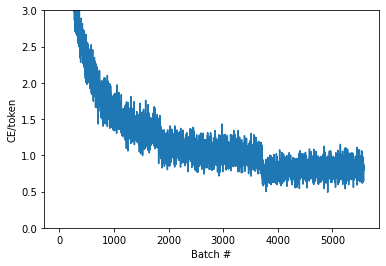

In [63]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

## Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [64]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [65]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [66]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [67]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [68]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'vain mysteries', b'funny ham', b'drivers responding',
       b'mysterious ignoring', b'fashion votes'], dtype=object)

### Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [69]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [70]:
Translator.sample = sample

Test run this function on some random inputs:

In [71]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4506],
       [3577],
       [2961],
       [4586],
       [ 944]])>

### Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

In [72]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [73]:
Translator.translate = translate_unrolled

Run it on a simple input:

In [74]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its a long cold here .
this is my life .

CPU times: user 165 ms, sys: 4.37 ms, total: 169 ms
Wall time: 164 ms


If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.


In [75]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

Run the `tf.function` once to compile it:

In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 18.8 s, sys: 0 ns, total: 18.8 s
Wall time: 18.7 s


In [77]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold here .
this is my life .

CPU times: user 175 ms, sys: 0 ns, total: 175 ms
Wall time: 88 ms


In [78]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [79]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [80]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold here .
this is my life .

CPU times: user 175 ms, sys: 0 ns, total: 175 ms
Wall time: 170 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [81]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [82]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.79 s, sys: 0 ns, total: 1.79 s
Wall time: 1.77 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [83]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold here .
this is my life .

CPU times: user 40.1 ms, sys: 0 ns, total: 40.1 ms
Wall time: 17.1 ms


### Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [84]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.0000001  0.99999994 1.         0.99999994 1.         0.99999994]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

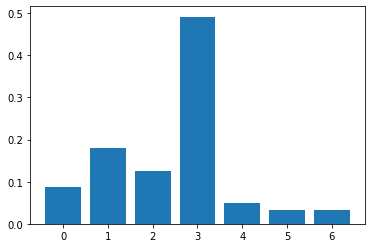

In [85]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

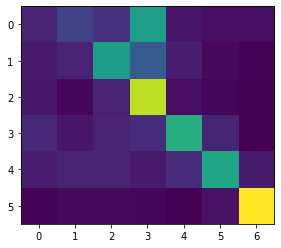

In [86]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [87]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


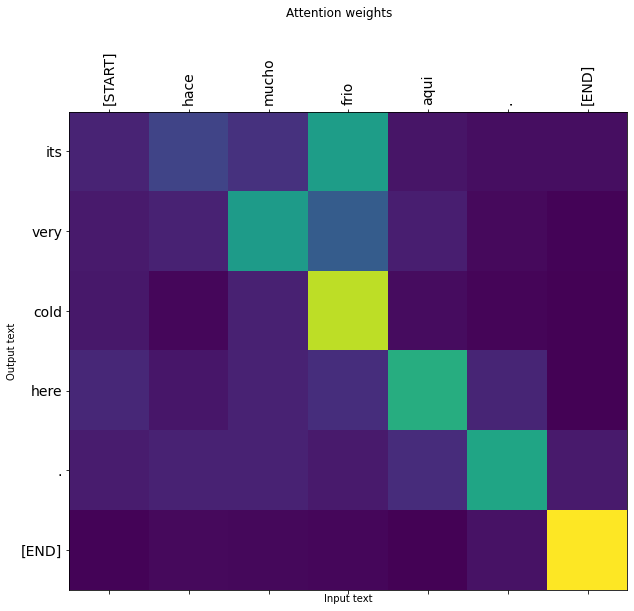

In [88]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Translate a few more sentences and plot them:

In [89]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
all about killed .

CPU times: user 78 ms, sys: 23 ms, total: 101 ms
Wall time: 23.1 ms


In [90]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are you still at home ?',
       b'all about killed .'], dtype=object)>

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


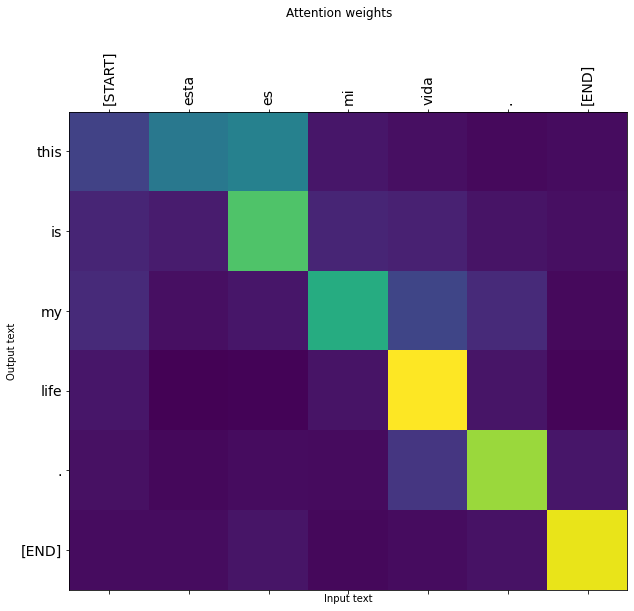

In [91]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


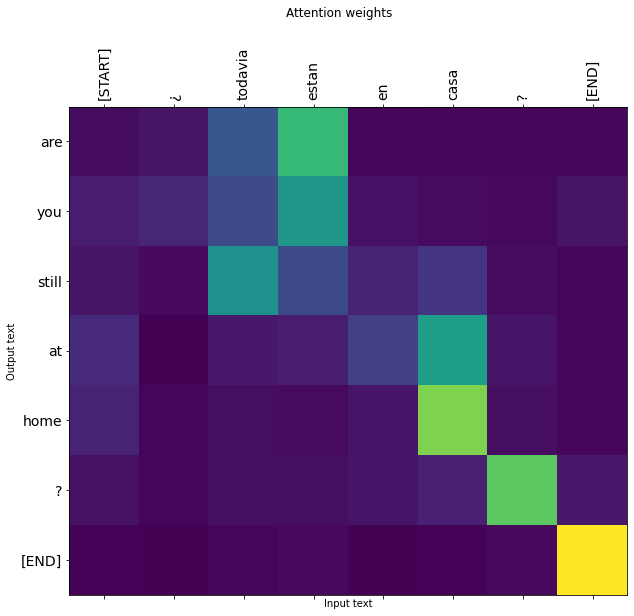

In [92]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


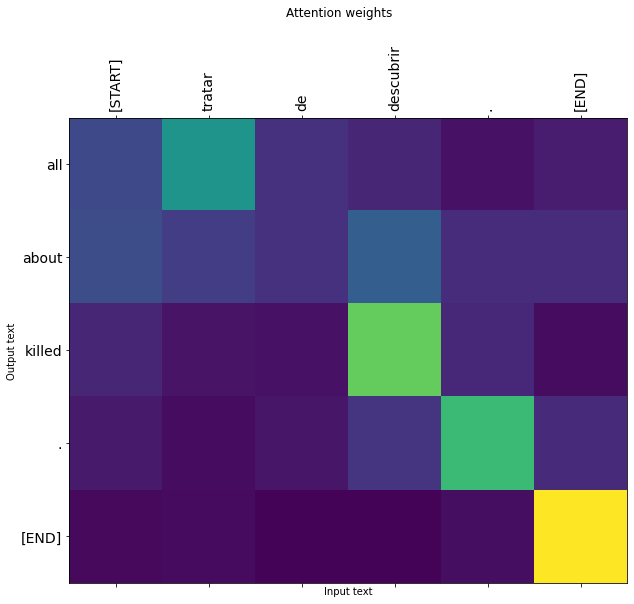

In [93]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. [Transformers](transformer.ipynb) solve this by using self-attention in the encoder and decoder.

In [94]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


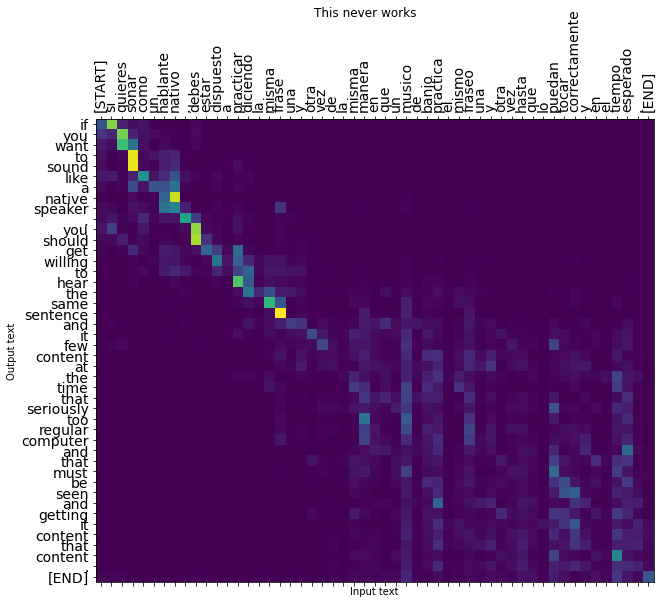

In [95]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

## Export

Once you have a model you're satisfied with you might want to export it as a `tf.saved_model` for use outside of this python program that created it.

Since the model is a subclass of `tf.Module` (through `keras.Model`), and all the functionality for export is compiled in a `tf.function` the model should export cleanly with `tf.saved_model.save`:  

Now that the function has been traced it can be exported using `saved_model.save`:

In [96]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

2021-12-04 12:27:54.310890: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [97]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [98]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
find out about to find out .

CPU times: user 42.8 ms, sys: 7.69 ms, total: 50.5 ms
Wall time: 20 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses a transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement wordpiece tokenization.
* Have a look at the [tensorflow_addons.seq2seq](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) for implementing this sort of sequence to sequence model. The `tfa.seq2seq` package includes higher level functionality like `seq2seq.BeamSearchDecoder`. 